# Cycling Network Analysis – Graz

Course: GIS Analysis Techniques 2  
Group: 1  
Authors: Fleischhacker, Y.;  Galitschitsch, M.;  Koschu, K.;  Lambert, D.​


In [20]:
import sys

import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
from keplergl import KeplerGl
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import LineString, Polygon, MultiPolygon
from scipy.interpolate import RectBivariateSpline
import json
from shapely.geometry import Point 
from shapely.geometry import box, Point
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import gc, time
import subprocess

print(sys.executable) #environment sanity check



c:\Users\kosch\anaconda3\envs\geo\python.exe


# Data preparation 

In [2]:
## Study Area ##
place = "Graz, Austria"
main_crs = "EPSG:31256"

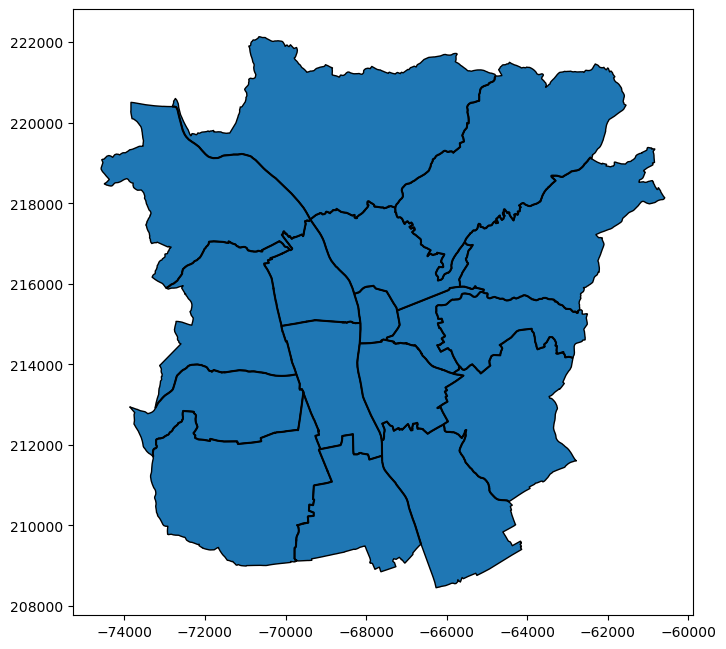

In [3]:
## city and districts ##
gdf_boundaries = ox.features_from_place(
    place,
    tags={"boundary": "administrative"}
)

df_districts = gdf_boundaries[gdf_boundaries["admin_level"] == "9"]
df_districts = df_districts.to_crs(main_crs)

df_districts.plot(edgecolor="black", figsize=(8, 8))
plt.show()

In [5]:
## main universities ##
name_map = {
    "Universitätsplatz 3, 8010 Graz": "KF Uni Graz",
    "Rechbauerstraße 12, 8010 Graz": "TU Graz",
    "Neue Stiftingtalstraße 6, 8010 Graz": "Med Uni Graz",
    "Leonhardstraße 15, 8010 Graz": "KUG",
    "Körblergasse 126, 8010 Graz": "Campus02",
    "Alte Poststraße 149, 8010 Graz": "FH Joanneum",
    "Hasnerplatz 12, 8010 Graz": "PHSt",
    "Inffeldgasse 25, 8010 Graz": "TU Graz/ Campus Inffeld",
}

poi = list(name_map.keys())

#Geocoding
coords = [ox.geocode(addr) for addr in poi]
uni_points = [Point(lon, lat) for lat, lon in coords]

#GeoDataFrame
graz_unis = gpd.GeoDataFrame(
    {"name": poi},
    geometry=uni_points,
    crs="EPSG:4326"
).to_crs(main_crs)
graz_unis["short_name"] = graz_unis["name"].map(name_map).fillna(graz_unis["name"])

In [16]:
## bike network (g_core) ##
G_raw = ox.graph_from_place(
    place,
    network_type="bike",
    simplify=True,
    retain_all=True
)
G_raw = ox.project_graph(G_raw, to_crs=main_crs)

nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_raw, nodes=True, edges=True)

def _to_str(x):
    return ",".join(map(str, x)) if isinstance(x, list) else str(x)

edges_gdf["highway_str"] = edges_gdf["highway"].apply(_to_str)

is_service = edges_gdf["highway_str"].str.contains("service", na=False)

is_driveway = pd.Series(False, index=edges_gdf.index)
if "service" in edges_gdf.columns:
    svc_str = edges_gdf["service"].apply(_to_str)
    is_driveway |= svc_str.isin(["driveway", "parking_aisle"])

is_forbidden = pd.Series(False, index=edges_gdf.index)
if "access" in edges_gdf.columns:
    is_forbidden |= edges_gdf["access"].isin(["private", "no"])
if "bicycle" in edges_gdf.columns:
    is_forbidden |= edges_gdf["bicycle"].isin(["no"])

service_bad = is_service & (is_driveway | is_forbidden)
non_service = ~is_service

touch_non_service = pd.Series(False, index=pd.Index(list(G_raw.nodes), dtype=object))
for (u, v, k), is_ns in non_service.items():
    if is_ns:
        touch_non_service.at[u] = True
        touch_non_service.at[v] = True

drop = pd.Series(False, index=edges_gdf.index)
for (u, v, k) in edges_gdf.index[service_bad]:
    if (not touch_non_service.get(u, False)) and (not touch_non_service.get(v, False)):
        drop.at[(u, v, k)] = True

edges_keep = edges_gdf.loc[~drop].copy()

nodes_keep = set(edges_keep.index.get_level_values(0)).union(
    set(edges_keep.index.get_level_values(1))
)
nodes_keep_gdf = nodes_gdf.loc[list(nodes_keep)].copy()

G_bike = ox.graph_from_gdfs(nodes_keep_gdf, edges_keep)

largest_wcc_nodes = max(nx.weakly_connected_components(G_bike), key=len)
G_core = G_bike.subgraph(largest_wcc_nodes).copy()


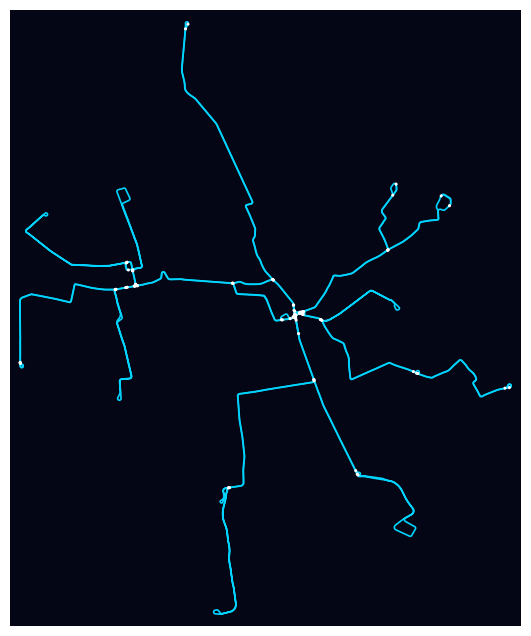

In [ ]:
## Tram network ##
def get_tram_network(place: str, main_crs: str):
    tram_filter = (
        '["railway"="tram"]'
        '["service"!="yard"]'
        '["service"!="siding"]'
        '["service"!="spur"]'
    )

    tram = ox.graph_from_place(
        place,
        custom_filter=tram_filter,
        simplify=True,
        retain_all=True
    )

    tram = ox.project_graph(tram, to_crs=main_crs)

    largest_wcc_nodes = max(nx.weakly_connected_components(tram), key=len)
    tram_main = tram.subgraph(largest_wcc_nodes).copy()

    nodes_gdf, edges_gdf = ox.graph_to_gdfs(tram_main, nodes=True, edges=True)

    if "length" not in edges_gdf.columns:
        edges_gdf["length"] = edges_gdf.geometry.length
    else:
        edges_gdf["length"] = edges_gdf["length"].fillna(edges_gdf.geometry.length)

    keep_cols = ["geometry", "length", "name", "service", "railway"]
    keep_cols = [c for c in keep_cols if c in edges_gdf.columns]
    tram_lines = gpd.GeoDataFrame(edges_gdf[keep_cols].copy(), geometry="geometry", crs=nodes_gdf.crs)

    return tram_main, tram_lines

tram_main, tram_lines = get_tram_network(place, main_crs)

#Plot
fig, ax = ox.plot_graph(
    tram_main,
    node_size=5,
    bgcolor="#040615",
    edge_color="#00d4ff",
    edge_linewidth=1.2
)


# Preprocessing

In [ ]:
## DEM ##
#path = Path(r"C:\Users\kosch\Desktop\final-project-group1-cycling-network\data_dem")

#raw_dirs = [path / s for s in ("352x20x","352x21x","353x20x","353x21x","354x20x","354x21x")]

#tiff = sorted({p for d in raw_dirs if d.exists() for p in d.rglob("*.tif")})

#city_geom = df_districts.to_crs(main_crs).dissolve().geometry.iloc[0]

# fixing
#fixed_dir = path / "_fixed_tiles"
#fixed_dir.mkdir(exist_ok=True)

#FIX_NODATA = -9999.0
#fixed_tifs = []
#for p in tiff:
#    out_p = fixed_dir / f"{p.parent.name}__{p.name}"
#
#    if not out_p.exists():
#        with rasterio.open(p) as src:
#            data = src.read(1).astype("float32")
#            data[data < -1e20] = FIX_NODATA

#            meta = src.meta.copy()
#            meta.update(dtype="float32", nodata=FIX_NODATA, count=1)

#        with rasterio.open(out_p, "w", **meta) as dst:
#            dst.write(data, 1)

#    fixed_tifs.append(out_p)

# mosaic
#srcs = [rasterio.open(p) for p in fixed_tifs]
#try:
#    mosaic, mosaic_transform = merge(srcs, nodata=FIX_NODATA, dtype="float32")
#    meta = srcs[0].meta.copy()
#finally:
#    for s in srcs:
#        s.close()

#meta.update(
#    height=mosaic.shape[1],
#    width=mosaic.shape[2],
#    transform=mosaic_transform,
#    dtype="float32",
#    nodata=FIX_NODATA,
#    count=mosaic.shape[0],
#)

# crs
#dst_transform, dst_width, dst_height = calculate_default_transform(
#    meta["crs"], main_crs, meta["width"], meta["height"],
#    *rasterio.transform.array_bounds(meta["height"], meta["width"], meta["transform"])
#)

#reproj = np.empty((meta["count"], dst_height, dst_width), dtype="float32")
#for i in range(meta["count"]):
#    reproject(
#        source=mosaic[i],
#        destination=reproj[i],
#        src_transform=meta["transform"],
#        src_crs=meta["crs"],
#        dst_transform=dst_transform,
#        dst_crs=main_crs,
#        resampling=Resampling.bilinear,
#        src_nodata=FIX_NODATA,
#        dst_nodata=FIX_NODATA,
#    )

#reproj_meta = meta.copy()
#reproj_meta.update(crs=main_crs, transform=dst_transform, width=dst_width, height=dst_height)

# clip and save
#with rasterio.io.MemoryFile() as mf:
#    with mf.open(**reproj_meta) as ds:
#        ds.write(reproj)

#        out_img, out_transform = mask(ds, [city_geom], crop=True, nodata=FIX_NODATA)

#        out_meta = ds.meta.copy()
#        out_meta.update(height=out_img.shape[1], width=out_img.shape[2], transform=out_transform, nodata=FIX_NODATA)

#final_path = Path("..") / "data" / "processed" / "dem_graz.tif"
#with rasterio.open(final_path, "w", **out_meta) as dst:
#    dst.write(out_img)

In [ ]:
## Calculation slope ##
dem_path = Path("..") / "data" / "processed" / "dem_graz.tif"
slope_path = Path("..") / "data" / "processed" / "slope_graz.tif"

result = subprocess.run([
        "gdaldem", "slope", str(dem_path), str(slope_path),
        "-s", "1",                 
        "-compute_edges",             
        "-of", "GTiff",               
        "-co", "COMPRESS=LZW",        
        "-co", "TILED=YES"           
    ], 
    capture_output=True, 
    text=True, 
    timeout=300
    )

In [19]:
## Snapping ##
graz_unis_proj = graz_unis.to_crs(main_crs).copy()

if "short_name" not in graz_unis_proj.columns:
    graz_unis_proj["short_name"] = graz_unis_proj["name"]

nodes, node_dists = ox.distance.nearest_nodes(
    G_core,
    X=graz_unis_proj.geometry.x.to_numpy(),
    Y=graz_unis_proj.geometry.y.to_numpy(),
    return_dist=True
)
graz_unis_proj["core_node"] = nodes
graz_unis_proj["snap_dist_m"] = node_dists

edges, edge_dists = ox.distance.nearest_edges(
    G_core,
    X=graz_unis_proj.geometry.x.to_numpy(),
    Y=graz_unis_proj.geometry.y.to_numpy(),
    return_dist=True
)
graz_unis_proj["core_edge"] = edges
graz_unis_proj["snap_edge_dist_m"] = edge_dists

print(graz_unis_proj[["short_name", "name", "core_node", "snap_dist_m"]].sort_values("snap_dist_m", ascending=False))


                short_name                                 name    core_node  \
7  TU Graz/ Campus Inffeld           Inffeldgasse 25, 8010 Graz  12459216275   
4                 Campus02          Körblergasse 126, 8010 Graz   1359825555   
2             Med Uni Graz  Neue Stiftingtalstraße 6, 8010 Graz    266012637   
0              KF Uni Graz       Universitätsplatz 3, 8010 Graz   3871900100   
3                      KUG         Leonhardstraße 15, 8010 Graz   1120599503   
6                     PHSt            Hasnerplatz 12, 8010 Graz    773222019   
1                  TU Graz        Rechbauerstraße 12, 8010 Graz   4113732444   
5              FH Joanneum       Alte Poststraße 149, 8010 Graz  13384518939   

   snap_dist_m  
7   106.992237  
4    96.615832  
2    57.639884  
0    55.232284  
3    44.373593  
6    44.120209  
1    28.696822  
5    13.708686  


# Analysis

In [ ]:
warnings.filterwarnings("ignore")

print("=" * 60)
print("SETUP: Pre-computing distance maps for all routing analyses (NEW)")
print("=" * 60)

if "core_node" not in graz_unis_proj.columns:
    raise ValueError("graz_unis_proj must contain column 'core_node' (snapped node ids on G_core).")

if tram_lines.crs is None:
    raise ValueError("tram_lines has no CRS. Ensure tram_lines is projected to main_crs.")
if str(tram_lines.crs) != str(main_crs):
    tram_lines = tram_lines.to_crs(main_crs)

# Ensure edge length exists (meters). If missing, compute from geometry length.
edges_tmp = ox.graph_to_gdfs(G_core, nodes=False, edges=True)
if "length" not in edges_tmp.columns:
    print("No 'length' attribute found on edges -> computing from geometry length.")
    for u, v, k, data in G_core.edges(keys=True, data=True):
        geom = data.get("geometry", None)
        if geom is None:
            x1, y1 = G_core.nodes[u]["x"], G_core.nodes[u]["y"]
            x2, y2 = G_core.nodes[v]["x"], G_core.nodes[v]["y"]
            geom = LineString([(x1, y1), (x2, y2)])
            data["geometry"] = geom
        data["length"] = float(geom.length)

# 1) District polygons

valid_districts = []
for _, district in df_districts.iterrows():
    geom = district.geometry
    if isinstance(geom, (Polygon, MultiPolygon)):
        valid_districts.append(district)

print(f"\nProcessing {len(valid_districts)} valid district polygons")

# University nodes 
all_uni_node_ids = graz_unis_proj["core_node"].dropna().tolist()
print(f"Total universities (snapped): {len(all_uni_node_ids)}\n")

# Load slope raster
print("Loading slope data...")
PROJECT_ROOT = Path.cwd().parent 
slope_path = PROJECT_ROOT / "data" / "processed" / "slope_graz.tif"
use_slope = True

with rasterio.open(slope_path) as src:
    slope_data = src.read(1)
    slope_transform = src.transform
    slope_nodata = src.nodata

print(f"  Loaded slope raster: {slope_data.shape}, nodata={slope_nodata}")

def sample_slope_pct(x, y):
    """Sample slope (%) at (x,y) in projected CRS using nearest raster cell."""
    try:
        row, col = rasterio.transform.rowcol(slope_transform, x, y)
        if 0 <= row < slope_data.shape[0] and 0 <= col < slope_data.shape[1]:
            val = float(slope_data[row, col])
            if (slope_nodata is not None and val == slope_nodata) or np.isnan(val):
                return 0.0
            return val
        return 0.0
    except Exception:
        return 0.0

# Tram proximity (spatial)
print("Preparing tram spatial index...")
tram_sindex = tram_lines.sindex

TRAM_DIST_M = 15.0 

def edge_tram_distance_m(edge_geom):
    """Return min distance (m) from edge geometry to nearest tram line."""
    if edge_geom is None:
        return float("inf")

    minx, miny, maxx, maxy = edge_geom.bounds
    bbox = (minx - TRAM_DIST_M, miny - TRAM_DIST_M, maxx + TRAM_DIST_M, maxy + TRAM_DIST_M)

    cand_idx = list(tram_sindex.intersection(bbox))
    if not cand_idx:
        return float("inf")

    cands = tram_lines.geometry.iloc[cand_idx]
    return float(cands.distance(edge_geom).min())

print("Tram index ready.")

# Speed-limit proxy + weighted cost
BIKE_KMH = 15.0  # average cycling speed for time estimation (tune: 12–18)

def get_speed_limit_kmh(edge_data):
    """Get car speed limit proxy (km/h) from OSM maxspeed or highway defaults."""
    if "maxspeed" in edge_data:
        try:
            speed_str = edge_data["maxspeed"]
            if isinstance(speed_str, list):
                speed_str = speed_str[0]
            s = str(speed_str).lower()
            # keep digits only if mixed strings (e.g., "30", "30 km/h")
            if "km" in s:
                s = s.split("km")[0]
            s = "".join(ch for ch in s if (ch.isdigit() or ch == "."))
            if s.strip() != "":
                return float(s)
        except Exception:
            pass

    highway_type = edge_data.get("highway", "residential")
    if isinstance(highway_type, list):
        highway_type = highway_type[0]

    default_limits = {
        "motorway": 120, "trunk": 100, "primary": 80, "secondary": 60,
        "tertiary": 50, "residential": 30, "living_street": 20,
        "pedestrian": 10, "path": 15, "cycleway": 25, "track": 20,
    }
    return float(default_limits.get(highway_type, 30))

def speed_risk_penalty(speed_limit_kmh):
    """
    Penalty for riding next to faster motor traffic.
    No penalty up to 30 km/h, then increasing smoothly.
    """
    if speed_limit_kmh <= 30:
        return 1.0
    # Quadratic growth keeps it gentle but meaningful
    return 1.0 + ((speed_limit_kmh - 30.0) / 50.0) ** 2

def slope_penalty_factor(slope_pct):
    """Penalty for steepness (absolute slope)."""
    return 1.0 + (abs(slope_pct) / 100.0) ** 2

def compute_weighted_cost_seconds(length_m, speed_limit_kmh, has_tramway, slope_pct):
    """
    Weighted generalized cost = bike travel time (seconds) * penalties.
    Output unit: seconds (penalized bike travel time).
    """
    # Base bike travel time (seconds) using constant bike speed
    bike_time_s = length_m / (BIKE_KMH / 3.6)

    # Penalties (dimensionless multipliers)
    risk = speed_risk_penalty(speed_limit_kmh)
    tram = 1.2 if has_tramway else 1.0
    slope = slope_penalty_factor(slope_pct)

    return float(bike_time_s * risk * tram * slope)

# Add weights to ALL edges in G_core (MultiDiGraph safe)
print("\nAdding weighted costs to G_core edges...")

edge_count = 0
tram_true = 0

for u, v, k, data in G_core.edges(keys=True, data=True):
    length_m = float(data.get("length", 100.0))

    geom = data.get("geometry", None)
    if geom is None:
        x1, y1 = G_core.nodes[u]["x"], G_core.nodes[u]["y"]
        x2, y2 = G_core.nodes[v]["x"], G_core.nodes[v]["y"]
        geom = LineString([(x1, y1), (x2, y2)])
        data["geometry"] = geom

    # speed limit proxy (NOT bike speed)
    speed_limit_kmh = get_speed_limit_kmh(data)

    # slope at midpoint
    if use_slope:
        midpt = geom.interpolate(0.5, normalized=True)
        slope_pct = sample_slope_pct(midpt.x, midpt.y)
    else:
        slope_pct = 0.0

    # tram proximity
    tram_dist = edge_tram_distance_m(geom)
    has_tram = tram_dist <= TRAM_DIST_M
    if has_tram:
        tram_true += 1

    # weighted cost in seconds (penalized bike travel time)
    weighted_cost_s = compute_weighted_cost_seconds(length_m, speed_limit_kmh, has_tram, slope_pct)

    # store attributes
    data["weighted_cost"] = float(weighted_cost_s)  # seconds
    data["bike_speed_kmh"] = float(BIKE_KMH)
    data["speed_limit_kmh"] = float(speed_limit_kmh)
    data["has_tramway"] = bool(has_tram)
    data["tram_dist_m"] = float(tram_dist if np.isfinite(tram_dist) else 999999.0)
    data["slope_pct"] = float(slope_pct)

    edge_count += 1

print(f"  Added weighted costs to {edge_count} edges")
print(f"  Edges flagged near tram (<= {TRAM_DIST_M} m): {tram_true} ({tram_true/edge_count:.2%})")
print(f"  Weighted cost unit: seconds (penalized bike travel time), BIKE_KMH={BIKE_KMH}")

# sanity: confirm required weights exist on edges
sample = list(G_core.edges(keys=True, data=True))[:300]
assert all(("length" in d and d["length"] is not None) for _,_,_,d in sample)
assert all(("weighted_cost" in d and d["weighted_cost"] is not None) for _,_,_,d in sample)
print("OK: 'length' and 'weighted_cost' exist on sampled edges.")

#  Pre-compute Dijkstra maps for each university

print("\nPre-computing shortest-path distances from each university...")
uni_distance_maps = {}

for uni_node in all_uni_node_ids:
    # length-based (meters)
    distances_length = nx.single_source_dijkstra_path_length(G_core, source=uni_node, weight="length")
    paths_length = nx.single_source_dijkstra_path(G_core, source=uni_node, weight="length")

    # weighted-based (seconds)
    distances_weighted = nx.single_source_dijkstra_path_length(G_core, source=uni_node, weight="weighted_cost")
    paths_weighted = nx.single_source_dijkstra_path(G_core, source=uni_node, weight="weighted_cost")

    uni_distance_maps[uni_node] = {
        "distances_length": distances_length,
        "paths_length": paths_length,
        "distances_weighted": distances_weighted,
        "paths_weighted": paths_weighted,
    }

print(f"  Pre-computed paths for {len(uni_distance_maps)} universities")


# Fast lookup using precomputed maps

def find_nearest_uni_fast(node, uni_nodes, uni_distance_maps, weight_type="weighted_cost"):
    """Return nearest university by chosen weight ('length' or 'weighted_cost')."""
    best_cost = float("inf")
    best_uni = None
    best_path = None

    if weight_type == "weighted_cost":
        distances_key = "distances_weighted"
        paths_key = "paths_weighted"
    elif weight_type == "length":
        distances_key = "distances_length"
        paths_key = "paths_length"
    else:
        raise ValueError("weight_type must be 'length' or 'weighted_cost'")

    for uni_node in uni_nodes:
        dist_map = uni_distance_maps[uni_node][distances_key]
        if node in dist_map:
            cost = dist_map[node]
            if cost < best_cost:
                best_cost = cost
                best_uni = uni_node
                best_path = uni_distance_maps[uni_node][paths_key][node]

    if best_uni is not None:
        return {"uni_node": best_uni, "cost": best_cost, "path": best_path}
    return None

print(f"\n{'='*60}")
print("Setup complete. Dijkstra pre-computation done (NEW).")
print(f"{'='*60}\n")


SETUP: Pre-computing distance maps for all routing analyses (NEW)

Processing 17 valid district polygons
Total universities (snapped): 8

Loading slope data...
  Loaded slope raster: (13668, 13993), nodata=-9999.0
Preparing tram spatial index...
Tram index ready.

Adding weighted costs to G_core edges...
  Added weighted costs to 50917 edges
  Edges flagged near tram (<= 15.0 m): 3587 (7.04%)
  Weighted cost unit: seconds (penalized bike travel time), BIKE_KMH=15.0
OK: 'length' and 'weighted_cost' exist on sampled edges.

Pre-computing shortest-path distances from each university...
  Pre-computed paths for 8 universities

Setup complete. Dijkstra pre-computation done (NEW).



# Results 
# Routes compare

In [ ]:
origins = [
    847359601,
    293463968,
    330194485
]
def find_best_route(graph, origin, targets, weight):
    best = {"cost": np.inf, "path": None, "target": None}
    for t in targets:
        try:
            c = nx.shortest_path_length(graph, origin, t, weight=weight)
            if c < best["cost"]:
                best["cost"] = c
                best["path"] = nx.shortest_path(graph, origin, t, weight=weight)
                best["target"] = t
        except nx.NetworkXNoPath:
            continue
    return best

def path_to_gdf(graph, path, cost, crs):
    if path is None or len(path) < 2:
        return gpd.GeoDataFrame({"cost": []}, geometry=[], crs=crs)
    coords = [(graph.nodes[n]["x"], graph.nodes[n]["y"]) for n in path]
    return gpd.GeoDataFrame(
        {"cost": [float(cost)]},
        geometry=[LineString(coords)],
        crs=crs
    )

def make_origin_gdf(graph, origin, crs):
    return gpd.GeoDataFrame(
        {"type": ["origin"], "origin_id": [origin]},
        geometry=[gpd.points_from_xy(
            [graph.nodes[origin]["x"]],
            [graph.nodes[origin]["y"]]
        )[0]],
        crs=crs
    )


def kepler_config_graz():
    return {
        "version": "v1",
        "config": {
            "mapState": {
                "latitude": 47.0707,
                "longitude": 15.4395,
                "zoom": 12,
                "bearing": 0,
                "pitch": 0
            }
        }
    }


for origin in origins:

    best_length = find_best_route(G_core, origin, core_nodes, "length")
    best_weighted = find_best_route(G_core, origin, core_nodes, "weighted_cost")

    route_length_gdf = path_to_gdf(
        G_core, best_length["path"], best_length["cost"], main_crs
    ).to_crs(epsg=4326)

    route_weighted_gdf = path_to_gdf(
        G_core, best_weighted["path"], best_weighted["cost"], main_crs
    ).to_crs(epsg=4326)

    origin_gdf = make_origin_gdf(G_core, origin, main_crs)

    points_gdf = gpd.GeoDataFrame(
        pd.concat([graz_unis_proj, origin_gdf], ignore_index=True),
        crs=main_crs
    ).to_crs(epsg=4326)

    kepler_map = KeplerGl(
        height=700,
        data={
            "Route – shortest length": route_length_gdf,
            "Route – lowest weighted cost": route_weighted_gdf,
            "Origin & Universities": points_gdf
        },
        config=kepler_config_graz()
    )
# save
    if origin == 847359601:
        kepler_map.save_to_html(
            file_name="maps/route_comparison_2.1.html",
            read_only=False
        )

    elif origin == 293463968:
        kepler_map.save_to_html(
            file_name="maps/route_comparison_1.1.html",
            read_only=False
        )

    elif origin == 330194485:
        kepler_map.save_to_html(
            file_name="maps/route_comparison_3.1.html",
            read_only=False
        )

    print(f"Saved map for origin {origin}")


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/route_comparison_2.1.html!
Saved map for origin 847359601
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/route_comparison_1.1.html!
Saved map for origin 293463968
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/route_comparison_3.1.html!
Saved map for origin 330194485


# Grid results: distance


In [ ]:

FIG_DIR = Path("figure")
FIG_DIR.mkdir(parents=True, exist_ok=True)

grid_size = 300  
G_routing = G_core

print("=" * 60)
print("GRID-BASED ROUTING ANALYSIS (300m grid) - length vs weighted")
print("=" * 60)


df_dist_proj = df_districts.to_crs(main_crs)
city_bounds = df_dist_proj.geometry.total_bounds

grid_cells = []
cell_id = 0
x = city_bounds[0]

while x < city_bounds[2]:
    y = city_bounds[1]
    while y < city_bounds[3]:
        grid_cells.append(
            {
                "cell_id": cell_id,
                "geometry": box(x, y, x + grid_size, y + grid_size),
            }
        )
        cell_id += 1
        y += grid_size
    x += grid_size

gdf_grid = gpd.GeoDataFrame(grid_cells, crs=main_crs)
print(f"Created {len(gdf_grid)} grid cells of {grid_size}m × {grid_size}m")

# ============================================================
# NODE → GRID ASSIGNMENT
# ============================================================

nodes_xy = [(n, d["x"], d["y"]) for n, d in G_routing.nodes(data=True)]

nodes_gdf = gpd.GeoDataFrame(
    {"node_id": [n for n, _, _ in nodes_xy]},
    geometry=[Point(x, y) for _, x, y in nodes_xy],
    crs=main_crs,
)

node_grid_join = gpd.sjoin(
    nodes_gdf, gdf_grid, how="inner", predicate="intersects"
)

nodes_by_cell = (
    node_grid_join.groupby("cell_id")["node_id"]
    .apply(list)
    .to_dict()
)

print(f"Assigned {len(node_grid_join)} nodes to grid cells")

# ============================================================
# UNIVERSITY NODES
# ============================================================

all_uni_node_ids = (
    graz_unis_proj["core_node"]
    .dropna()
    .astype(object)
    .unique()
    .tolist()
)

print(f"Total universities (snapped core nodes): {len(all_uni_node_ids)}")

# ============================================================
# ROUTING – LENGTH
# ============================================================

grid_results_len = {}

print("Routing nodes to nearest university (length)...")

for cid, nodes in nodes_by_cell.items():
    if not nodes:
        continue

    dists = []
    for origin in nodes:
        res = find_nearest_uni_fast(
            origin,
            all_uni_node_ids,
            uni_distance_maps,
            weight_type="length",
        )
        if res is not None:
            dists.append(res["cost"])

    if dists:
        grid_results_len[cid] = {
            "avg_distance_m": float(np.mean(dists)),
        }

gdf_grid["avg_distance_m"] = gdf_grid["cell_id"].map(
    lambda c: grid_results_len.get(c, {}).get("avg_distance_m", np.nan)
)

# ============================================================
# ROUTING – WEIGHTED COST
# ============================================================

grid_results_w = {}

print("Routing nodes to nearest university (weighted_cost)...")

for cid, nodes in nodes_by_cell.items():
    if not nodes:
        continue

    costs = []
    for origin in nodes:
        res = find_nearest_uni_fast(
            origin,
            all_uni_node_ids,
            uni_distance_maps,
            weight_type="weighted_cost",
        )
        if res is not None:
            costs.append(res["cost"])

    if costs:
        grid_results_w[cid] = {
            "avg_weighted_s": float(np.mean(costs)),
        }

gdf_grid["avg_weighted_s"] = gdf_grid["cell_id"].map(
    lambda c: grid_results_w.get(c, {}).get("avg_weighted_s", np.nan)
)

# ============================================================
# METRICS
# ============================================================

gdf = gdf_grid.dropna(
    subset=["avg_distance_m", "avg_weighted_s"]
).copy()

gdf["avg_weighted_time_min"] = gdf["avg_weighted_s"] / 60.0
gdf["distance_km"] = gdf["avg_distance_m"] / 1000.0
gdf["min_per_km"] = gdf["avg_weighted_time_min"] / gdf["distance_km"]

print(f"Grid cells with data: {len(gdf)}")

# ============================================================
# PLOTTING FUNCTION
# ============================================================

def save_grid_plot(
    gdf,
    column,
    title,
    filename,
    legend_label,
    figsize=(9, 7),
):
    fig, ax = plt.subplots(figsize=figsize)

    gdf.plot(
        ax=ax,
        column=column,
        cmap="RdYlGn_r",
        edgecolor="none",
        alpha=0.85,
        legend=True,
        legend_kwds={
            "label": legend_label,
            "orientation": "horizontal",
            "shrink": 0.7,
        },
    )

    graz_unis_proj.plot(
        ax=ax,
        color="red",
        markersize=60,
        marker="*",
        edgecolor="darkred",
    )

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_axis_off()
    plt.tight_layout()

    plt.savefig(
        FIG_DIR / filename,
        dpi=300,
        bbox_inches="tight",
    )
    plt.close(fig)

# ============================================================
# SAVE MAPS
# ============================================================

print("Saving figures...")

save_grid_plot(
    gdf,
    "avg_distance_m",
    "300m Grid: Avg Network Distance to Nearest University (m)",
    "grid_avg_distance_m.png",
    "Avg Network Distance (m)",
)

save_grid_plot(
    gdf,
    "avg_weighted_time_min",
    "300m Grid: Penalized Bike Travel Time (min)",
    "grid_avg_weighted_time_min.png",
    "Avg Penalized Travel Time (min)",
)

save_grid_plot(
    gdf,
    "min_per_km",
    "300m Grid: Penalized Effort (min/km)",
    "grid_penalized_min_per_km.png",
    "Penalized Minutes per km",
    figsize=(8, 6),
)

print("Grid analysis complete.")


GRID-BASED ROUTING ANALYSIS (300m grid) - length vs weighted
Created 2162 grid cells of 300m × 300m
Assigned 22179 nodes to grid cells
Total universities (snapped core nodes): 8
Routing nodes to nearest university (length)...
Routing nodes to nearest university (weighted_cost)...
Grid cells with data: 1389
Saving figures...
Grid analysis complete.


# Grid results: weighted

In [32]:
from pathlib import Path

FIG_DIR = Path("figure")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# WEIGHTED GRID ANALYSIS (Standalone)
# weighted_cost = penalized bike travel time (seconds) -> plotted as minutes
# ============================================================

print("="*60)
print("WEIGHTED GRID-BASED ROUTING ANALYSIS (300m grid) - G_core")
print("="*60)

# --- university nodes (snapped to G_core) ---
all_uni_node_ids = (
    graz_unis_proj["core_node"]
    .dropna()
    .astype(object)
    .unique()
    .tolist()
)
print(f"Total universities (snapped core nodes): {len(all_uni_node_ids)}")

print("\nRouting nodes to nearest university (weighted_cost, seconds)...")
grid_results_weighted = {}

# Use the precomputed grouping if available (faster)
# If you don't have nodes_by_cell, fall back to filtering node_grid_join each time.
try:
    nodes_by_cell  # noqa: F821
    cell_iter = nodes_by_cell.items()
    use_grouped = True
except NameError:
    cell_iter = [
        (cid, node_grid_join.loc[node_grid_join["cell_id"] == cid, "node_id"].tolist())
        for cid in gdf_grid["cell_id"].unique()
    ]
    use_grouped = False

for cell_id, nodes_in_cell in cell_iter:
    if not nodes_in_cell:
        continue

    costs_s = []
    for origin_node in nodes_in_cell:
        res = find_nearest_uni_fast(
            origin_node,
            all_uni_node_ids,
            uni_distance_maps,
            weight_type="weighted_cost"
        )
        if res is not None:
            costs_s.append(res["cost"])  # seconds

    if costs_s:
        grid_results_weighted[cell_id] = {
            "num_nodes": len(nodes_in_cell),
            "avg_weighted_s": float(np.mean(costs_s)),
            "min_weighted_s": float(np.min(costs_s)),
            "max_weighted_s": float(np.max(costs_s)),
        }

print(f"Processed {len(grid_results_weighted)} grid cells with nodes (weighted)")

# Attach to grid
gdf_grid["avg_weighted_s"] = gdf_grid["cell_id"].map(
    lambda x: grid_results_weighted.get(x, {}).get("avg_weighted_s", np.nan)
)
gdf_grid_weighted_with_data = gdf_grid.dropna(subset=["avg_weighted_s"]).copy()

# Convert to minutes for visualization
gdf_grid_weighted_with_data["avg_weighted_time_min"] = (
    gdf_grid_weighted_with_data["avg_weighted_s"] / 60.0
)

print(f"\n{'='*60}")
print(f"Grid cells with weighted routing data: {len(gdf_grid_weighted_with_data)}")
print(f"{'='*60}\n")

# --- visualize (SAVE ONLY, no display) ---
print("Creating weighted grid visualization...")

fig, ax = plt.subplots(figsize=(16, 14))

gdf_grid_weighted_with_data.plot(
    ax=ax,
    column="avg_weighted_time_min",
    cmap="RdYlGn_r",
    edgecolor="gray",
    alpha=0.7,
    legend=True,
    legend_kwds={
        "label": "Avg Penalized Bike Travel Time to University (min)",
        "orientation": "horizontal",
        "shrink": 0.8
    }
)

graz_unis_proj.plot(
    ax=ax,
    color="red",
    markersize=200,
    marker="*",
    edgecolor="darkred",
    linewidth=2,
    label="Universities"
)

ax.set_title(
    "300m Grid: Penalized Bike Travel Time to Nearest University (min)\n"
    "(constant bike speed + penalties for speed limits, tram proximity, slope)",
    fontsize=14,
    fontweight="bold"
)
ax.set_axis_off()
plt.tight_layout()

# SAVE (no plt.show)
out_path = FIG_DIR / "grid_weighted_time_min.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.close(fig)

print(f"Saved figure to: {out_path}")
print("\nWeighted grid analysis complete.\n")


WEIGHTED GRID-BASED ROUTING ANALYSIS (300m grid) - G_core
Total universities (snapped core nodes): 8

Routing nodes to nearest university (weighted_cost, seconds)...
Processed 1389 grid cells with nodes (weighted)

Grid cells with weighted routing data: 1389

Creating weighted grid visualization...
Saved figure to: figure\grid_weighted_time_min.png

Weighted grid analysis complete.



## Other Plot - Percentile

### Percentile clipping (2–98%) does not change the data, but it improves map readability by preventing outliers from stretching the color scale and thereby reveals spatial contrasts in the typical value range.

Percentile clipping only changes the **color scaling**, not your data.

* In a “normal” map, the color scale is set from the **minimum to the maximum** value in your dataset.
* If a few cells are **extremely high or low** (outliers), they stretch the scale.
* Result: most cells get squeezed into a narrow part of the color range and the map looks “all the same”.

**What percentile clipping (e.g., 2–98%) does:**

* Instead of min/max, it uses:

  * **vmin = the 2nd percentile value** (cuts off the lowest 2%)
  * **vmax = the 98th percentile value** (cuts off the highest 2%)
* Values **below vmin** are shown with the minimum color,
* values **above vmax** are shown with the maximum color.

**Key point:** the underlying values and rankings don’t change—only the visualization becomes easier to interpret because outliers no longer dominate the legend.


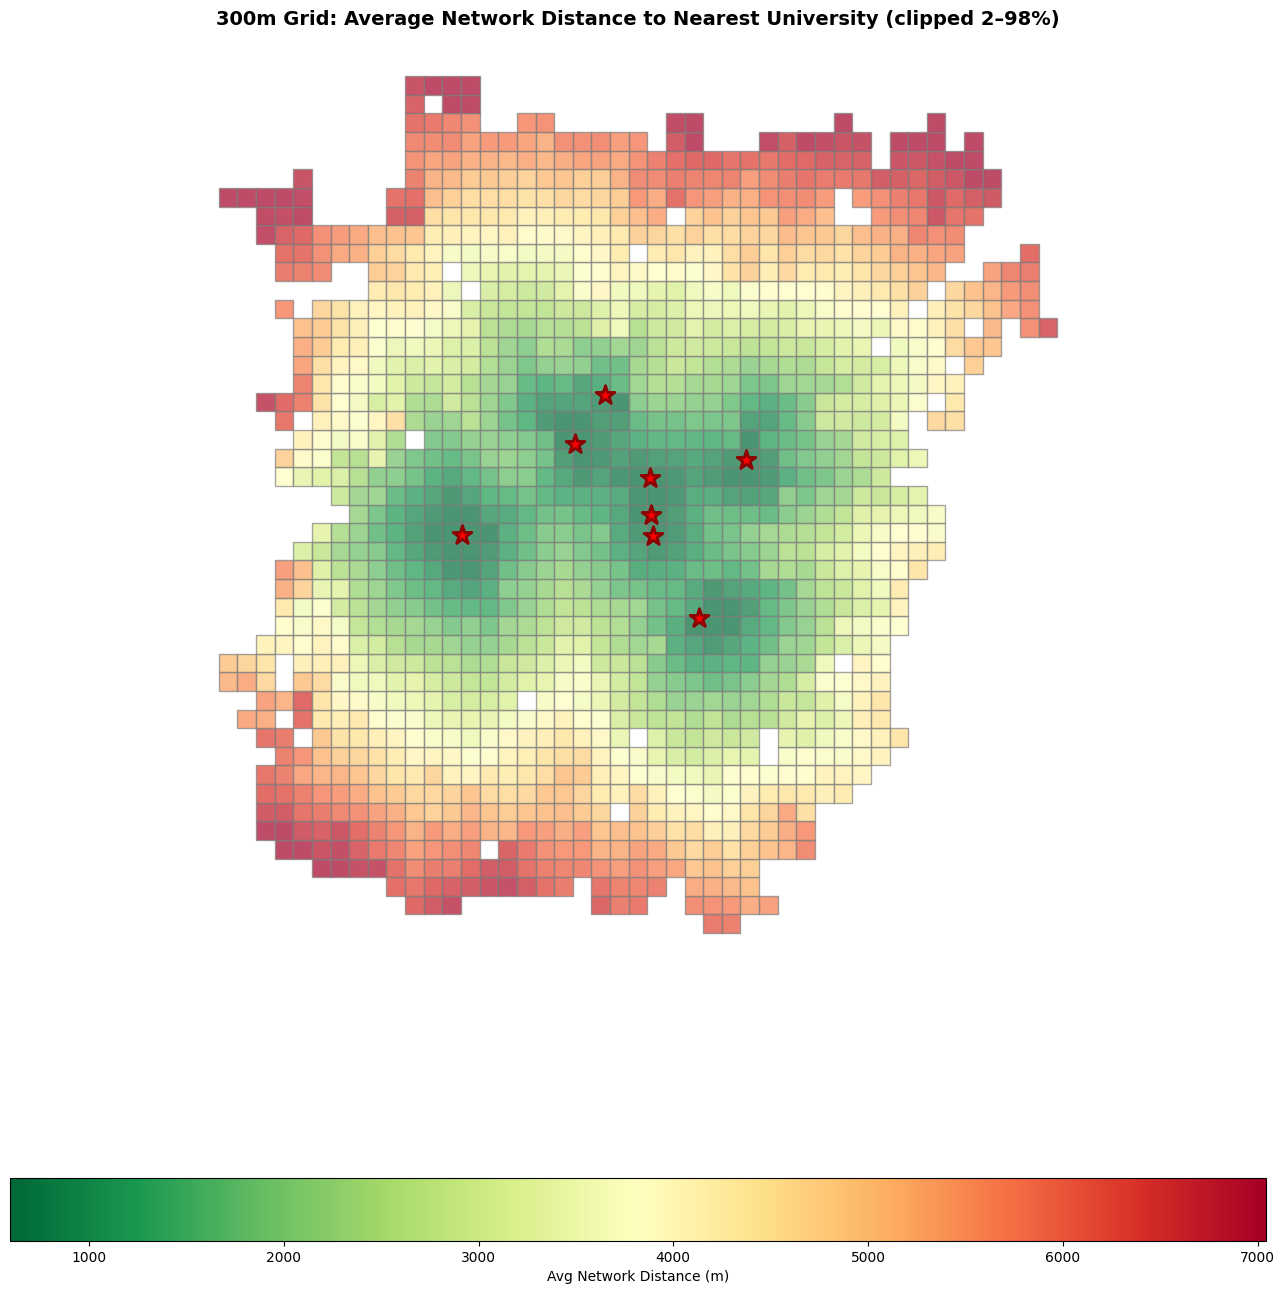

Distance (m) vmin/vmax: 594.0533581615832 7043.308127092835


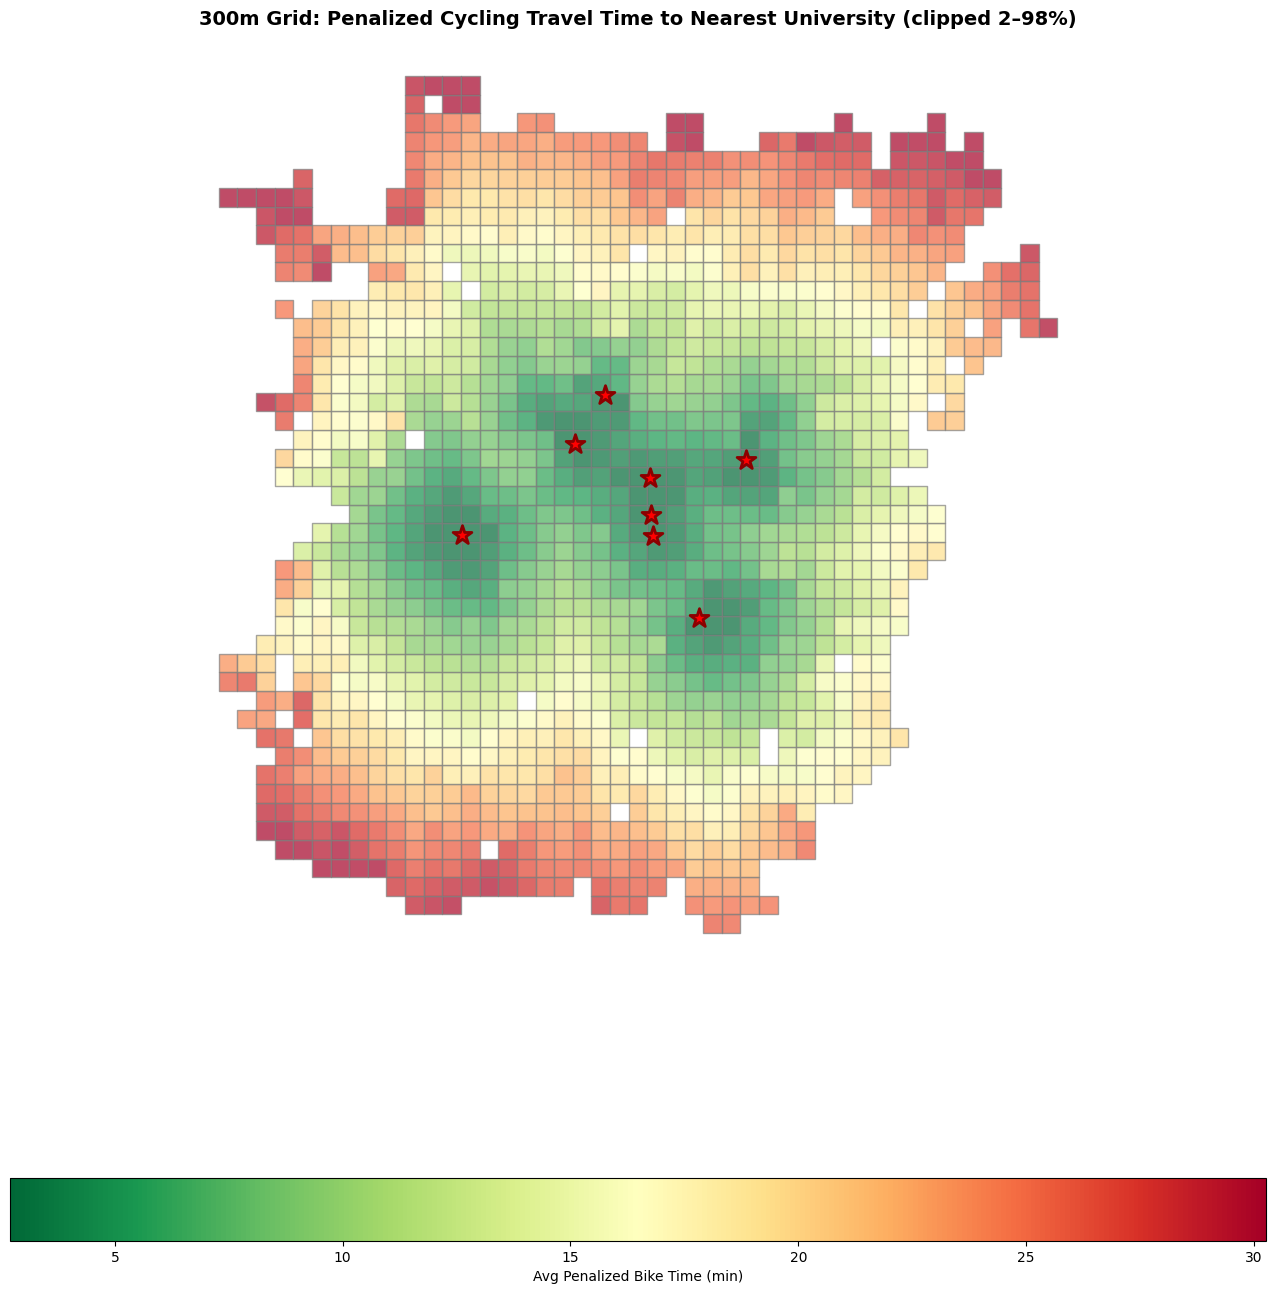

Weighted time (min) vmin/vmax: 2.6993964623589983 30.266213595121872


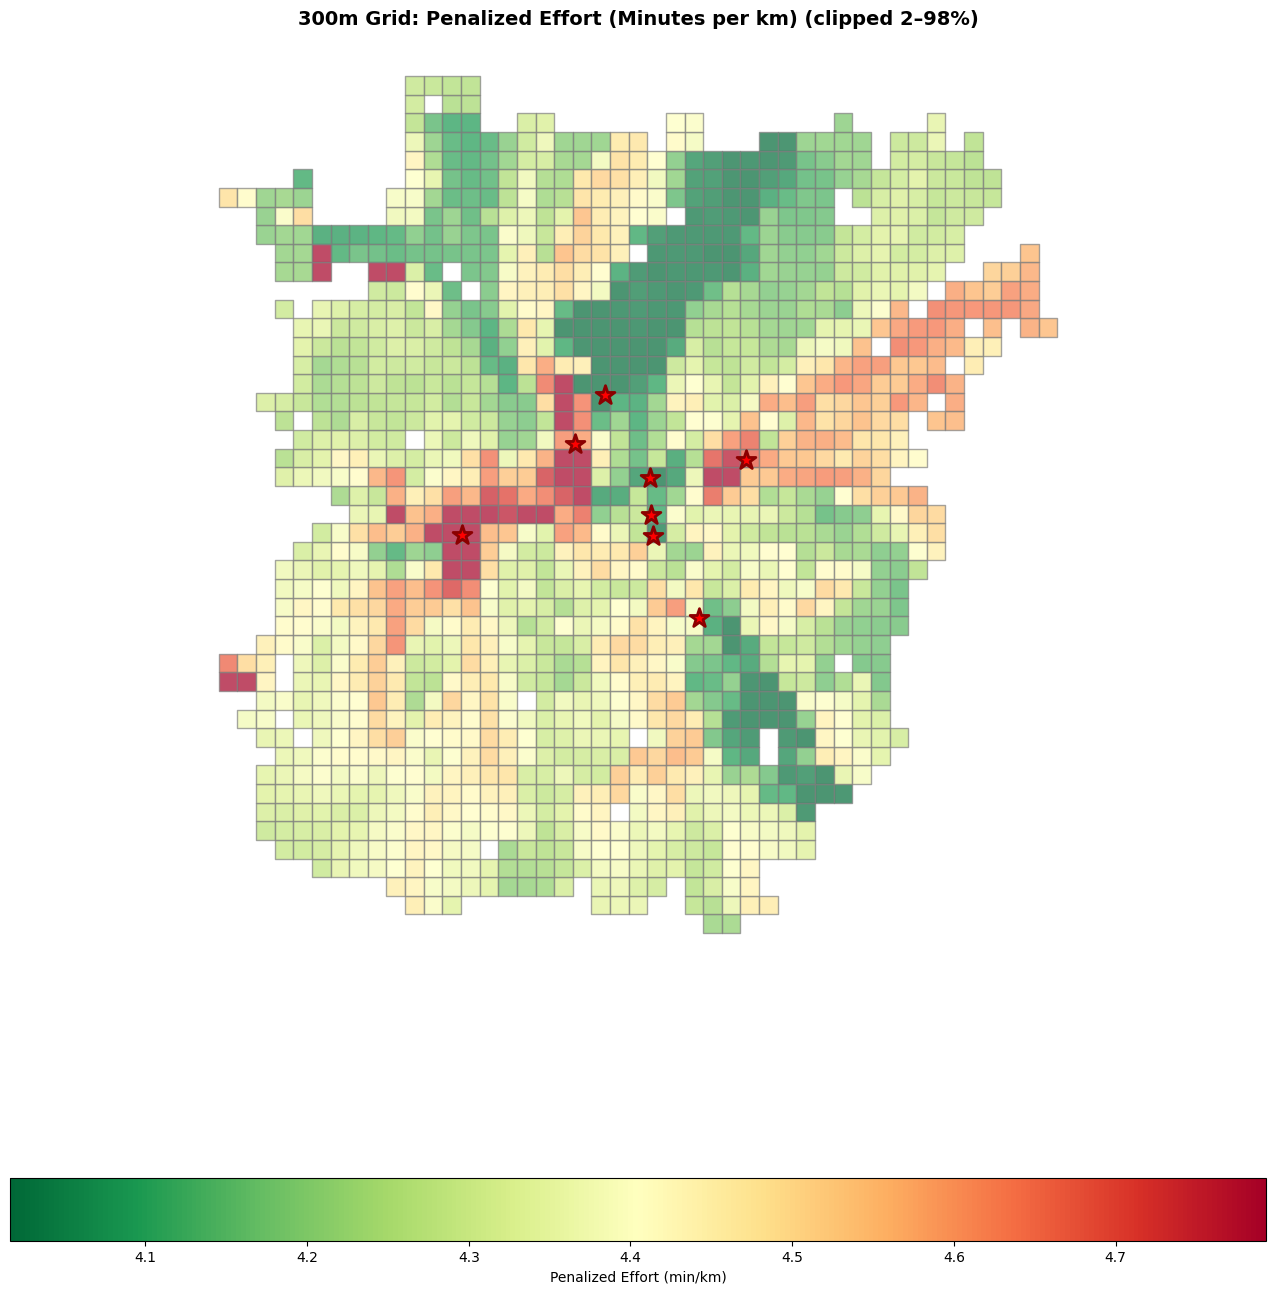

Min per km vmin/vmax: 4.016273658997026 4.793058357935775


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_with_percentile_clip(
    gdf,
    column,
    q_low=2,
    q_high=98,
    cmap="RdYlGn_r",
    title=None,
    legend_label=None,
    edgecolor="gray",
    alpha=0.7,
    figsize=(16, 14),
):
    vals = gdf[column].to_numpy()
    vals = vals[np.isfinite(vals)]
    if len(vals) == 0:
        raise ValueError(f"No finite values in column '{column}'")

    vmin, vmax = np.percentile(vals, [q_low, q_high])

    fig, ax = plt.subplots(figsize=figsize)
    gdf.plot(
        ax=ax,
        column=column,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        edgecolor=edgecolor,
        alpha=alpha,
        legend=True,
        legend_kwds={
            "label": legend_label if legend_label else column,
            "orientation": "horizontal",
            "shrink": 0.8,
        },
    )

    # overlay universities
    graz_unis_proj.plot(
        ax=ax, color="red", markersize=200, marker="*",
        edgecolor="darkred", linewidth=2
    )

    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_axis_off()
    plt.tight_layout()

    return ax, (vmin, vmax)


# 1) Distance (m)
_, (vmin1, vmax1) = plot_with_percentile_clip(
    gdf_grid_with_data,
    column="avg_distance_m",
    q_low=2, q_high=98,
    title="300m Grid: Average Network Distance to Nearest University (clipped 2–98%)",
    legend_label="Avg Network Distance (m)"
)
plt.show()
print("Distance (m) vmin/vmax:", vmin1, vmax1)

# 2) Weighted time (min)
_, (vmin2, vmax2) = plot_with_percentile_clip(
    gdf_grid_with_data,
    column="avg_weighted_time_min",
    q_low=2, q_high=98,
    title="300m Grid: Penalized Cycling Travel Time to Nearest University (clipped 2–98%)",
    legend_label="Avg Penalized Bike Time (min)"
)
plt.show()
print("Weighted time (min) vmin/vmax:", vmin2, vmax2)

# 3) Minutes per km (min/km)
_, (vmin3, vmax3) = plot_with_percentile_clip(
    gdf_grid_with_data,
    column="min_per_km",
    q_low=2, q_high=98,
    title="300m Grid: Penalized Effort (Minutes per km) (clipped 2–98%)",
    legend_label="Penalized Effort (min/km)"
)
plt.show()
print("Min per km vmin/vmax:", vmin3, vmax3)


## Statistical

## to do: same for weighted_cost?"

In [ ]:
# (3) District routing (uses outputs from Cell 2)

weight_type = "length"   # or "weighted_cost"

district_results = {}

for district_name, nodes_in_district in nodes_by_district.items():
    attempted_nodes = len(nodes_in_district)
    routed_nodes = 0
    costs = []
    routes_data = []

    for origin_node in nodes_in_district:
        res = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type=weight_type)
        if res is None:
            continue

        routed_nodes += 1
        cost = float(res["cost"])
        uni_node = res["uni_node"]
        uni_short = uni_node_to_short.get(uni_node, str(uni_node))

        costs.append(cost)
        routes_data.append({
            "origin_node": origin_node,
            "uni_node": uni_node,
            "uni_shortname": uni_short,
            "cost": cost,
            "district": district_name,
        })

    district_results[district_name] = {
        "attempted_nodes": attempted_nodes,
        "routed_nodes": routed_nodes,
        "success_rate": (routed_nodes / attempted_nodes) if attempted_nodes > 0 else np.nan,
        "avg_cost": float(np.mean(costs)) if routed_nodes > 0 else np.nan,
        "min_cost": float(np.min(costs)) if routed_nodes > 0 else np.nan,
        "max_cost": float(np.max(costs)) if routed_nodes > 0 else np.nan,
        "weight_type": weight_type,
        "routes": routes_data,
    }

summary_df = (
    pd.DataFrame.from_dict(district_results, orient="index")
      .reset_index()
      .rename(columns={"index": "District"})
      .sort_values("avg_cost", ascending=True)
)
summary_df


District  attempted_nodes  routed_nodes  success_rate     avg_cost  \
12  Sankt Leonhard              828           826      0.997585   820.742752   
2          Geidorf             1537          1534      0.998048  1016.273218   
5     Innere Stadt              585           552      0.943590  1156.816204   
7             Lend             1128          1125      0.997340  1443.763155   
6         Jakomini             1224          1216      0.993464  1629.650982   
1        Eggenberg             1143          1142      0.999125  1732.812346   
15      Waltendorf              875           872      0.996571  2101.703678   
3            Gries             1397          1391      0.995705  2294.927829   
13     Sankt Peter             1390          1387      0.997842  2596.090055   
11            Ries              839           837      0.997616  2668.638395   
16     Wetzelsdorf             1081          1080      0.999075  2681.256099   
8         Liebenau             1165          1159      0.994850  3617.557443   
9       Mariatrost             1800          1796      0.997778  3800.667977   
4          Gösting              948           942      0.993671  3976.593406   
0          Andritz             2821          2816      0.998228  4098.320367   
14       Straßgang             2123          2114      0.995761  4834.413217   
10        Puntigam             1297          1282      0.988435  5321.468018   

       min_cost     max_cost weight_type  \
12     0.000000  1699.192772      length   
2      0.000000  2494.548865      length   
5    462.917076  2087.043828      length   
7    104.737784  2928.798827      length   
6      0.000000  3045.128759      length   
1     40.575980  5743.056134      length   
15   523.073381  4589.075506      length   
3      0.000000  4267.924478      length   
13   295.482796  4753.778482      length   
11     0.000000  6654.843320      length   
16  1172.022541  5631.279027      length   
8   1591.782801  6312.292346      length   
9    878.364341  7506.494706      length   
4   1948.332482  7914.912530      length   
0   1667.893902  8094.398111      length   
14  1812.968024  7522.195520      length   
10  3435.485992  7063.704532      length   

                                               routes  
12  [{'origin_node': 20832657, 'uni_node': 1245921...  
2   [{'origin_node': 921579363, 'uni_node': 773222...  
5   [{'origin_node': 20911117, 'uni_node': 4113732...  
7   [{'origin_node': 20832681, 'uni_node': 1338451...  
6   [{'origin_node': 331467889, 'uni_node': 124592...  
1   [{'origin_node': 21532089, 'uni_node': 1338451...  
15  [{'origin_node': 560422287, 'uni_node': 124592...  
3   [{'origin_node': 20832635, 'uni_node': 4113732...  
13  [{'origin_node': 20824406, 'uni_node': 1245921...  
11  [{'origin_node': 21413780, 'uni_node': 2660126...  
16  [{'origin_node': 2115468931, 'uni_node': 13384...  
8   [{'origin_node': 20929475, 'uni_node': 1245921...  
9   [{'origin_node': 21301715, 'uni_node': 2660126...  
4   [{'origin_node': 21099649, 'uni_node': 7732220...  
0   [{'origin_node': 20929508, 'uni_node': 7732220...  
14  [{'origin_node': 20832642, 'uni_node': 1338451...  
10  [{'origin_node': 20832637, 'uni_node': 1338451...

### Quick Sanity checks

In [ ]:
import pandas as pd
import numpy as np

df = (
    pd.DataFrame.from_dict(district_results, orient="index")
      .reset_index()
      .rename(columns={"index": "district"})
)

# sort key depends on model
sort_col = "avg_cost"
df = df.sort_values(sort_col).reset_index(drop=True)

# rename cost columns to show units clearly
if df["weight_type"].iloc[0] == "length":
    df = df.rename(columns={
        "avg_cost": "avg_distance_m",
        "min_cost": "min_distance_m",
        "max_cost": "max_distance_m",
    })
else:
    df = df.rename(columns={
        "avg_cost": "avg_weighted_cost_s",
        "min_cost": "min_weighted_cost_s",
        "max_cost": "max_weighted_cost_s",
    })
    # optional: seconds -> minutes
    df["avg_weighted_cost_min"] = df["avg_weighted_cost_s"] / 60.0

# keep only the “report” columns
keep = [c for c in [
    "district", "weight_type",
    "attempted_nodes", "routed_nodes", "success_rate",
    "avg_distance_m", "min_distance_m", "max_distance_m",
    "avg_weighted_cost_s", "avg_weighted_cost_min", "min_weighted_cost_s", "max_weighted_cost_s"
] if c in df.columns]

df = df[keep]

display(df)
print("\nTop 5 (best accessibility):")
display(df.head(5))
print("\nBottom 5 (worst accessibility):")
display(df.tail(5))


district weight_type  attempted_nodes  routed_nodes  success_rate  \
0   Sankt Leonhard      length              828           826      0.997585   
1          Geidorf      length             1537          1534      0.998048   
2     Innere Stadt      length              585           552      0.943590   
3             Lend      length             1128          1125      0.997340   
4         Jakomini      length             1224          1216      0.993464   
5        Eggenberg      length             1143          1142      0.999125   
6       Waltendorf      length              875           872      0.996571   
7            Gries      length             1397          1391      0.995705   
8      Sankt Peter      length             1390          1387      0.997842   
9             Ries      length              839           837      0.997616   
10     Wetzelsdorf      length             1081          1080      0.999075   
11        Liebenau      length             1165          1159      0.994850   
12      Mariatrost      length             1800          1796      0.997778   
13         Gösting      length              948           942      0.993671   
14         Andritz      length             2821          2816      0.998228   
15       Straßgang      length             2123          2114      0.995761   
16        Puntigam      length             1297          1282      0.988435   

    avg_distance_m  min_distance_m  max_distance_m  
0       820.742752        0.000000     1699.192772  
1      1016.273218        0.000000     2494.548865  
2      1156.816204      462.917076     2087.043828  
3      1443.763155      104.737784     2928.798827  
4      1629.650982        0.000000     3045.128759  
5      1732.812346       40.575980     5743.056134  
6      2101.703678      523.073381     4589.075506  
7      2294.927829        0.000000     4267.924478  
8      2596.090055      295.482796     4753.778482  
9      2668.638395        0.000000     6654.843320  
10     2681.256099     1172.022541     5631.279027  
11     3617.557443     1591.782801     6312.292346  
12     3800.667977      878.364341     7506.494706  
13     3976.593406     1948.332482     7914.912530  
14     4098.320367     1667.893902     8094.398111  
15     4834.413217     1812.968024     7522.195520  
16     5321.468018     3435.485992     7063.704532


Top 5 (best accessibility):


district weight_type  attempted_nodes  routed_nodes  success_rate  \
0  Sankt Leonhard      length              828           826      0.997585   
1         Geidorf      length             1537          1534      0.998048   
2    Innere Stadt      length              585           552      0.943590   
3            Lend      length             1128          1125      0.997340   
4        Jakomini      length             1224          1216      0.993464   

   avg_distance_m  min_distance_m  max_distance_m  
0      820.742752        0.000000     1699.192772  
1     1016.273218        0.000000     2494.548865  
2     1156.816204      462.917076     2087.043828  
3     1443.763155      104.737784     2928.798827  
4     1629.650982        0.000000     3045.128759


Bottom 5 (worst accessibility):


district weight_type  attempted_nodes  routed_nodes  success_rate  \
12  Mariatrost      length             1800          1796      0.997778   
13     Gösting      length              948           942      0.993671   
14     Andritz      length             2821          2816      0.998228   
15   Straßgang      length             2123          2114      0.995761   
16    Puntigam      length             1297          1282      0.988435   

    avg_distance_m  min_distance_m  max_distance_m  
12     3800.667977      878.364341     7506.494706  
13     3976.593406     1948.332482     7914.912530  
14     4098.320367     1667.893902     8094.398111  
15     4834.413217     1812.968024     7522.195520  
16     5321.468018     3435.485992     7063.704532

In [ ]:
import pandas as pd
import numpy as np

summary_df = pd.DataFrame([
    {
        "District": district_name,
        "Attempted Nodes": stats.get("attempted_nodes", np.nan),
        "Routed Nodes": stats.get("routed_nodes", np.nan),
        "Success Rate": stats.get("success_rate", np.nan),
        "Avg Cost": stats.get("avg_cost", np.nan),
        "Min Cost": stats.get("min_cost", np.nan),
        "Max Cost": stats.get("max_cost", np.nan),
        "Weight Type": stats.get("weight_type", None),
    }
    for district_name, stats in district_results.items()
])

# optional: pretty formatting
if not summary_df.empty:
    summary_df["Success Rate"] = (summary_df["Success Rate"] * 100).round(1)
    for c in ["Avg Cost", "Min Cost", "Max Cost"]:
        summary_df[c] = summary_df[c].round(2)

print(summary_df.sort_values(["Weight Type", "Avg Cost"]).to_string(index=False))


      District  Attempted Nodes  Routed Nodes  Success Rate  Avg Cost  Min Cost  Max Cost Weight Type
Sankt Leonhard              828           826          99.8    820.74      0.00   1699.19      length
       Geidorf             1537          1534          99.8   1016.27      0.00   2494.55      length
  Innere Stadt              585           552          94.4   1156.82    462.92   2087.04      length
          Lend             1128          1125          99.7   1443.76    104.74   2928.80      length
      Jakomini             1224          1216          99.3   1629.65      0.00   3045.13      length
     Eggenberg             1143          1142          99.9   1732.81     40.58   5743.06      length
    Waltendorf              875           872          99.7   2101.70    523.07   4589.08      length
         Gries             1397          1391          99.6   2294.93      0.00   4267.92      length
   Sankt Peter             1390          1387          99.8   2596.09    295.48   

In [ ]:
# 1) how many districts have min cost = 0?
(summary_df["Min Cost"] == 0).sum(), summary_df.loc[summary_df["Min Cost"] == 0, "District"].tolist()


(np.int64(5), ['Geidorf', 'Gries', 'Jakomini', 'Ries', 'Sankt Leonhard'])

In [ ]:
# 2) zero-cost routes details
zero_routes = []
for dname, stats in district_results.items():
    for r in stats.get("routes", []):
        if r["cost"] == 0:
            zero_routes.append((dname, r["origin_node"], r["uni_node"], r["uni_shortname"]))
len(zero_routes), zero_routes[:10]


(8,
 [('Geidorf', 773222019, 773222019, 'Hasnerplatz 12, 80'),
  ('Geidorf', 3871900100, 3871900100, 'Universitätsplatz '),
  ('Geidorf', 1359825555, 1359825555, 'Körblergasse 126, '),
  ('Gries', 13384518939, 13384518939, 'Alte Poststraße 14'),
  ('Jakomini', 12459216275, 12459216275, 'Inffeldgasse 25, 8'),
  ('Ries', 266012637, 266012637, 'Neue Stiftingtalst'),
  ('Sankt Leonhard', 1120599503, 1120599503, 'Leonhardstraße 15,'),
  ('Sankt Leonhard', 4113732444, 4113732444, 'Rechbauerstraße 12')])

> **Note (0-cost routes):**  
> Some origin nodes coincide exactly with a university node (i.e., `origin_node == uni_node`). In these cases the shortest-path cost is **0** by definition, so a few districts show `Min Cost = 0`. This is **not an error**, but a valid special case.  
> For reporting “typical” accessibility, we optionally compute summary statistics **excluding zero-cost routes** (while keeping all routes in the dataset).


## BAR Chart

In [ ]:
import pandas as pd

rows = []
for dname, stats in district_results.items():
    for r in stats.get("routes", []):
        rows.append({"District": dname, "uni_shortname": r.get("uni_shortname")})

routes_df = pd.DataFrame(rows)

print("Unique uni_shortname values (as stored in routes):")
print(pd.Series(routes_df["uni_shortname"].dropna().unique()).to_string(index=False))

# show which ones do not match the keys exactly
unmatched = sorted(set(routes_df["uni_shortname"].dropna().unique()) - set(name_map.keys()))
print("\nUnmatched (no exact key hit in name_map):")
print(pd.Series(unmatched).to_string(index=False))


Unique uni_shortname values (as stored in routes):
Hasnerplatz 12, 80
Körblergasse 126, 
Alte Poststraße 14
Universitätsplatz 
Leonhardstraße 15,
Neue Stiftingtalst
Rechbauerstraße 12
Inffeldgasse 25, 8

Unmatched (no exact key hit in name_map):
Alte Poststraße 14
Hasnerplatz 12, 80
Inffeldgasse 25, 8
Körblergasse 126, 
Leonhardstraße 15,
Neue Stiftingtalst
Rechbauerstraße 12
Universitätsplatz 


### explanation
For each network node located within a district, we computed the shortest network distance to the nearest university (in terms of minimal path cost along the network). The nearest university can be located outside the district. The district-level value is the mean of these node-to-nearest-university distances.


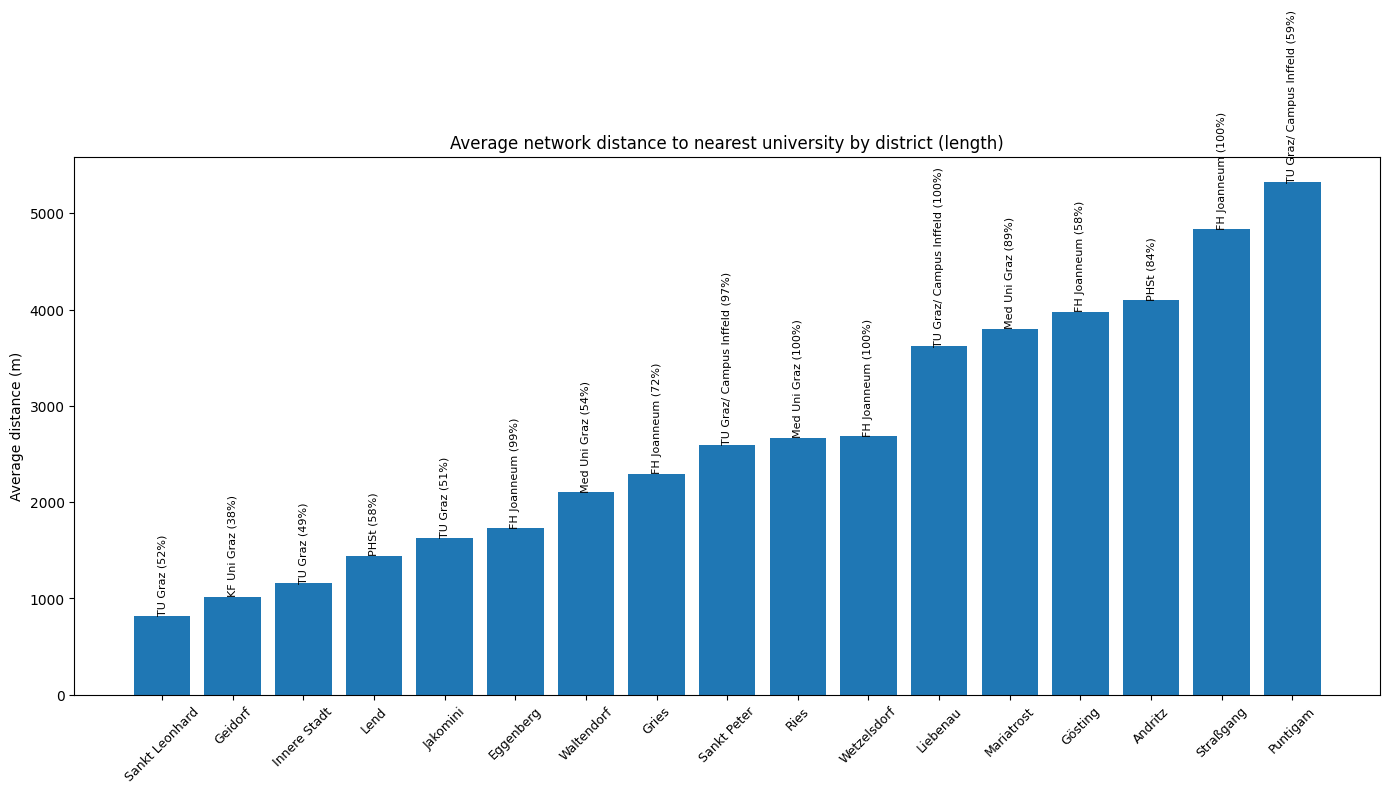

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Prefix -> label (works with truncated strings)
prefix_map = {
    "Universitätsplatz": "KF Uni Graz",
    "Rechbauerstraße 12": "TU Graz",
    "Neue Stiftingtal": "Med Uni Graz",
    "Leonhardstraße 15": "KUG",
    "Körblergasse 126": "Campus02",
    "Alte Poststraße 14": "FH Joanneum",
    "Hasnerplatz 12": "PHSt",
    "Inffeldgasse 25": "TU Graz/ Campus Inffeld",
}

def map_by_prefix(s):
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return s
    s = str(s).strip()
    for pref, lab in prefix_map.items():
        if s.startswith(pref):
            return lab
    return s  # fallback

# Build routes table
rows = []
for dname, stats in district_results.items():
    for r in stats.get("routes", []):
        rows.append({"District": dname, "uni_raw": r.get("uni_shortname")})
routes_df = pd.DataFrame(rows)

# Top-1 nearest uni per district + share
top_uni = (
    routes_df.dropna(subset=["uni_raw"])
             .groupby(["District", "uni_raw"])
             .size()
             .reset_index(name="n")
             .sort_values(["District", "n"], ascending=[True, False])
)

top1 = top_uni.groupby("District").head(1).copy()
totals = routes_df.groupby("District").size().reset_index(name="n_total")
top1 = top1.merge(totals, on="District", how="left")
top1["share_pct"] = (top1["n"] / top1["n_total"] * 100).round(1)

top1["uni_label"] = top1["uni_raw"].apply(map_by_prefix)

# Merge into summary_df and plot
plot_df = summary_df.dropna(subset=["Avg Cost"]).copy()
plot_df = plot_df.merge(top1[["District", "uni_label", "share_pct"]], on="District", how="left")
plot_df = plot_df.sort_values("Avg Cost", ascending=True)

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(plot_df["District"], plot_df["Avg Cost"])

ax.set_title("Average network distance to nearest university by district (length)")
ax.set_ylabel("Average distance (m)")
ax.tick_params(axis="x", rotation=45, labelsize=9)

for rect, uni, share in zip(bars, plot_df["uni_label"], plot_df["share_pct"]):
    label = "" if pd.isna(uni) else f"{uni} ({share:.0f}%)"
    ax.text(
        rect.get_x() + rect.get_width()/2,
        rect.get_height(),
        label,
        ha="center",
        va="bottom",
        rotation=90,
        fontsize=8
    )

plt.tight_layout()
plt.show()


### Result: District-level accessibility (length-based)

Average network distance to the nearest university (computed on the `G_core` network) varies strongly across districts. Central districts show the lowest mean distances, while peripheral districts exhibit substantially larger values (up to several kilometres). For each district, distances were calculated from all network nodes located inside the district boundary to their individually nearest university (minimum path length), and then averaged.

The university label shown above each bar indicates the most frequently selected nearest university for that district. The percentage in brackets represents the share of routed origin nodes for which this same university was the nearest option. High percentages (close to 100%) indicate a clear and consistent “catchment” dominated by one university, whereas lower percentages point to mixed catchments where different parts of the district are closer (in network terms) to different universities.


## Interactivity with kepler

In [ ]:
import geopandas as gpd

# Ensure we have the plot_df from your labeled bar chart step:
# expected columns: District, Avg Cost, uni_label, share_pct
required_cols = {"District", "Avg Cost", "uni_label", "share_pct"}
missing = required_cols - set(plot_df.columns)
if missing:
    raise KeyError(f"plot_df is missing columns: {missing}. Available: {list(plot_df.columns)}")

# Join district geometries with results
district_map_gdf = (
    valid_districts[["district_name", "geometry"]]
    .rename(columns={"district_name": "District"})
    .merge(plot_df[["District", "Avg Cost", "uni_label", "share_pct"]], on="District", how="left")
)

print("Rows:", len(district_map_gdf))
print(district_map_gdf[["District", "Avg Cost", "uni_label", "share_pct"]].head())


Rows: 17
         District  Avg Cost                uni_label  share_pct
0    Innere Stadt   1156.82                  TU Graz       49.1
1        Liebenau   3617.56  TU Graz/ Campus Inffeld      100.0
2  Sankt Leonhard    820.74                  TU Graz       51.9
3         Geidorf   1016.27              KF Uni Graz       37.7
4            Lend   1443.76                     PHSt       57.5


In [ ]:
district_map_gdf_wgs84 = district_map_gdf.to_crs(epsg=4326)

out_path = "district_accessibility_length.geojson"
district_map_gdf_wgs84.to_file(out_path, driver="GeoJSON")

print("Saved:", out_path)


Saved: district_accessibility_length.geojson


In [ ]:
district_map_gdf_wgs84["avg_dist_km"] = district_map_gdf_wgs84["Avg Cost"] / 1000.0


In [ ]:
from keplergl import KeplerGl
import geopandas as gpd

m = KeplerGl(height=600)
m.add_data(data=district_map_gdf_wgs84, name="District accessibility (length)")

name_map = {
    "Universitätsplatz 3, 8010 Graz": "KF Uni Graz",
    "Rechbauerstraße 12, 8010 Graz": "TU Graz",
    "Neue Stiftingtalstraße 6, 8010 Graz": "Med Uni Graz",
    "Leonhardstraße 15, 8010 Graz": "KUG",
    "Körblergasse 126, 8010 Graz": "Campus02",
    "Alte Poststraße 149, 8010 Graz": "FH Joanneum",
    "Hasnerplatz 12, 8010 Graz": "PHSt",
    "Inffeldgasse 25, 8010 Graz": "TU Graz/ Campus Inffeld",
}


unis = graz_unis_proj.copy()

if unis.crs is None:
    unis = unis.set_crs(main_crs)
unis = unis.to_crs(epsg=4326)

name_map = {
    "Universitätsplatz 3, 8010 Graz": "KF Uni Graz",
    "Rechbauerstraße 12, 8010 Graz": "TU Graz",
    "Neue Stiftingtalstraße 6, 8010 Graz": "Med Uni Graz",
    "Leonhardstraße 15, 8010 Graz": "KUG",
    "Körblergasse 126, 8010 Graz": "Campus02",
    "Alte Poststraße 149, 8010 Graz": "FH Joanneum",
    "Hasnerplatz 12, 8010 Graz": "PHSt",
    "Inffeldgasse 25, 8010 Graz": "TU Graz/ Campus Inffeld",
}

if "name" in unis.columns:
    unis["uni_label"] = unis["name"].map(name_map).fillna(unis["name"])
else:
    unis["uni_label"] = [f"UNI_{i+1}" for i in range(len(unis))]

unis["lon"] = unis.geometry.x
unis["lat"] = unis.geometry.y

m.add_data(data=unis[["uni_label", "lat", "lon"]], name="Universities_pts")
m


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'District accessibility (length)': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [ ]:
import json

with open("kepler_district_accessibility_config.json", "w") as f:
    json.dump(m.config, f)

print("Saved config JSON.")


Saved config JSON.


## Bar Chart weighted

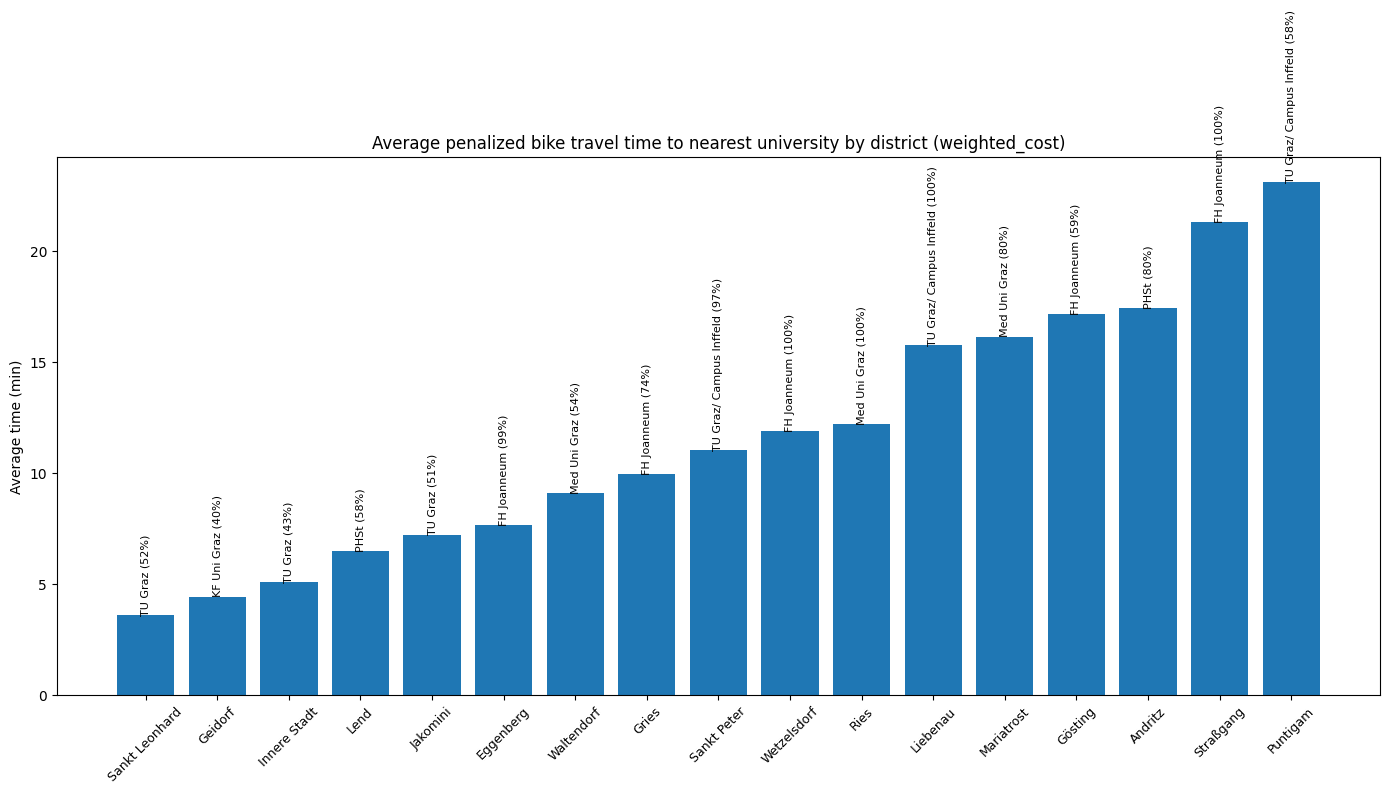

District  attempted_nodes  routed_nodes  success_rate  avg_cost_s  \
0  Sankt Leonhard              828           826      0.997585  215.090250   
1         Geidorf             1537          1534      0.998048  264.643871   
2    Innere Stadt              585           552      0.943590  304.237489   
3            Lend             1128          1125      0.997340  388.677366   
4        Jakomini             1224          1216      0.993464  432.126121   

   min_cost_s  max_cost_s    weight_type  \
0    0.000000  441.466984  weighted_cost   
1    0.000000  605.735495  weighted_cost   
2  111.114023  547.526094  weighted_cost   
3   34.317557  743.089829  weighted_cost   
4    0.000000  805.263585  weighted_cost   

                                              routes  avg_cost_min  \
0  [{'origin_node': 20832657, 'uni_node': 1245921...      3.584837   
1  [{'origin_node': 921579363, 'uni_node': 773222...      4.410731   
2  [{'origin_node': 20911117, 'uni_node': 4113732...      5.070625   
3  [{'origin_node': 20832681, 'uni_node': 1338451...      6.477956   
4  [{'origin_node': 331467889, 'uni_node': 124592...      7.202102   

   min_cost_min  max_cost_min    uni_label  share_pct  
0      0.000000      7.357783      TU Graz       51.8  
1      0.000000     10.095592  KF Uni Graz       40.2  
2      1.851900      9.125435      TU Graz       42.6  
3      0.571959     12.384830         PHSt       57.6  
4      0.000000     13.421060      TU Graz       51.3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# District routing (weighted_cost) + summary + labeled bar chart
# weighted_cost is in seconds -> we plot minutes
# ------------------------------------------------------------

weight_type = "weighted_cost"

district_results_w = {}

for district_name, nodes_in_district in nodes_by_district.items():
    attempted_nodes = len(nodes_in_district)
    routed_nodes = 0
    costs_s = []
    routes_data = []

    for origin_node in nodes_in_district:
        res = find_nearest_uni_fast(
            origin_node, all_uni_node_ids, uni_distance_maps, weight_type=weight_type
        )
        if res is None:
            continue

        routed_nodes += 1
        cost_s = float(res["cost"])  # seconds
        uni_node = res["uni_node"]
        uni_short = uni_node_to_short.get(uni_node, str(uni_node))

        costs_s.append(cost_s)
        routes_data.append({
            "origin_node": origin_node,
            "uni_node": uni_node,
            "uni_shortname": uni_short,
            "cost_s": cost_s,
            "district": district_name,
        })

    district_results_w[district_name] = {
        "attempted_nodes": attempted_nodes,
        "routed_nodes": routed_nodes,
        "success_rate": (routed_nodes / attempted_nodes) if attempted_nodes > 0 else np.nan,
        "avg_cost_s": float(np.mean(costs_s)) if routed_nodes > 0 else np.nan,
        "min_cost_s": float(np.min(costs_s)) if routed_nodes > 0 else np.nan,
        "max_cost_s": float(np.max(costs_s)) if routed_nodes > 0 else np.nan,
        "weight_type": weight_type,
        "routes": routes_data,
    }

summary_w = (
    pd.DataFrame.from_dict(district_results_w, orient="index")
      .reset_index()
      .rename(columns={"index": "District"})
)

# seconds -> minutes (more interpretable)
summary_w["avg_cost_min"] = summary_w["avg_cost_s"] / 60.0
summary_w["min_cost_min"] = summary_w["min_cost_s"] / 60.0
summary_w["max_cost_min"] = summary_w["max_cost_s"] / 60.0

summary_w = summary_w.sort_values("avg_cost_min", ascending=True).reset_index(drop=True)

# ------------------------------------------------------------
# Top-1 nearest university per district (mode) + share (%)
# ------------------------------------------------------------
rows = []
for dname, stats in district_results_w.items():
    for r in stats.get("routes", []):
        rows.append({"District": dname, "uni_raw": r.get("uni_shortname")})

routes_df = pd.DataFrame(rows)

top_uni = (
    routes_df.dropna(subset=["uni_raw"])
             .groupby(["District", "uni_raw"])
             .size()
             .reset_index(name="n")
             .sort_values(["District", "n"], ascending=[True, False])
)

top1 = top_uni.groupby("District").head(1).copy()
totals = routes_df.groupby("District").size().reset_index(name="n_total")
top1 = top1.merge(totals, on="District", how="left")
top1["share_pct"] = (top1["n"] / top1["n_total"] * 100).round(1)

# If your uni_shortname values are still truncated/addresses, map them to nice labels via prefix
prefix_map = {
    "Universitätsplatz": "KF Uni Graz",
    "Rechbauerstraße 12": "TU Graz",
    "Neue Stiftingtal": "Med Uni Graz",
    "Leonhardstraße 15": "KUG",
    "Körblergasse 126": "Campus02",
    "Alte Poststraße 14": "FH Joanneum",
    "Alte Poststraße 149": "FH Joanneum",
    "Hasnerplatz 12": "PHSt",
    "Inffeldgasse 25": "TU Graz/ Campus Inffeld",
}

def map_by_prefix(s):
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return s
    s = str(s).strip()
    for pref, lab in prefix_map.items():
        if s.startswith(pref):
            return lab
    return s

top1["uni_label"] = top1["uni_raw"].apply(map_by_prefix)

# merge labels into summary
plot_df_w = summary_w.merge(top1[["District", "uni_label", "share_pct"]], on="District", how="left")
plot_df_w = plot_df_w.sort_values("avg_cost_min", ascending=True).reset_index(drop=True)

# ------------------------------------------------------------
# Bar chart (minutes)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(plot_df_w["District"], plot_df_w["avg_cost_min"])

ax.set_title("Average penalized bike travel time to nearest university by district (weighted_cost)")
ax.set_ylabel("Average time (min)")
ax.tick_params(axis="x", rotation=45, labelsize=9)

for rect, uni, share in zip(bars, plot_df_w["uni_label"], plot_df_w["share_pct"]):
    label = "" if pd.isna(uni) else f"{uni} ({share:.0f}%)"
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height(),
        label,
        ha="center",
        va="bottom",
        rotation=90,
        fontsize=8
    )

plt.tight_layout()
plt.show()

plot_df_w.head()


## Results: Comparison
Across both metrics, the overall spatial pattern is consistent: central districts have the best accessibility, while peripheral districts show the highest costs. In the length-based results, average network distances range from roughly ~0.8–1.2 km in the most central districts (e.g., Sankt Leonhard, Geidorf, Innere Stadt) up to ~5 km+ in the outer districts (notably Puntigam and Straßgang, with Andritz/Gösting/Mariatrost also relatively high).
Using weighted_cost (penalized travel time) preserves this ranking but changes the interpretation from “how far” to “how difficult/slow (given penalties)”. Average penalized times span approximately ~4–6 minutes in the best-performing central districts and rise to about ~20–23 minutes in the worst-performing outer districts. This indicates that route penalties (e.g., less favorable infrastructure, slower links, or higher-risk segments) amplify differences between districts: areas that are already far in pure distance also tend to incur disproportionately high time costs under the weighted model.
The labels above bars show the dominant nearest university for each district and the share of routed origin nodes for which that university is the nearest option. High shares (often ~100%) suggest a clear catchment dominated by a single university, whereas lower shares (e.g., ~40–60% in some central districts) indicate mixed catchments where different parts of the district are closest to different universities.

## Sensitivity Analysis

We perform a scenario-based sensitivity analysis by comparing routing outcomes under two impedance models: pure network distance (length) versus a penalized travel-time cost (weighted_cost). Differences in route choice and aggregated accessibility metrics indicate how sensitive conclusions are to the chosen cost model.

In [ ]:
import pandas as pd

def looks_like_district_results(obj):
    if not isinstance(obj, dict) or len(obj) == 0:
        return False
    k = next(iter(obj.keys()))
    v = obj.get(k, None)
    if not isinstance(v, dict):
        return False
    needed = {"attempted_nodes", "routed_nodes", "avg_cost", "min_cost", "max_cost", "weight_type", "routes"}
    return needed.issubset(set(v.keys()))

candidates = []

# iterate over a snapshot to avoid "dictionary changed size" errors
for name, obj in list(globals().items()):
    if looks_like_district_results(obj):
        k = next(iter(obj.keys()))
        wt = obj[k].get("weight_type")
        n_districts = len(obj)
        n_routes = sum(len(s.get("routes", [])) for s in obj.values())

        # peek route keys (first available route)
        rk = set()
        for s in obj.values():
            if s.get("routes"):
                rk = set(s["routes"][0].keys())
                break

        candidates.append((name, wt, n_districts, n_routes, sorted(rk)))

df_candidates = pd.DataFrame(
    candidates,
    columns=["var_name", "weight_type", "n_districts", "n_routes", "route_keys_sample"]
).sort_values(["weight_type", "var_name"])

df_candidates


var_name weight_type  n_districts  n_routes  \
0  district_results      length           17     22071   

                                   route_keys_sample  
0  [cost, district, origin_node, uni_node, uni_sh...

In [ ]:
district_results_len = district_results


In [ ]:
import numpy as np
import pandas as pd

weight_type = "weighted_cost"   # <- NOW weighted

district_results_w = {}

for district_name, nodes_in_district in nodes_by_district.items():
    attempted_nodes = len(nodes_in_district)
    routed_nodes = 0
    costs = []
    routes_data = []

    for origin_node in nodes_in_district:
        res = find_nearest_uni_fast(
            origin_node, all_uni_node_ids, uni_distance_maps, weight_type=weight_type
        )
        if res is None:
            continue

        routed_nodes += 1
        cost_s = float(res["cost"])  # seconds
        uni_node = res["uni_node"]
        uni_short = uni_node_to_short.get(uni_node, str(uni_node))

        costs.append(cost_s)
        routes_data.append({
            "origin_node": origin_node,
            "uni_node": uni_node,
            "uni_shortname": uni_short,
            "cost_s": cost_s,
            "district": district_name,
        })

    district_results_w[district_name] = {
        "attempted_nodes": attempted_nodes,
        "routed_nodes": routed_nodes,
        "success_rate": (routed_nodes / attempted_nodes) if attempted_nodes > 0 else np.nan,
        "avg_cost": float(np.mean(costs)) if routed_nodes > 0 else np.nan,
        "min_cost": float(np.min(costs)) if routed_nodes > 0 else np.nan,
        "max_cost": float(np.max(costs)) if routed_nodes > 0 else np.nan,
        "weight_type": weight_type,
        "routes": routes_data,
    }

summary_df_w = (
    pd.DataFrame.from_dict(district_results_w, orient="index")
      .reset_index()
      .rename(columns={"index": "District"})
      .sort_values("avg_cost", ascending=True)
)

summary_df_w.head()


District  attempted_nodes  routed_nodes  success_rate    avg_cost  \
12  Sankt Leonhard              828           826      0.997585  215.090250   
2          Geidorf             1537          1534      0.998048  264.643871   
5     Innere Stadt              585           552      0.943590  304.237489   
7             Lend             1128          1125      0.997340  388.677366   
6         Jakomini             1224          1216      0.993464  432.126121   

      min_cost    max_cost    weight_type  \
12    0.000000  441.466984  weighted_cost   
2     0.000000  605.735495  weighted_cost   
5   111.114023  547.526094  weighted_cost   
7    34.317557  743.089829  weighted_cost   
6     0.000000  805.263585  weighted_cost   

                                               routes  
12  [{'origin_node': 20832657, 'uni_node': 1245921...  
2   [{'origin_node': 921579363, 'uni_node': 773222...  
5   [{'origin_node': 20911117, 'uni_node': 4113732...  
7   [{'origin_node': 20832681, 'uni_node': 1338451...  
6   [{'origin_node': 331467889, 'uni_node': 124592...

In [ ]:
import pandas as pd
import numpy as np

# build df for length
rows = []
for d, stats in district_results_len.items():
    for r in stats.get("routes", []):
        rows.append({
            "district": d,
            "origin_node": r["origin_node"],
            "uni_node": r["uni_node"],
            "uni_shortname": r.get("uni_shortname"),
            "dist_m": r.get("cost")  # length uses "cost" in meters
        })
df_len = pd.DataFrame(rows)
df_len["dist_m"] = pd.to_numeric(df_len["dist_m"], errors="coerce")

# build df for weighted
rows = []
for d, stats in district_results_w.items():
    for r in stats.get("routes", []):
        rows.append({
            "district": d,
            "origin_node": r["origin_node"],
            "uni_node": r["uni_node"],
            "uni_shortname": r.get("uni_shortname"),
            "time_s": r.get("cost_s", r.get("cost"))  # weighted uses cost_s or cost
        })
df_w = pd.DataFrame(rows)
df_w["time_s"] = pd.to_numeric(df_w["time_s"], errors="coerce")
df_w["time_min"] = df_w["time_s"] / 60.0

# merge
df = df_len.merge(df_w, on=["district", "origin_node", "uni_node"], suffixes=("_len", "_w"))
df = df.dropna(subset=["dist_m", "time_min"])
df = df[df["dist_m"] > 0].copy()
df["min_per_km"] = df["time_min"] / (df["dist_m"] / 1000.0)

df.head()


district  origin_node   uni_node   uni_shortname_len       dist_m  \
0  Andritz     20929508  773222019  Hasnerplatz 12, 80  2822.674381   
1  Andritz   1475042222  773222019  Hasnerplatz 12, 80  2828.022476   
2  Andritz    269023910  773222019  Hasnerplatz 12, 80  2827.467659   
3  Andritz     82687995  773222019  Hasnerplatz 12, 80  2990.363744   
4  Andritz   1475042217  773222019  Hasnerplatz 12, 80  2785.985437   

      uni_shortname_w      time_s   time_min  min_per_km  
0  Hasnerplatz 12, 80  707.314117  11.788569    4.176383  
1  Hasnerplatz 12, 80  706.030477  11.767175    4.160920  
2  Hasnerplatz 12, 80  707.383940  11.789732    4.169714  
3  Hasnerplatz 12, 80  749.736103  12.495602    4.178623  
4  Hasnerplatz 12, 80  694.866000  11.581100    4.156913

In [ ]:
import numpy as np
import pandas as pd

df2 = df.copy()

# numeric safety
df2["dist_m"] = pd.to_numeric(df2["dist_m"], errors="coerce")
df2["time_min"] = pd.to_numeric(df2["time_min"], errors="coerce")

df2 = df2.dropna(subset=["dist_m", "time_min"]).copy()
df2 = df2[df2["dist_m"] > 0].copy()

# Penalized effort (min per km)
df2["min_per_km"] = df2["time_min"] / (df2["dist_m"] / 1000.0)

# Candidates:
cand_sensitive = df2.sort_values("min_per_km", ascending=False).head(10)
cand_stable    = df2.sort_values("min_per_km", ascending=True).head(10)
cand_far       = df2.sort_values("dist_m", ascending=False).head(10)

print("Top 10 most 'sensitive' (highest min/km):")
display(cand_sensitive[["district","origin_node","uni_node","dist_m","time_min","min_per_km","uni_shortname_w"]])

print("Top 10 most 'stable/efficient' (lowest min/km):")
display(cand_stable[["district","origin_node","uni_node","dist_m","time_min","min_per_km","uni_shortname_w"]])

print("Top 10 farthest (largest distance):")
display(cand_far[["district","origin_node","uni_node","dist_m","time_min","min_per_km","uni_shortname_w"]])


Top 10 most 'sensitive' (highest min/km):


district  origin_node     uni_node       dist_m   time_min  min_per_km  \
6856    Gösting    224112678    773222019  6973.170191  51.245559    7.348961   
7386    Gösting    870236335    773222019  5956.828474  39.210475    6.582442   
6663    Gösting   2206381381    773222019  5907.927652  38.631190    6.538873   
7387    Gösting   2497049538    773222019  6077.710112  39.694149    6.531103   
7548    Gösting  10148348267    773222019  6001.099620  39.004893    6.499624   
6444      Gries   1248411259  13384518939    90.012751   0.501276    5.568950   
3628  Eggenberg  13387757515  13384518939    99.740328   0.555443    5.568889   
3640  Eggenberg  13387757516  13384518939   102.249849   0.569417    5.568874   
3590  Eggenberg  13387757520  13384518939   106.951870   0.595597    5.568836   
3659  Eggenberg   1908136869  13384518939   179.792877   1.001203    5.568647   

         uni_shortname_w  
6856  Hasnerplatz 12, 80  
7386  Hasnerplatz 12, 80  
6663  Hasnerplatz 12, 80  
7387  Hasnerplatz 12, 80  
7548  Hasnerplatz 12, 80  
6444  Alte Poststraße 14  
3628  Alte Poststraße 14  
3640  Alte Poststraße 14  
3590  Alte Poststraße 14  
3659  Alte Poststraße 14

Top 10 most 'stable/efficient' (lowest min/km):


district  origin_node     uni_node      dist_m  time_min  \
3909       Geidorf   3871900090   3871900100   83.927724  0.335720   
4043       Geidorf   2510384949   3871900100  401.911043  1.607700   
3906       Geidorf   3871900081   3871900100  109.721943  0.438907   
4374       Geidorf   3871900083   3871900100   93.318342  0.373290   
3911       Geidorf   1056970989   3871900100  259.805164  1.039272   
3907       Geidorf    299759662   3871900100  256.624850  1.026551   
3910       Geidorf   3871900078   3871900100  118.970313  0.475906   
3908       Geidorf   3871900061   3871900100  237.942629  0.951822   
16348  Sankt Peter     20841233  12459216275  407.103929  1.628505   
8095      Jakomini   1865577187  12459216275  106.494532  0.426002   

       min_per_km     uni_shortname_w  
3909     4.000110  Universitätsplatz   
4043     4.000139  Universitätsplatz   
3906     4.000176  Universitätsplatz   
4374     4.000183  Universitätsplatz   
3911     4.000198  Universitätsplatz   
3907     4.000201  Universitätsplatz   
3910     4.000207  Universitätsplatz   
3908     4.000216  Universitätsplatz   
16348    4.000220  Inffeldgasse 25, 8  
8095     4.000224  Inffeldgasse 25, 8

Top 10 farthest (largest distance):


district  origin_node     uni_node       dist_m   time_min  min_per_km  \
1600  Andritz   1133762833    773222019  8094.398111  34.320804    4.240069   
1077  Andritz    291384175    773222019  8047.948632  34.161108    4.244698   
1601  Andritz   4605723970    773222019  7999.668411  33.939895    4.242663   
1081  Andritz   4605723968    773222019  7961.676028  33.786859    4.243687   
1599  Andritz   2104936966    773222019  7946.760361  33.726611    4.244070   
1080  Andritz   2104936969    773222019  7937.412560  33.688890    4.244316   
1078  Andritz    328077148    773222019  7916.914616  33.606772    4.244933   
7278  Gösting    327771040  13384518939  7914.912530  35.531018    4.489123   
7279  Gösting   1327328187  13384518939  7858.539175  35.305518    4.492631   
1597  Andritz   2104936991    773222019  7814.847831  33.196616    4.247890   

         uni_shortname_w  
1600  Hasnerplatz 12, 80  
1077  Hasnerplatz 12, 80  
1601  Hasnerplatz 12, 80  
1081  Hasnerplatz 12, 80  
1599  Hasnerplatz 12, 80  
1080  Hasnerplatz 12, 80  
1078  Hasnerplatz 12, 80  
7278  Alte Poststraße 14  
7279  Alte Poststraße 14  
1597  Hasnerplatz 12, 80

In [ ]:
examples = [
    {"label": "stable",    "district": "Geidorf",  "origin_node": 3871900090, "uni_node": 3871900100},
    {"label": "sensitive", "district": "Gösting",  "origin_node": 224112678,  "uni_node": 773222019},
    {"label": "far",       "district": "Andritz",  "origin_node": 1133762833, "uni_node": 773222019},
]
examples


[{'label': 'stable',
  'district': 'Geidorf',
  'origin_node': 3871900090,
  'uni_node': 3871900100},
 {'label': 'sensitive',
  'district': 'Gösting',
  'origin_node': 224112678,
  'uni_node': 773222019},
 {'label': 'far',
  'district': 'Andritz',
  'origin_node': 1133762833,
  'uni_node': 773222019}]

In [ ]:
cand_sensitive_clean = df2[df2["dist_m"] > 1000].sort_values("min_per_km", ascending=False).head(10)
cand_sensitive_clean


district  origin_node   uni_node   uni_shortname_len       dist_m  \
6856  Gösting    224112678  773222019  Hasnerplatz 12, 80  6973.170191   
7386  Gösting    870236335  773222019  Hasnerplatz 12, 80  5956.828474   
6663  Gösting   2206381381  773222019  Hasnerplatz 12, 80  5907.927652   
7387  Gösting   2497049538  773222019  Hasnerplatz 12, 80  6077.710112   
7548  Gösting  10148348267  773222019  Hasnerplatz 12, 80  6001.099620   
6659  Gösting   1957327587  773222019  Hasnerplatz 12, 80  4801.044350   
6662  Gösting   1957327593  773222019  Hasnerplatz 12, 80  4808.599563   
6657  Gösting     21100088  773222019  Hasnerplatz 12, 80  4794.693697   
7547  Gösting   8231514648  773222019  Hasnerplatz 12, 80  4854.753937   
4389  Geidorf  12568910636  773222019  Hasnerplatz 12, 80  1288.881059   

         uni_shortname_w       time_s   time_min  min_per_km  
6856  Hasnerplatz 12, 80  3074.733541  51.245559    7.348961  
7386  Hasnerplatz 12, 80  2352.628528  39.210475    6.582442  
6663  Hasnerplatz 12, 80  2317.871379  38.631190    6.538873  
7387  Hasnerplatz 12, 80  2381.648969  39.694149    6.531103  
7548  Hasnerplatz 12, 80  2340.293585  39.004893    6.499624  
6659  Hasnerplatz 12, 80  1531.473666  25.524561    5.316460  
6662  Hasnerplatz 12, 80  1533.287001  25.554783    5.314392  
6657  Hasnerplatz 12, 80  1526.960591  25.449343    5.307814  
7547  Hasnerplatz 12, 80  1544.580238  25.743004    5.302638  
4389  Hasnerplatz 12, 80   409.877609   6.831293    5.300174

### some tests

In [ ]:
#for ex in examples:
    #ex["origin_node"] = int(ex["origin_node"])
    #ex["uni_node"] = int(ex["uni_node"])


In [ ]:
#for ex in examples:
    #assert "origin_node" in ex and "uni_node" in ex
    #ex["origin_node"] = int(ex["origin_node"])
    #ex["uni_node"] = int(ex["uni_node"])


In [ ]:
#missing = []
#for ex in examples:
    #if ex["origin_node"] not in G_core:
        #missing.append(("origin_node", ex["label"], ex["origin_node"]))
    #if ex["uni_node"] not in G_core:
        #missing.append(("uni_node", ex["label"], ex["uni_node"]))

#missing


#Go

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

# --- config ---
LEN_ATTR = "length"           # meters
TIME_ATTR = "weighted_cost"   # seconds (your detected edge attribute)

def _best_edge_data(G, u, v, weight_attr):
    """
    Returns the edge-attribute dict for the 'best' edge u->v
    (important for MultiDiGraph where multiple edges exist).
    """
    ed = G.get_edge_data(u, v, default=None)
    if ed is None:
        return None

    # MultiDiGraph: dict of keys -> attr dict
    if isinstance(ed, dict) and len(ed) > 0 and isinstance(next(iter(ed.values())), dict):
        best = None
        best_w = np.inf
        for _, data in ed.items():
            w = data.get(weight_attr, np.inf)
            try:
                w = float(w)
            except Exception:
                w = np.inf
            if w < best_w:
                best_w = w
                best = data
        return best

    # DiGraph: already an attr dict
    return ed


def path_sums(G, path_nodes, time_attr=None):
    """
    Returns: (total_length_m, total_time_s)
    """
    if time_attr is None:
        time_attr = TIME_ATTR

    total_m = 0.0
    total_s = 0.0

    for a, b in zip(path_nodes[:-1], path_nodes[1:]):
        data = _best_edge_data(G, a, b, weight_attr=time_attr)
        if data is None:
            return np.nan, np.nan

        if LEN_ATTR not in data or time_attr not in data:
            return np.nan, np.nan

        total_m += float(data[LEN_ATTR])
        total_s += float(data[time_attr])

    return total_m, total_s


def compute_two_paths(G, origin, dest, time_attr=None):
    """
    Computes:
      - shortest by length
      - shortest by weighted time (weighted_cost)
    and returns metrics for both.
    """
    if time_attr is None:
        time_attr = TIME_ATTR

    out = {}

    # length-optimal path
    try:
        p_len = nx.shortest_path(G, origin, dest, weight=LEN_ATTR)
        len_m, time_s = path_sums(G, p_len, time_attr=time_attr)
        out["p_len"] = p_len
        out["len_m_on_lenpath"] = len_m
        out["time_s_on_lenpath"] = time_s
    except nx.NetworkXNoPath:
        out["p_len"] = None
        out["len_m_on_lenpath"] = np.nan
        out["time_s_on_lenpath"] = np.nan

    # time-optimal path
    try:
        p_w = nx.shortest_path(G, origin, dest, weight=time_attr)
        len_m, time_s = path_sums(G, p_w, time_attr=time_attr)
        out["p_w"] = p_w
        out["len_m_on_wpath"] = len_m
        out["time_s_on_wpath"] = time_s
    except nx.NetworkXNoPath:
        out["p_w"] = None
        out["len_m_on_wpath"] = np.nan
        out["time_s_on_wpath"] = np.nan

    return out


In [ ]:
print(type(examples[0]))
print(examples[0])
# falls dict:
if isinstance(examples[0], dict):
    print(examples[0].keys())


<class 'dict'>
{'label': 'stable', 'district': 'Geidorf', 'origin_node': 3871900090, 'uni_node': 3871900100}
dict_keys(['label', 'district', 'origin_node', 'uni_node'])


In [ ]:
def core_node(short_name):
    return int(unis_proj.loc[unis_proj["short_name"] == short_name, "core_node"].iloc[0])

route_examples = [
    {"label": "KF Uni -> TU Inffeld", "district": "",
     "origin_node": core_node("KF Uni Graz"),
     "uni_node": core_node("TU Graz/ Campus Inffeld")},

    {"label": "KF Uni -> Med Uni", "district": "",
     "origin_node": core_node("KF Uni Graz"),
     "uni_node": core_node("Med Uni Graz")},

    {"label": "FH Joanneum -> TU Graz", "district": "",
     "origin_node": core_node("FH Joanneum"),
     "uni_node": core_node("TU Graz")},
]


In [ ]:
rows = []

for ex in route_examples:
    label = ex.get("label", "")
    district = ex.get("district", "")
    origin = int(ex["origin_node"])
    uni = int(ex["uni_node"])

    res = compute_two_paths(G_core, origin, uni)

    # Convert seconds to minutes
    lenpath_min = res["time_s_on_lenpath"] / 60.0 if pd.notna(res["time_s_on_lenpath"]) else np.nan
    wpath_min   = res["time_s_on_wpath"]   / 60.0 if pd.notna(res["time_s_on_wpath"]) else np.nan

    # Penalized minutes per km (effort intensity)
    min_per_km_lenpath = (lenpath_min / (res["len_m_on_lenpath"]/1000.0)) if pd.notna(res["len_m_on_lenpath"]) and res["len_m_on_lenpath"] > 0 else np.nan
    min_per_km_wpath   = (wpath_min   / (res["len_m_on_wpath"]/1000.0))   if pd.notna(res["len_m_on_wpath"]) and res["len_m_on_wpath"] > 0 else np.nan

    # Deltas: weighted-optimal minus length-optimal
    delta_len_m  = res["len_m_on_wpath"] - res["len_m_on_lenpath"]
    delta_time_s = res["time_s_on_wpath"] - res["time_s_on_lenpath"]

    rows.append({
        "label": label,
        "district": district,
        "origin_node": origin,
        "uni_node": uni,

        "len_path_m": res["len_m_on_lenpath"],
        "len_path_time_min": lenpath_min,
        "len_path_min_per_km": min_per_km_lenpath,

        "weighted_path_m": res["len_m_on_wpath"],
        "weighted_path_time_min": wpath_min,
        "weighted_path_min_per_km": min_per_km_wpath,

        "delta_m (w - len)": delta_len_m,
        "delta_time_min (w - len)": (delta_time_s / 60.0) if pd.notna(delta_time_s) else np.nan,

        "n_nodes_lenpath": (len(res["p_len"]) if res.get("p_len") is not None else 0),
        "n_nodes_wpath":   (len(res["p_w"])   if res.get("p_w")   is not None else 0),


    })

df_compare = pd.DataFrame(rows)
df_compare


label district  origin_node     uni_node   len_path_m  \
0    KF Uni -> TU Inffeld            3871900100  12459216275  3176.799488   
1       KF Uni -> Med Uni            3871900100    266012637  1911.125944   
2  FH Joanneum -> TU Graz           13384518939   4113732444  3836.045895   

   len_path_time_min  len_path_min_per_km  weighted_path_m  \
0          14.440225             4.545526      3176.799488   
1           8.501115             4.448223      1922.818455   
2          18.591728             4.846586      4013.531986   

   weighted_path_time_min  weighted_path_min_per_km  delta_m (w - len)  \
0               14.440225                  4.545526           0.000000   
1                8.459398                  4.399478          11.692511   
2               17.488970                  4.357501         177.486091   

   delta_time_min (w - len)  n_nodes_lenpath  n_nodes_wpath  
0                  0.000000               67             67  
1                 -0.041717               34             33  
2                 -1.102757               80             88

In [ ]:
sens = df_compare.copy()
sens["len_km"] = sens["len_path_m"] / 1000
sens["w_km"]   = sens["weighted_path_m"] / 1000

sens = sens[[
    "label",
    "len_km", "len_path_time_min",
    "w_km",   "weighted_path_time_min",
    "delta_m (w - len)", "delta_time_min (w - len)"
]].round(2)

sens


label  len_km  len_path_time_min  w_km  \
0    KF Uni -> TU Inffeld    3.18              14.44  3.18   
1       KF Uni -> Med Uni    1.91               8.50  1.92   
2  FH Joanneum -> TU Graz    3.84              18.59  4.01   

   weighted_path_time_min  delta_m (w - len)  delta_time_min (w - len)  
0                   14.44               0.00                      0.00  
1                    8.46              11.69                     -0.04  
2                   17.49             177.49                     -1.10

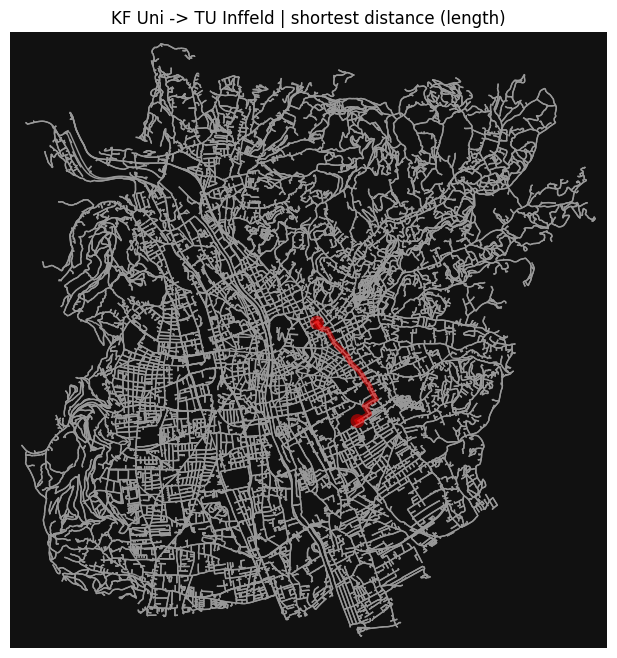

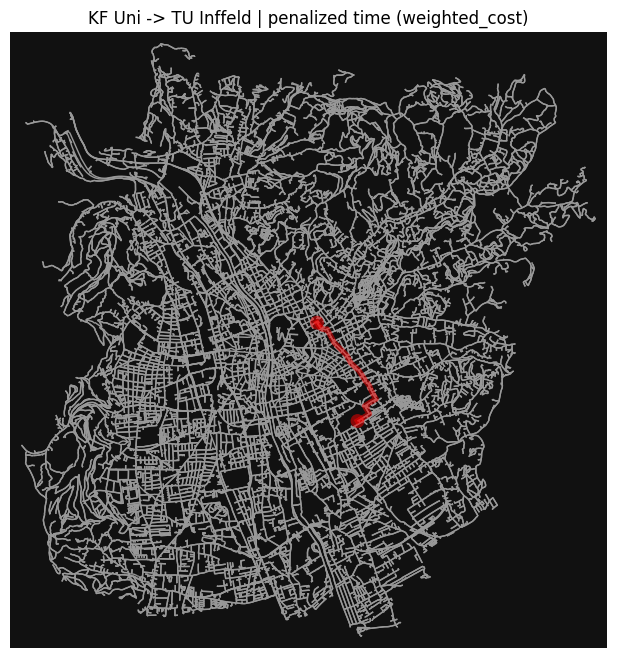

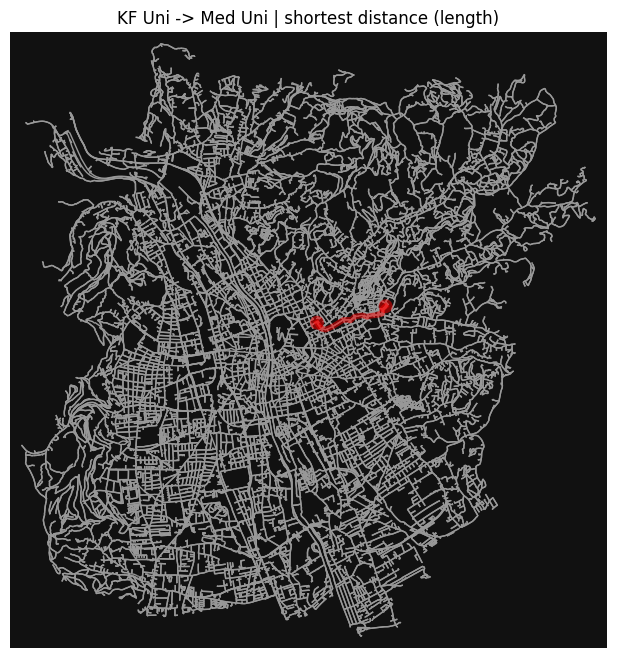

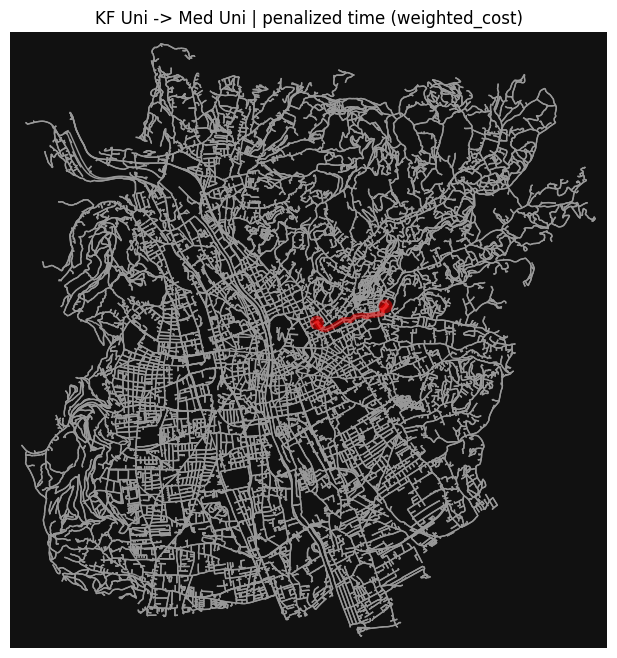

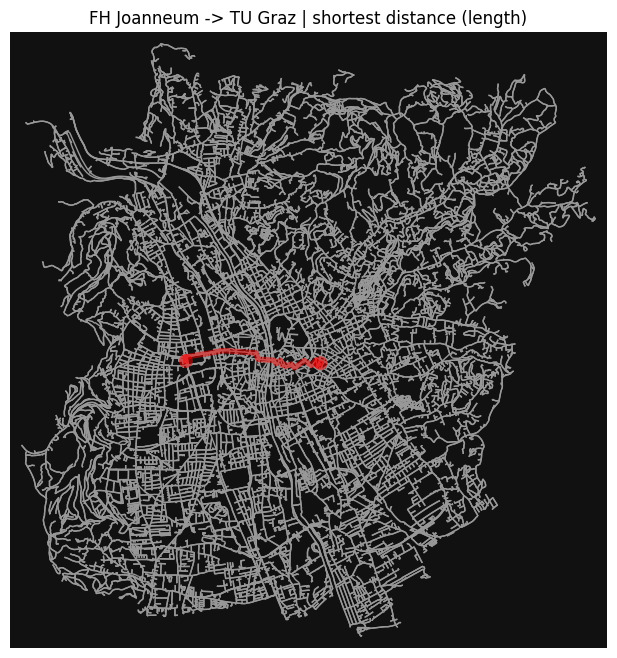

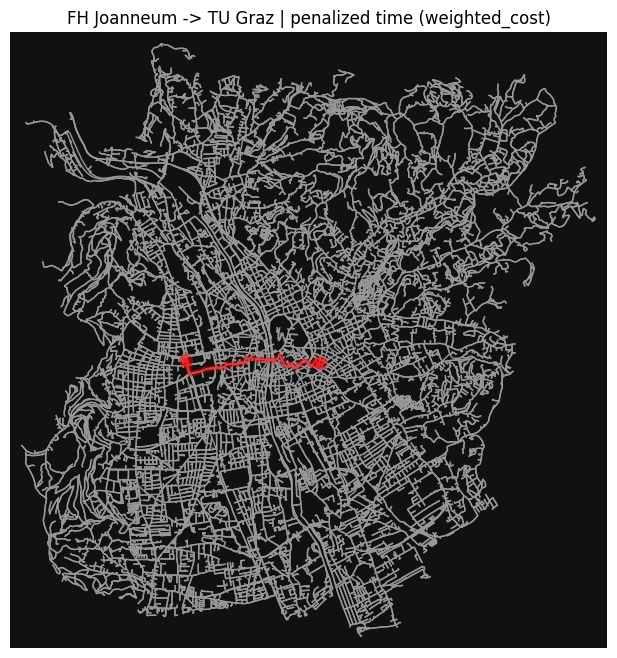

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

pairs = [
    ("KF Uni -> TU Inffeld", "KF Uni Graz", "TU Graz/ Campus Inffeld"),
    ("KF Uni -> Med Uni", "KF Uni Graz", "Med Uni Graz"),
    ("FH Joanneum -> TU Graz", "FH Joanneum", "TU Graz"),
]

def node_of(short_name):
    return int(graz_unis_proj.loc[graz_unis_proj["short_name"]==short_name, "core_node"].iloc[0])

for label, a, b in pairs:
    o = node_of(a)
    d = node_of(b)

    p_len = nx.shortest_path(G_core, o, d, weight="length")
    p_w   = nx.shortest_path(G_core, o, d, weight="weighted_cost")

    fig, ax = ox.plot_graph_route(G_core, p_len, node_size=0, route_linewidth=4, show=False, close=False)
    ax.set_title(f"{label} | shortest distance (length)")
    plt.show()

    fig, ax = ox.plot_graph_route(G_core, p_w, node_size=0, route_linewidth=4, show=False, close=False)
    ax.set_title(f"{label} | penalized time (weighted_cost)")
    plt.show()


In [ ]:
import numpy as np
import pandas as pd

def route_edge_stats(G, path):
    rows = []
    for u, v in zip(path[:-1], path[1:]):
        ed = G.get_edge_data(u, v)
        # MultiDiGraph: choose the edge with minimal weighted_cost
        if isinstance(ed, dict) and isinstance(next(iter(ed.values())), dict):
            data = min(ed.values(), key=lambda d: float(d.get("weighted_cost", np.inf)))
        else:
            data = ed

        rows.append({
            "length": float(data.get("length", np.nan)),
            "weighted_cost": float(data.get("weighted_cost", np.nan)),
            "has_tramway": bool(data.get("has_tramway", False)),
            "speed_limit_kmh": float(data.get("speed_limit_kmh", np.nan)),
            "slope_pct": float(data.get("slope_pct", np.nan)),
        })

    df = pd.DataFrame(rows)
    return {
        "km": df["length"].sum()/1000,
        "w_min": df["weighted_cost"].sum()/60,
        "tram_share": (df["length"][df["has_tramway"]].sum()/df["length"].sum()) if df["length"].sum()>0 else np.nan,
        "mean_speed_limit": np.nanmean(df["speed_limit_kmh"]),
        "p90_slope": np.nanpercentile(np.abs(df["slope_pct"]), 90),
    }

# Example for one pair:
o = int(graz_unis_proj.loc[graz_unis_proj["short_name"]=="FH Joanneum","core_node"].iloc[0])
d = int(graz_unis_proj.loc[graz_unis_proj["short_name"]=="TU Graz","core_node"].iloc[0])

p_len = nx.shortest_path(G_core, o, d, weight="length")
p_w   = nx.shortest_path(G_core, o, d, weight="weighted_cost")

stats_len = route_edge_stats(G_core, p_len)
stats_w   = route_edge_stats(G_core, p_w)

pd.DataFrame([stats_len, stats_w], index=["len_path", "weighted_path"])


km      w_min  tram_share  mean_speed_limit  p90_slope
len_path       3.836046  18.591728    0.615222         35.063291   3.498657
weighted_path  4.013532  17.488970    0.299089         30.114943   2.707355

### Result
The weighted-cost route is slightly longer, but yields a lower generalized cost because it substantially reduces tram-adjacent segments, uses roads with lower traffic-speed proxy, and avoids steeper sections.

## Analysis 3 ROUTES
We select three representative origin locations from a 300 m grid covering the city of Graz (low / median / high penalized effort) and compare shortest-distance and penalized-time optimal bicycle routes to the nearest university.

Minutes per kilometer (penalized travel time normalized by network distance) was selected as the primary comparison metric because it allows accessibility to be evaluated independently of absolute distance to the destination. By normalizing travel time by route length, this indicator highlights relative cycling effort and reveals the influence of infrastructure- and environment-related penalties (e.g. slope, high-speed roads, tram proximity) rather than simply reflecting spatial proximity. It was therefore used to select representative grid cells for subsequent route-based comparisons, making it particularly suitable for assessing spatial patterns of network quality and cycling conditions across the study area.

In [ ]:
# --- Select 3 representative grid cells based on penalized effort (min_per_km) ---

g = gdf_grid_with_data.copy()

# Safety check
assert "min_per_km" in g.columns
assert g["min_per_km"].notna().any()

# LOW effort (best accessibility)
low_effort = g.sort_values("min_per_km", ascending=True).head(1)

# HIGH effort (worst accessibility)
high_effort = g.sort_values("min_per_km", ascending=False).head(1)

# MEDIAN effort (closest to median value)
median_value = g["min_per_km"].median()
median_effort = g.iloc[(g["min_per_km"] - median_value).abs().argsort()[:1]]

# Combine
sample_cells = (
    pd.concat([low_effort, median_effort, high_effort])
      .reset_index(drop=True)
)

sample_cells[["cell_id", "min_per_km", "avg_distance_m", "avg_weighted_time_min"]]


cell_id  min_per_km  avg_distance_m  avg_weighted_time_min
0     1350    4.000402      553.316031               2.213487
1      479    4.332864     1838.635234               7.966556
2      357    5.378911     5945.662573              31.981188

The median effort case was selected as the grid cell closest to the statistical median of the penalized effort distribution. Its value therefore reflects the central tendency of all grid cells and is not arbitrarily chosen. Higher values represent increasingly extreme conditions and are captured by the high-effort case.

In [ ]:
print(nodes_gdf.head())
print(nodes_gdf.crs)


       node_id                       geometry
0     20824406  POINT (-64117.118 211576.094)
1   1450590079  POINT (-64114.824 211640.579)
2     35127847  POINT (-64133.161 211534.196)
3   7417992109   POINT (-64124.634 211623.93)
4  10689567408  POINT (-64088.233 211628.205)
EPSG:31256


In [ ]:
from shapely.ops import nearest_points

# GeoDataFrame of network nodes already exists: nodes_gdf

sample_cells = sample_cells.copy()
sample_cells["centroid"] = sample_cells.geometry.centroid

origin_nodes = []

for _, row in sample_cells.iterrows():
    cid = row["cell_id"]
    centroid = row["centroid"]

    node_ids = nodes_by_cell.get(cid, [])
    if not node_ids:
        origin_nodes.append(np.nan)
        continue

    candidates = nodes_gdf[nodes_gdf["node_id"].isin(node_ids)].copy()
    candidates["dist"] = candidates.geometry.distance(centroid)

    origin_nodes.append(int(candidates.sort_values("dist").iloc[0]["node_id"]))

sample_cells["origin_node"] = origin_nodes
sample_cells[["cell_id", "origin_node", "min_per_km"]]


cell_id  origin_node  min_per_km
0     1350     21298444    4.000402
1      479   8000232753    4.332864
2      357  10148348267    5.378911

In [ ]:
dest_node = int(
    graz_unis_proj.loc[
        graz_unis_proj["short_name"] == "KF Uni Graz", "core_node"
    ].iloc[0]
)


In [ ]:
rows = []

labels = ["low effort", "median effort", "high effort"]

for i, row in sample_cells.iterrows():
    res = compute_two_paths(G_core, row["origin_node"], dest_node)

    rows.append({
        "case": labels[i],
        "origin_node": row["origin_node"],
        "dest_node": dest_node,

        "len_km": res["len_m_on_lenpath"] / 1000,
        "len_time_min": res["time_s_on_lenpath"] / 60,

        "weighted_km": res["len_m_on_wpath"] / 1000,
        "weighted_time_min": res["time_s_on_wpath"] / 60,

        "delta_km": (res["len_m_on_wpath"] - res["len_m_on_lenpath"]) / 1000,
        "delta_time_min": (res["time_s_on_wpath"] - res["time_s_on_lenpath"]) / 60,
    })

df_routes = pd.DataFrame(rows).round(2)
df_routes


case  origin_node   dest_node  len_km  len_time_min  weighted_km  \
0     low effort     21298444  3871900100    3.53         15.84         3.53   
1  median effort   8000232753  3871900100    5.50         24.16         5.54   
2    high effort  10148348267  3871900100    9.83         70.78        10.48   

   weighted_time_min  delta_km  delta_time_min  
0              15.84      0.00            0.00  
1              23.06      0.05           -1.10  
2              53.36      0.64          -17.42

### Result: 
In the selected cases, penalized routing resulted in only minor deviations from shortest-distance paths, indicating that the underlying network already provides relatively suitable cycling routes.

Across the three representative grid cells, differences between shortest-distance and penalized routes were small, indicating that the existing network already provides routes that are largely consistent with the penalized cost function. This suggests that elevated penalized effort in some areas is driven more by uniformly suboptimal local conditions than by the need for substantial route detours.

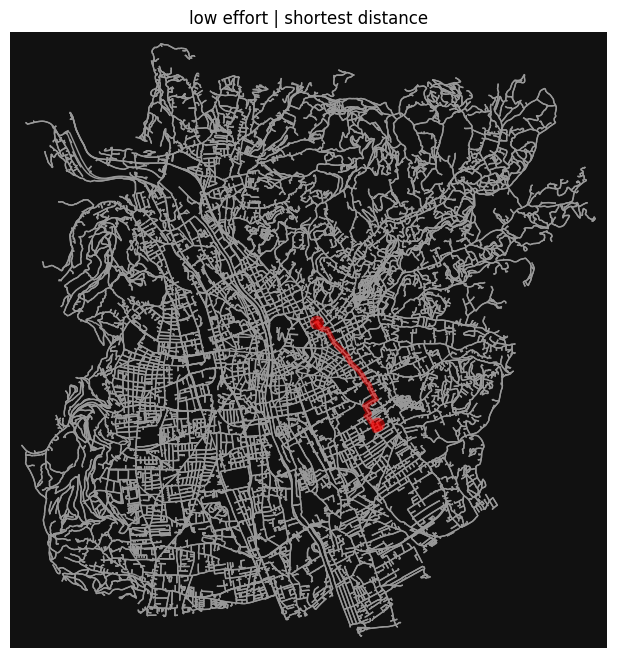

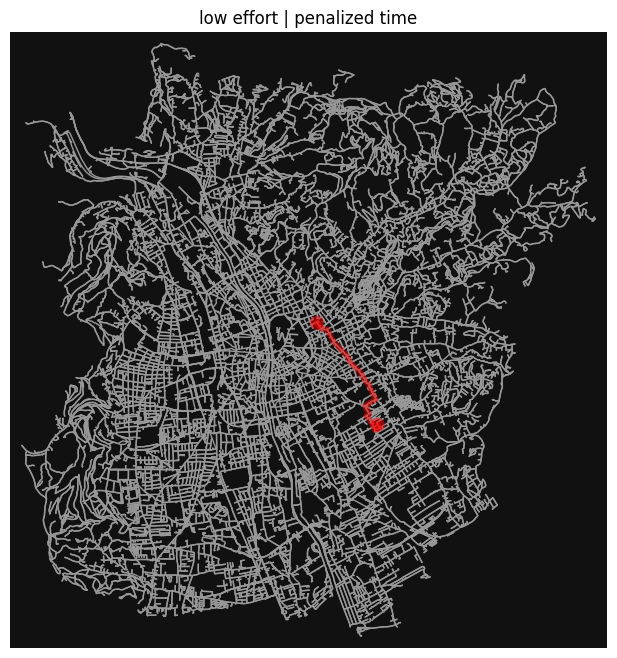

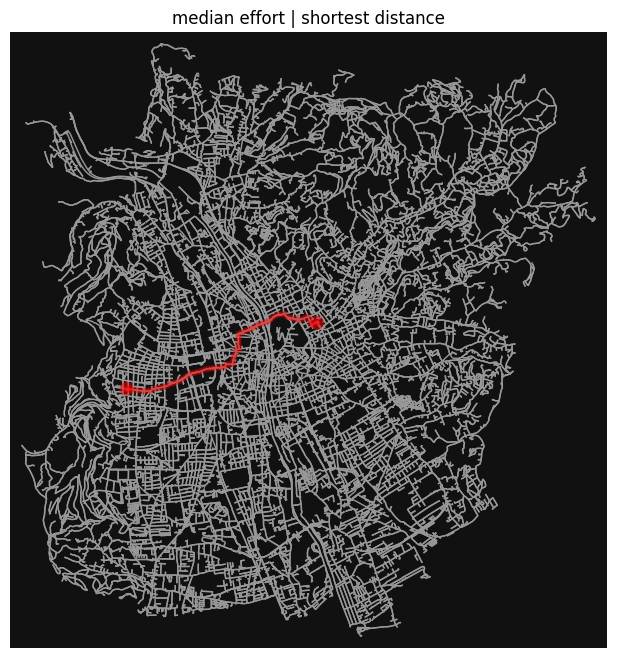

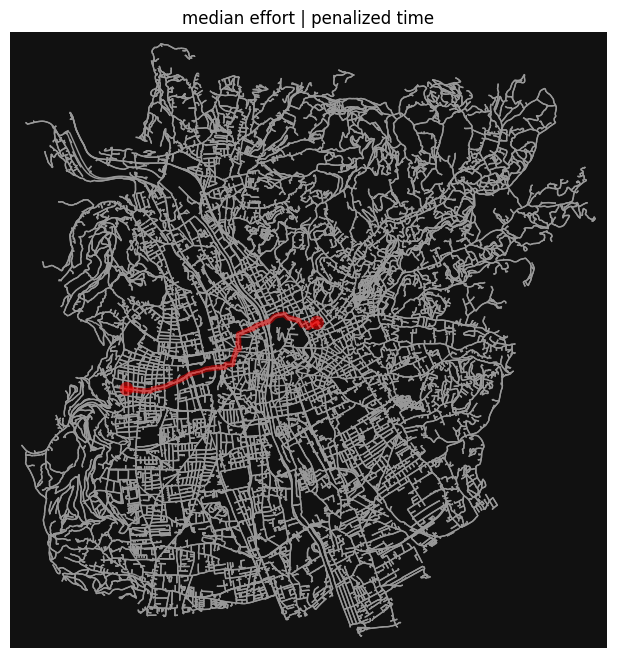

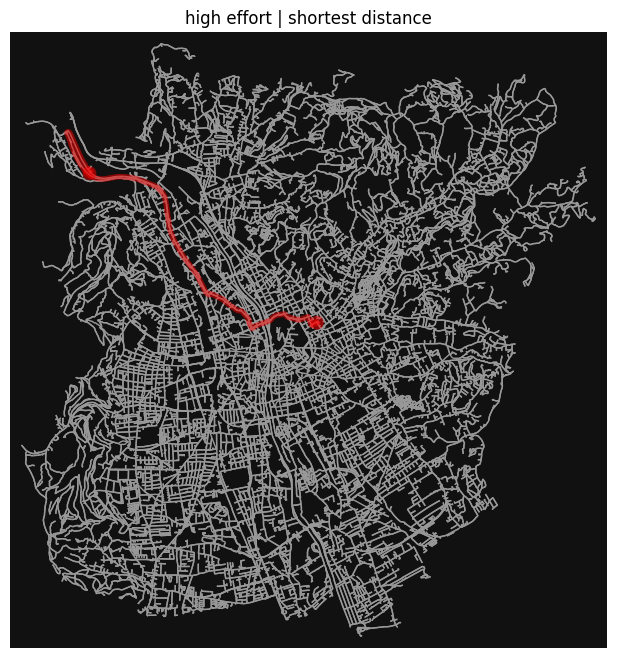

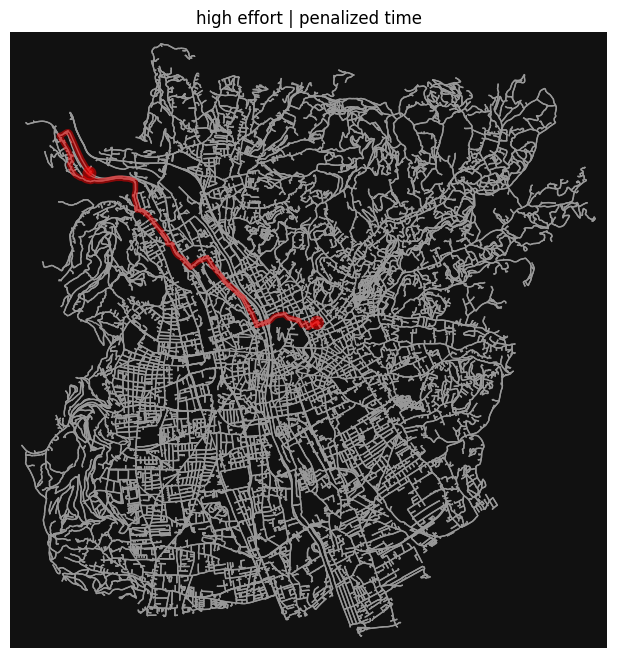

In [ ]:
import osmnx as ox

for i, row in sample_cells.iterrows():
    o = row["origin_node"]
    d = dest_node
    label = labels[i]

    p_len = nx.shortest_path(G_core, o, d, weight="length")
    p_w   = nx.shortest_path(G_core, o, d, weight="weighted_cost")

    fig, ax = ox.plot_graph_route(G_core, p_len, node_size=0,
                                  route_linewidth=4, show=False, close=False)
    ax.set_title(f"{label} | shortest distance")
    plt.show()

    fig, ax = ox.plot_graph_route(G_core, p_w, node_size=0,
                                  route_linewidth=4, show=False, close=False)
    ax.set_title(f"{label} | penalized time")
    plt.show()


In [ ]:
res = find_nearest_uni_fast(
    int(sample_cells.iloc[0]["origin_node"]),
    all_uni_node_ids,
    uni_distance_maps,
    weight_type="weighted_cost"
)

print(res)
print(res.keys())


{'uni_node': 12459216275, 'cost': 158.41287407749456, 'path': [12459216275, 1865577187, 20841237, 20841236, 20841234, 20841233, 61929326, 7989720422, 21015434, 21298447, 1765378056, 21298444]}
dict_keys(['uni_node', 'cost', 'path'])


In [ ]:
# --- Find nearest university for each sample origin (by weighted_cost) ---

nearest_uni_nodes = []

for _, row in sample_cells.iterrows():
    origin = int(row["origin_node"])

    res = find_nearest_uni_fast(
        origin,
        all_uni_node_ids,
        uni_distance_maps,
        weight_type="weighted_cost"
    )

    if res is None:
        nearest_uni_nodes.append(np.nan)
    else:
        nearest_uni_nodes.append(int(res["uni_node"]))

sample_cells["nearest_uni_node"] = nearest_uni_nodes

sample_cells[["cell_id", "origin_node", "nearest_uni_node", "min_per_km"]]


cell_id  origin_node  nearest_uni_node  min_per_km
0     1350     21298444       12459216275    4.000402
1      479   8000232753       13384518939    4.332864
2      357  10148348267         773222019    5.378911

In [ ]:
rows = []

labels = ["low effort", "median effort", "high effort"]

for i, row in sample_cells.iterrows():
    origin = int(row["origin_node"])
    dest   = int(row["nearest_uni_node"])

    res = compute_two_paths(G_core, origin, dest)

    rows.append({
        "case": labels[i],
        "origin_node": origin,
        "dest_node": dest,

        "len_km": res["len_m_on_lenpath"] / 1000,
        "len_time_min": res["time_s_on_lenpath"] / 60,

        "weighted_km": res["len_m_on_wpath"] / 1000,
        "weighted_time_min": res["time_s_on_wpath"] / 60,

        "delta_km": (res["len_m_on_wpath"] - res["len_m_on_lenpath"]) / 1000,
        "delta_time_min": (res["time_s_on_wpath"] - res["time_s_on_lenpath"]) / 60,
    })

df_routes_nearest = pd.DataFrame(rows).round(2)
df_routes_nearest


case  origin_node    dest_node  len_km  len_time_min  weighted_km  \
0     low effort     21298444  12459216275    0.83          3.31         0.83   
1  median effort   8000232753  13384518939    1.85          8.72         1.88   
2    high effort  10148348267    773222019    8.25         62.08         8.83   

   weighted_time_min  delta_km  delta_time_min  
0               3.31      0.00            0.00  
1               8.53      0.02           -0.20  
2              46.64      0.58          -15.43

### result
The high-effort grid cell is characterized by very short travel distances but elevated minutes per kilometer, indicating poor local cycling conditions rather than peripheral location. Due to the lack of viable alternative routes, penalized routing does not result in substantial detours, highlighting that high cycling effort can arise from localized network deficiencies.

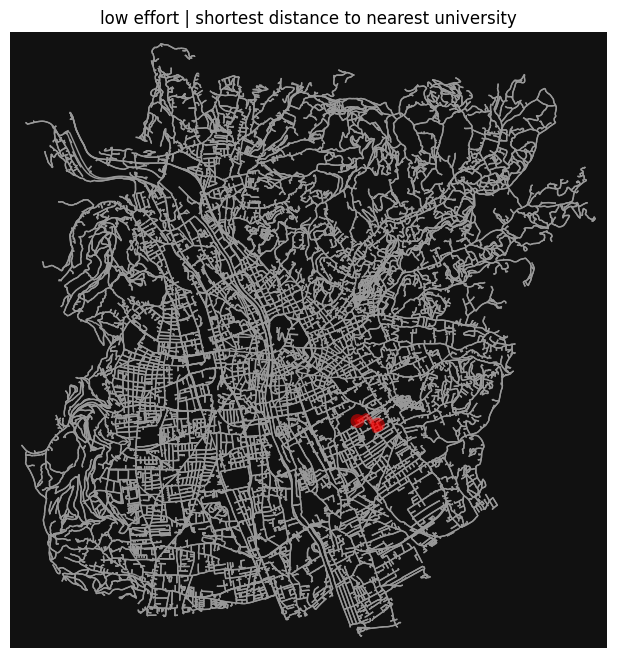

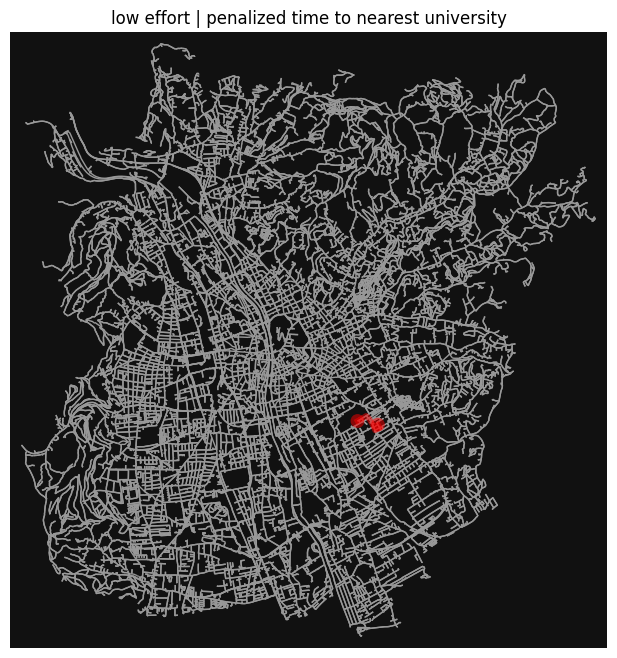

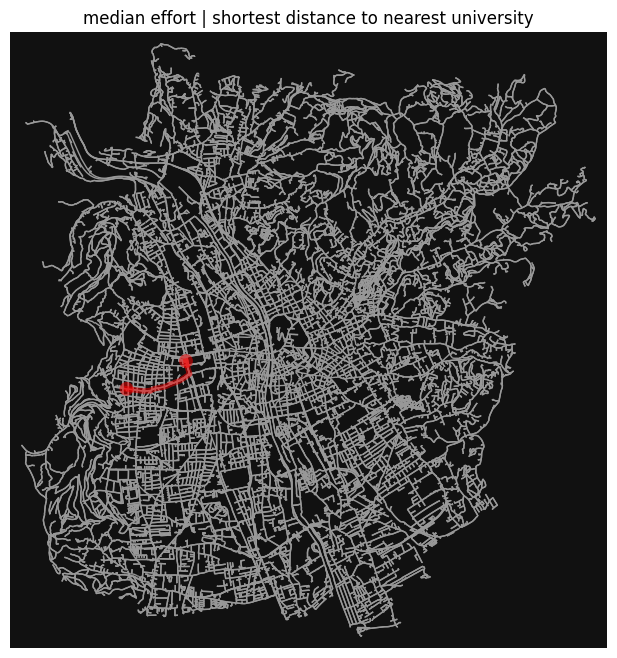

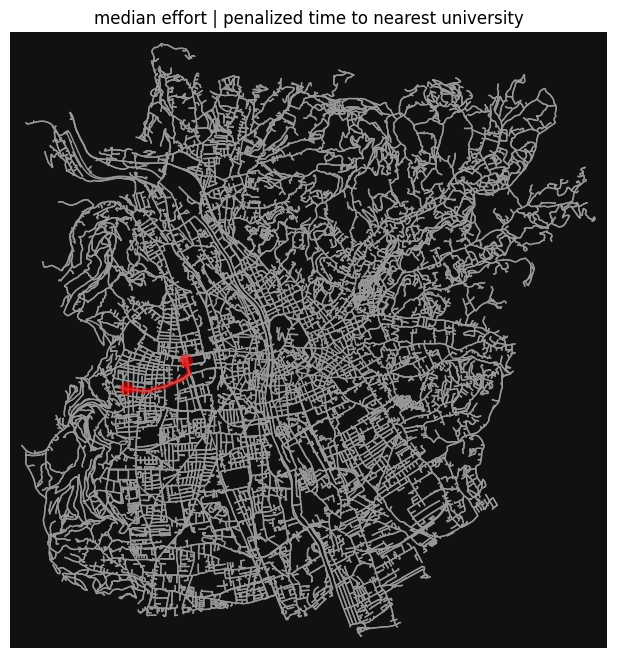

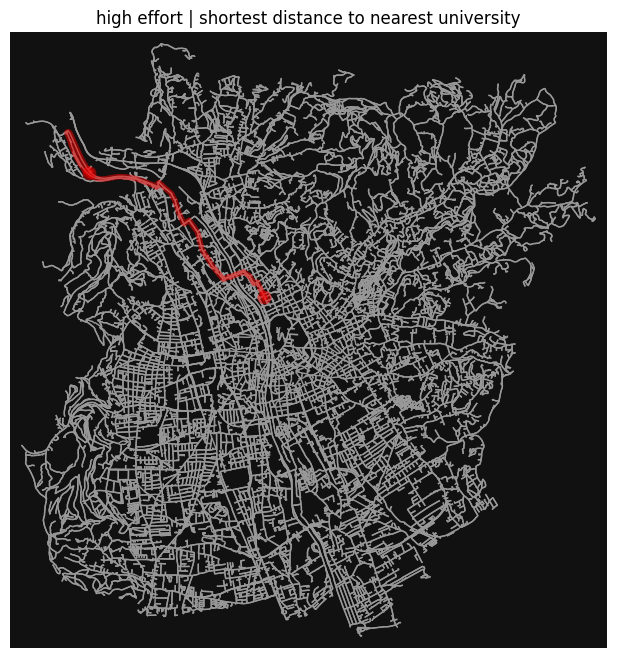

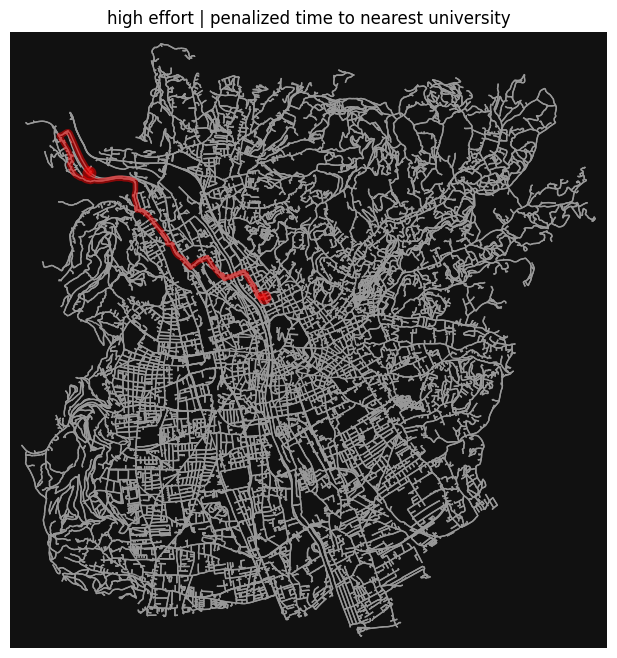

In [ ]:
import osmnx as ox

for i, row in sample_cells.iterrows():
    o = int(row["origin_node"])
    d = int(row["nearest_uni_node"])
    label = labels[i]

    p_len = nx.shortest_path(G_core, o, d, weight="length")
    p_w   = nx.shortest_path(G_core, o, d, weight="weighted_cost")

    fig, ax = ox.plot_graph_route(G_core, p_len, node_size=0,
                                  route_linewidth=4, show=False, close=False)
    ax.set_title(f"{label} | shortest distance to nearest university")
    plt.show()

    fig, ax = ox.plot_graph_route(G_core, p_w, node_size=0,
                                  route_linewidth=4, show=False, close=False)
    ax.set_title(f"{label} | penalized time to nearest university")
    plt.show()


In [ ]:
print(df_districts.columns)


Index(['geometry', 'boundary', 'ref', 'source', 'admin_level', 'note',
       'cycleway:both', 'highway', 'lanes', 'lit', 'maxspeed', 'name',
       'sidewalk', 'source:maxspeed', 'surface', 'boat', 'name:sl', 'waterway',
       'width', 'name:de', 'name:hu', 'sidewalk:left', 'sidewalk:right',
       'intermittent', 'type', 'name:prefix:at', 'postal_code', 'ref:at:gkz',
       'wikidata', 'wikipedia', 'name:ru', 'population', 'population:date',
       'name:sk', 'name:uk', 'name:zh', 'name:zh-Hant', 'name:ce', 'name:fa',
       'name:tt', 'ISO3166-2', 'alt_name:fur', 'alt_name:mk', 'alt_name:sl',
       'coat_of_arms', 'name:ar', 'name:be', 'name:be-tarask', 'name:ca',
       'name:cs', 'name:en', 'name:eo', 'name:es', 'name:fr', 'name:fur',
       'name:hr', 'name:it', 'name:ko', 'name:mk', 'name:nl', 'name:pl',
       'name:pt', 'name:ro', 'name:ta', 'name:zh-Hans', 'ref:nuts',
       'ref:nuts:2', 'website', 'ref:at:okz', 'official_name', 'admin_title',
       'designation', 'offici

In [ ]:
# --- Assign each grid cell to a district ---

gdf_grid_district = gpd.sjoin(
    gdf_grid_with_data,
    df_districts[["district_name", "geometry"]].to_crs(main_crs),
    how="left",
    predicate="intersects"
)

# Quick sanity check
gdf_grid_district[["cell_id", "district_name", "avg_weighted_time_min", "min_per_km"]].head()


cell_id district_name  avg_weighted_time_min  min_per_km
105      105   Wetzelsdorf              25.929899    4.932805
106      106   Wetzelsdorf              23.378981    4.664935
131      131       Gösting              35.418268    4.490871
149      149   Wetzelsdorf              24.063733    4.379917
151      151   Wetzelsdorf              26.612285    4.864844

In [ ]:
# --- Aggregate accessibility metrics by district (nearest university) ---

district_stats = (
    gdf_grid_district
    .groupby("district_name")
    .agg(
        median_weighted_time_min=("avg_weighted_time_min", "median"),
        mean_weighted_time_min=("avg_weighted_time_min", "mean"),
        median_min_per_km=("min_per_km", "median"),
        n_cells=("cell_id", "count")
    )
    .reset_index()
)

# Rank districts by disadvantage (higher = worse)
district_stats = district_stats.sort_values(
    "median_weighted_time_min", ascending=False
)

district_stats


district_name  median_weighted_time_min  mean_weighted_time_min  \
18         Straßgang                 22.313406               22.069836   
12          Puntigam                 22.133198               22.226284   
0            Andritz                 19.996446               19.820734   
9         Mariatrost                 19.009682               18.654412   
4            Gösting                 17.515831               18.503608   
8           Liebenau                 16.973253               16.863676   
20       Wetzelsdorf                 13.970000               14.561804   
13              Ries                 13.319827               14.284075   
10               Mur                 13.216075               13.762309   
16       Sankt Peter                 12.489528               11.973214   
11        Neufeldweg                 10.036819               10.036819   
3              Gries                  9.635493               10.038058   
1          Eggenberg                  9.492780               10.270569   
19        Waltendorf                  9.112122                9.693877   
17       Schöcklbach                  7.820096                7.820096   
6           Jakomini                  7.012173                7.534637   
7               Lend                  6.969872                6.519307   
14  Ruckerlberggasse                  6.260983                6.260983   
2            Geidorf                  4.782357                5.251667   
5       Innere Stadt                  4.596483                4.816501   
15    Sankt Leonhard                  3.848582                3.965082   

    median_min_per_km  n_cells  
18           4.388385      158  
12           4.338986       89  
0            4.188340      232  
9            4.249007      187  
4            4.265891      108  
8            4.354688       98  
20           4.431521       85  
13           4.558531      127  
10           4.348294       64  
16           4.209987      122  
11           4.044715        2  
3            4.359787       80  
1            4.379526      115  
19           4.344730       77  
17           4.469491        2  
6            4.387511       65  
7            4.490161       64  
14           4.450009        1  
2            4.263962       89  
5            4.383724       20  
15           4.347696       37

In [ ]:
# --- Cartographic helpers: north arrow and scale bar ---

def add_north_arrow(ax, size=0.08, loc=(0.95, 0.95)):
    x, y = loc
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - size),
        xycoords="axes fraction",
        textcoords="axes fraction",
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
        arrowprops=dict(
            arrowstyle="-|>",
            linewidth=1.5,
            color="black"
        )
    )


def add_scale_bar(ax, length_m=2000, loc=(0.05, 0.05)):
    x0, y0 = loc
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    x_start = x_min + x0 * (x_max - x_min)
    y_start = y_min + y0 * (y_max - y_min)
    x_end = x_start + length_m

    ax.plot([x_start, x_end], [y_start, y_start], color="black", linewidth=3)
    ax.text(
        (x_start + x_end) / 2,
        y_start + 0.01 * (y_max - y_min),
        f"{int(length_m/1000)} km",
        ha="center",
        va="bottom",
        fontsize=9
    )


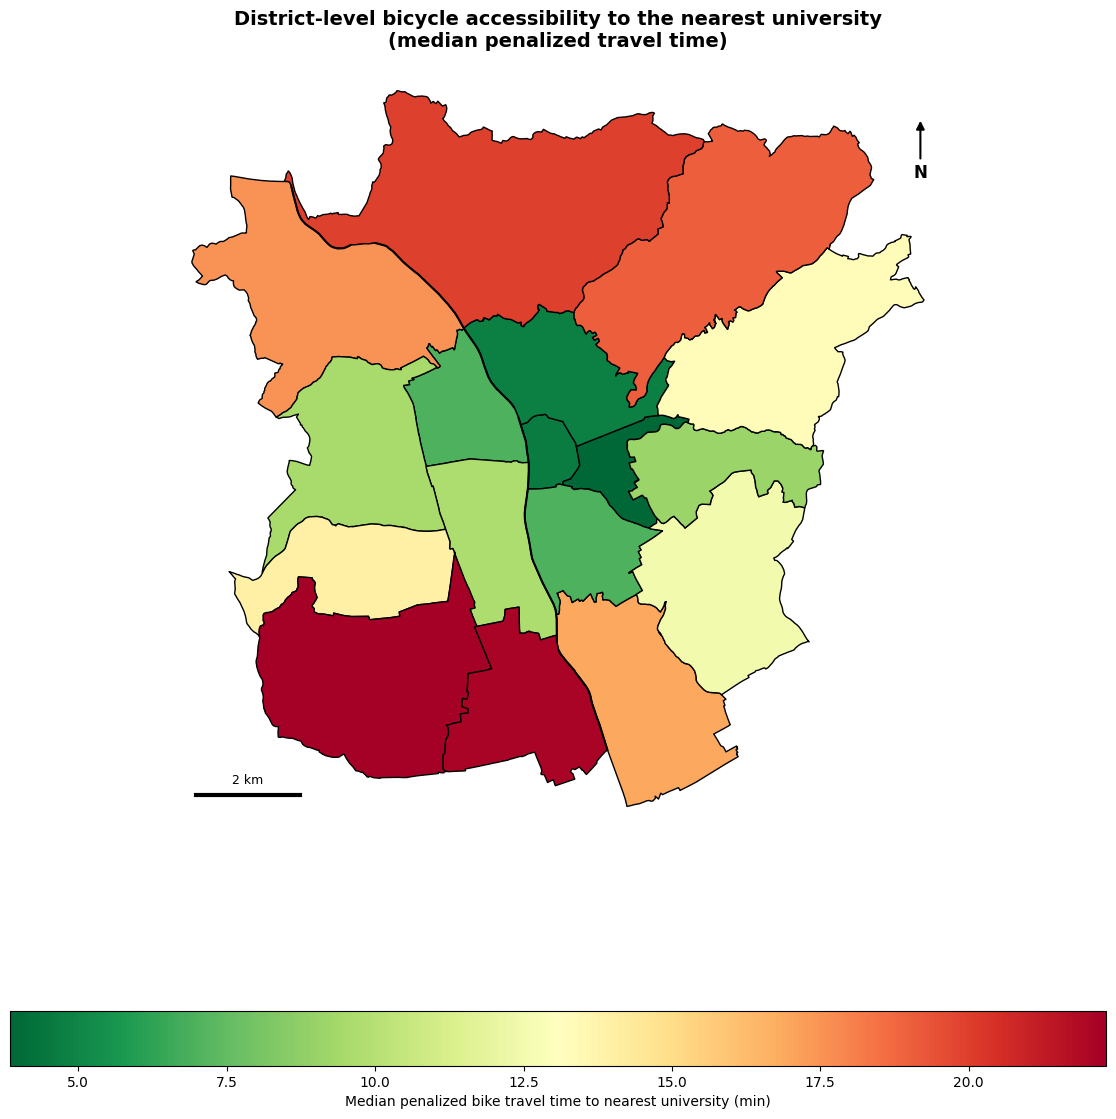

In [ ]:
# --- Join stats back to district geometries ---

districts_plot = df_districts.merge(
    district_stats,
    on="district_name",
    how="left"
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 12))

districts_plot.plot(
    ax=ax,
    column="median_weighted_time_min",
    cmap="RdYlGn_r",
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Median penalized bike travel time to nearest university (min)",
        "orientation": "horizontal",
        "shrink": 0.8,
    }
)

ax.set_title(
    "District-level bicycle accessibility to the nearest university\n"
    "(median penalized travel time)",
    fontsize=14,
    fontweight="bold"
)

ax.set_axis_off()
plt.tight_layout()
add_north_arrow(ax, size=0.07, loc=(0.95, 0.92))
add_scale_bar(ax, length_m=2000, loc=(0.05, 0.06))
plt.show()


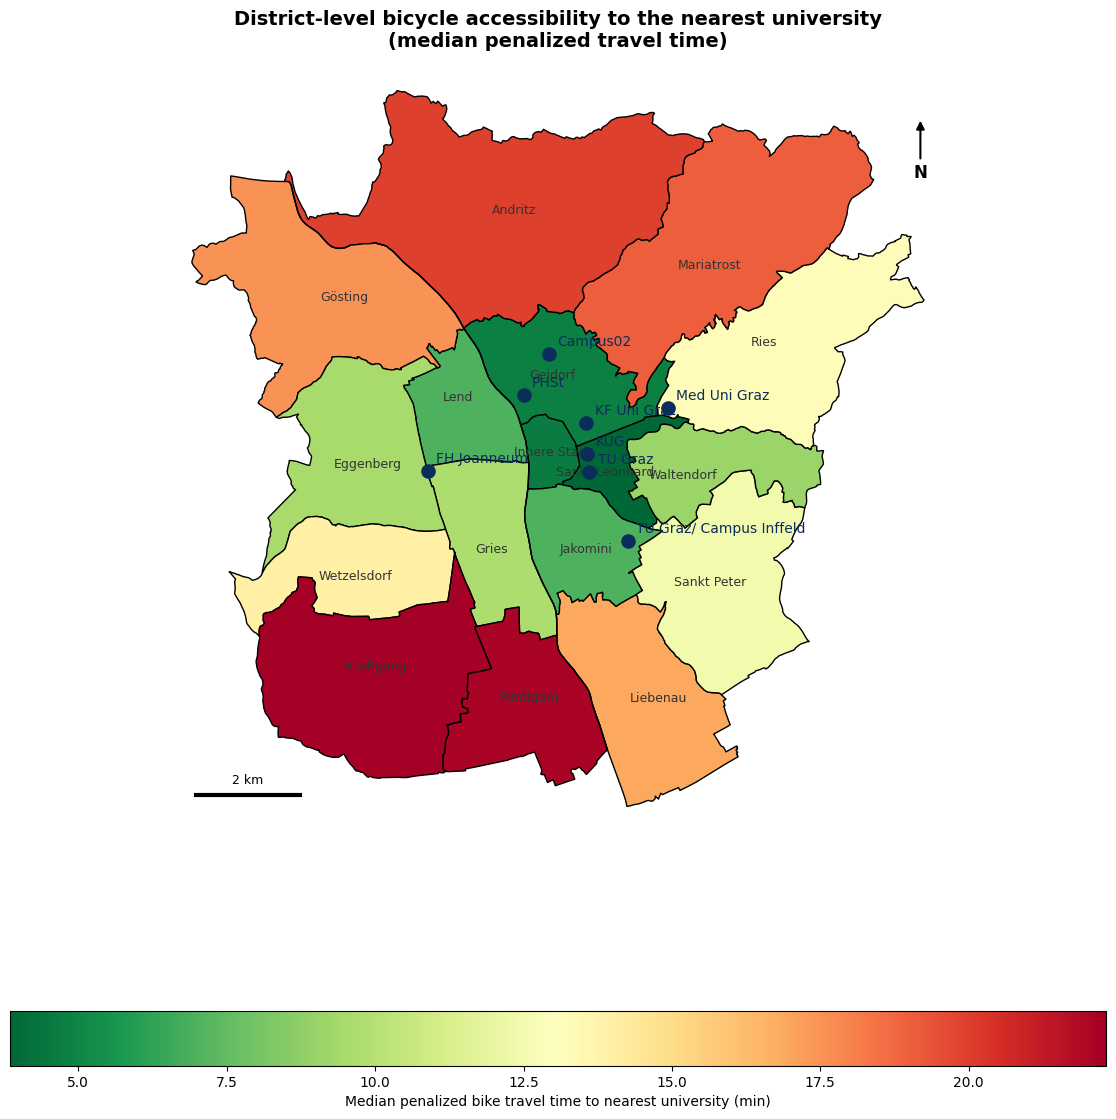

In [ ]:
fig, ax = plt.subplots(figsize=(14, 12))

# --- A) District choropleth (accessibility) ---
districts_plot.plot(
    ax=ax,
    column="median_weighted_time_min",
    cmap="RdYlGn_r",
    edgecolor="black",
    linewidth=1,
    legend=True,
    legend_kwds={
        "label": "Median penalized bike travel time to nearest university (min)",
        "orientation": "horizontal",
        "shrink": 0.8,
    }
)

# --- B) District labels (NO boxes) ---
for _, row in df_dist_labels.iterrows():
    x, y = row["label_pt"].x, row["label_pt"].y
    ax.text(
        x, y,
        row["name_norm"],
        ha="center",
        va="center",
        fontsize=9,
        color="#333333"   # dark gray
    )

# --- C) University points ---
graz_unis.plot(
    ax=ax,
    color="#0B2D5C",     # dark blue
    markersize=90,
    zorder=5
)

# --- D) University short-name labels (NO boxes) ---
for x, y, lab in zip(
    graz_unis.geometry.x,
    graz_unis.geometry.y,
    graz_unis["short_name"]
):
    ax.annotate(
        lab,
        (x, y),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=10,
        color="#0B2D5C",
        zorder=6
    )

# --- Layout ---
ax.set_title(
    "District-level bicycle accessibility to the nearest university\n"
    "(median penalized travel time)",
    fontsize=14,
    fontweight="bold"
)

ax.set_axis_off()
plt.tight_layout()
add_north_arrow(ax, size=0.07, loc=(0.95, 0.92))
add_scale_bar(ax, length_m=2000, loc=(0.05, 0.06))
plt.show()


In [ ]:
# --- Compute unweighted travel time (minutes) on grid level ---
BIKE_SPEED_KMH = 15.0  # use the same baseline speed as elsewhere

gdf_grid_with_data = gdf_grid_with_data.copy()

gdf_grid_with_data["avg_unweighted_time_min"] = (
    gdf_grid_with_data["avg_distance_m"] / 1000.0
) / BIKE_SPEED_KMH * 60.0


In [ ]:
gdf_grid_with_data[["avg_distance_m", "avg_unweighted_time_min"]].head()


avg_distance_m  avg_unweighted_time_min
105     5256.624000                21.026496
106     5011.641016                20.046564
131     7886.725853                31.546903
149     5494.107179                21.976429
151     5470.326907                21.881308

In [ ]:
gdf_grid_district = gpd.sjoin(
    gdf_grid_with_data,
    df_districts[["district_name", "geometry"]].to_crs(main_crs),
    how="left",
    predicate="intersects"
)


In [ ]:
gdf_grid_district.columns


Index(['cell_id', 'geometry', 'avg_distance_m', 'avg_weighted_s',
       'avg_weighted_time_min', 'distance_km', 'min_per_km',
       'avg_unweighted_time_min', 'element', 'id', 'district_name'],
      dtype='object')

In [ ]:
district_stats_unweighted = (
    gdf_grid_district
    .groupby("district_name")
    .agg(
        median_unweighted_time_min=("avg_unweighted_time_min", "median"),
        n_cells=("cell_id", "count")
    )
    .reset_index()
)

district_stats_unweighted = district_stats_unweighted[
    district_stats_unweighted["district_name"].isin(graz_district_names)
]


district_stats_unweighted.sort_values(
    "median_unweighted_time_min", ascending=False
)


district_name  median_unweighted_time_min  n_cells
12        Puntigam                   20.367355       89
18       Straßgang                   20.219158      158
0          Andritz                   19.249402      232
9       Mariatrost                   18.300243      187
4          Gösting                   16.369782      108
8         Liebenau                   15.449005       98
20     Wetzelsdorf                   12.784755       85
16     Sankt Peter                   11.840371      122
13            Ries                   11.794358      127
3            Gries                    8.993813       80
1        Eggenberg                    8.586925      115
19      Waltendorf                    8.129352       77
6         Jakomini                    6.540154       65
7             Lend                    6.114763       64
2          Geidorf                    4.517462       89
5     Innere Stadt                    4.102788       20
15  Sankt Leonhard                    3.527264       37

In [ ]:

# --- Aggregate WEIGHTED accessibility by district ---

district_stats_weighted = (
    gdf_grid_district
    .groupby("district_name")
    .agg(
        median_weighted_time_min=("avg_weighted_time_min", "median"),
        n_cells=("cell_id", "count")
    )
    .reset_index()
)

# Keep only official Graz districts
district_stats_weighted = district_stats_weighted[
    district_stats_weighted["district_name"].isin(graz_district_names)
]

district_stats_weighted

# --- Compare weighted vs unweighted accessibility ---

district_compare = (
    district_stats_weighted.merge(
        district_stats_unweighted,
        on="district_name",
        suffixes=("_weighted", "_unweighted")
    )
)

district_compare["delta_time_min"] = (
    district_compare["median_weighted_time_min"]
    - district_compare["median_unweighted_time_min"]
)

district_compare = district_compare.sort_values(
    "delta_time_min", ascending=False
)

district_compare


district_name  median_weighted_time_min  n_cells_weighted  \
14       Straßgang                 22.313406               158   
10        Puntigam                 22.133198                89   
11            Ries                 13.319827               127   
8         Liebenau                 16.973253                98   
16     Wetzelsdorf                 13.970000                85   
4          Gösting                 17.515831               108   
15      Waltendorf                  9.112122                77   
1        Eggenberg                  9.492780               115   
7             Lend                  6.969872                64   
0          Andritz                 19.996446               232   
9       Mariatrost                 19.009682               187   
13     Sankt Peter                 12.489528               122   
3            Gries                  9.635493                80   
5     Innere Stadt                  4.596483                20   
6         Jakomini                  7.012173                65   
12  Sankt Leonhard                  3.848582                37   
2          Geidorf                  4.782357                89   

    median_unweighted_time_min  n_cells_unweighted  delta_time_min  
14                   20.219158                 158        2.094248  
10                   20.367355                  89        1.765843  
11                   11.794358                 127        1.525469  
8                    15.449005                  98        1.524248  
16                   12.784755                  85        1.185245  
4                    16.369782                 108        1.146050  
15                    8.129352                  77        0.982770  
1                     8.586925                 115        0.905855  
7                     6.114763                  64        0.855110  
0                    19.249402                 232        0.747044  
9                    18.300243                 187        0.709439  
13                   11.840371                 122        0.649157  
3                     8.993813                  80        0.641680  
5                     4.102788                  20        0.493696  
6                     6.540154                  65        0.472019  
12                    3.527264                  37        0.321317  
2                     4.517462                  89        0.264895

In [ ]:
district_stats_weighted.head()


district_name  median_weighted_time_min  n_cells
0       Andritz                 19.996446      232
1     Eggenberg                  9.492780      115
2       Geidorf                  4.782357       89
3         Gries                  9.635493       80
4       Gösting                 17.515831      108

In [ ]:
district_compare[[
    "district_name",
    "median_unweighted_time_min",
    "median_weighted_time_min",
    "delta_time_min"
]].round(2)


district_name  median_unweighted_time_min  median_weighted_time_min  \
14       Straßgang                       20.22                     22.31   
10        Puntigam                       20.37                     22.13   
11            Ries                       11.79                     13.32   
8         Liebenau                       15.45                     16.97   
16     Wetzelsdorf                       12.78                     13.97   
4          Gösting                       16.37                     17.52   
15      Waltendorf                        8.13                      9.11   
1        Eggenberg                        8.59                      9.49   
7             Lend                        6.11                      6.97   
0          Andritz                       19.25                     20.00   
9       Mariatrost                       18.30                     19.01   
13     Sankt Peter                       11.84                     12.49   
3            Gries                        8.99                      9.64   
5     Innere Stadt                        4.10                      4.60   
6         Jakomini                        6.54                      7.01   
12  Sankt Leonhard                        3.53                      3.85   
2          Geidorf                        4.52                      4.78   

    delta_time_min  
14            2.09  
10            1.77  
11            1.53  
8             1.52  
16            1.19  
4             1.15  
15            0.98  
1             0.91  
7             0.86  
0             0.75  
9             0.71  
13            0.65  
3             0.64  
5             0.49  
6             0.47  
12            0.32  
2             0.26

In [ ]:
districts_delta = df_districts.merge(
    district_compare[["district_name", "delta_time_min"]],
    on="district_name",
    how="left"
)


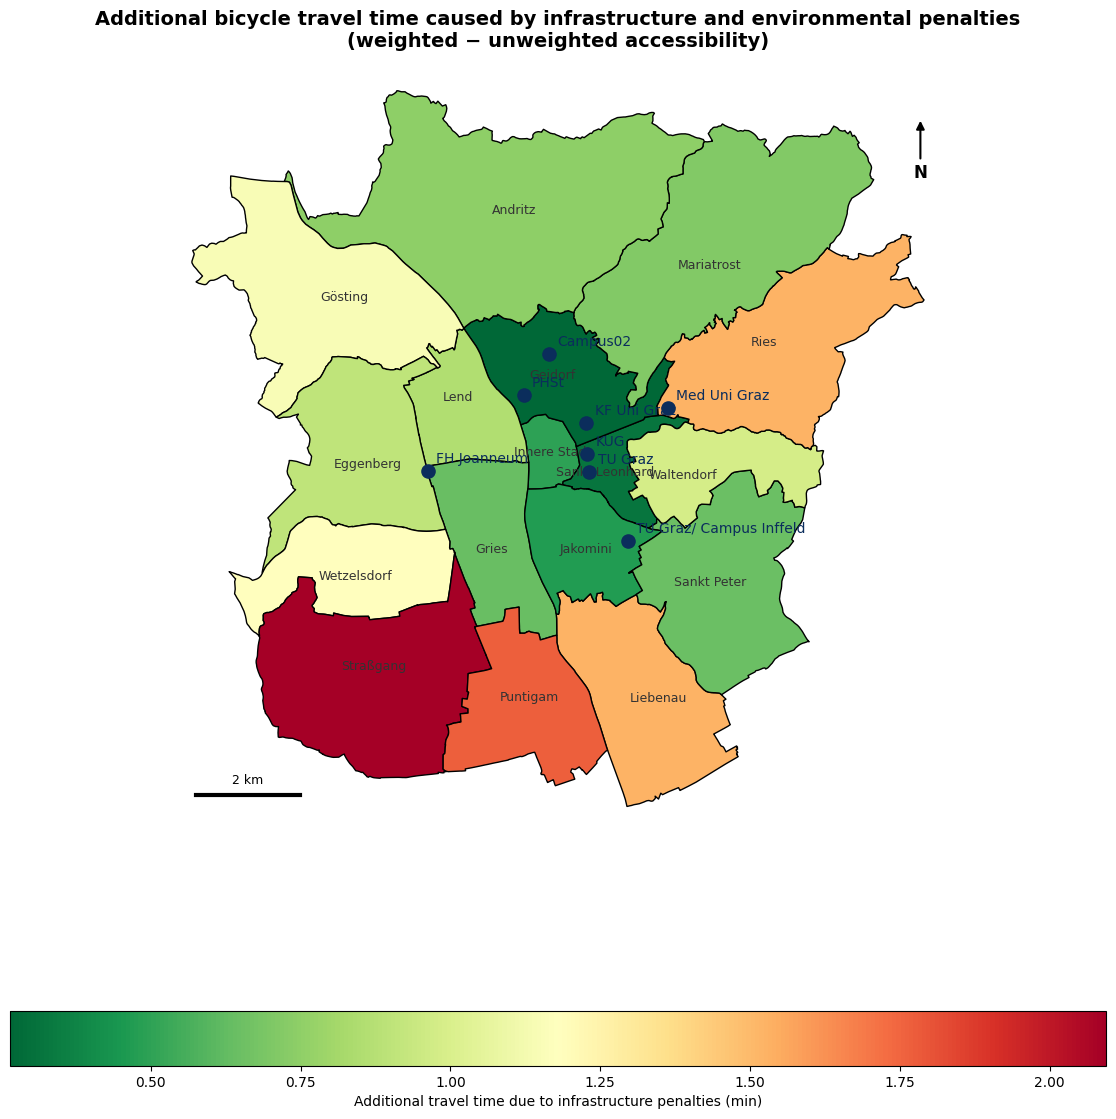

In [ ]:
# --- Merge delta values back to district geometries ---
districts_delta = df_districts.merge(
    district_compare[["district_name", "delta_time_min"]],
    on="district_name",
    how="left"
)

fig, ax = plt.subplots(figsize=(14, 12))

districts_delta.plot(
    ax=ax,
    column="delta_time_min",
    cmap="RdYlGn_r",          # red = strong penalty, green = weak
    edgecolor="black",
    linewidth=1,
    legend=True,
    legend_kwds={
        "label": "Additional travel time due to infrastructure penalties (min)",
        "orientation": "horizontal",
        "shrink": 0.8,
    }
)

# --- District labels (no boxes) ---
for _, row in df_dist_labels.iterrows():
    x, y = row["label_pt"].x, row["label_pt"].y
    ax.text(
        x, y,
        row["name_norm"],
        ha="center",
        va="center",
        fontsize=9,
        color="#333333"
    )

# --- University points ---
graz_unis.plot(
    ax=ax,
    color="#0B2D5C",
    markersize=90,
    zorder=5
)

# --- University labels ---
for x, y, lab in zip(
    graz_unis.geometry.x,
    graz_unis.geometry.y,
    graz_unis["short_name"]
):
    ax.annotate(
        lab,
        (x, y),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=10,
        color="#0B2D5C",
        zorder=6
    )

ax.set_title(
    "Additional bicycle travel time caused by infrastructure and environmental penalties\n"
    "(weighted − unweighted accessibility)",
    fontsize=14,
    fontweight="bold"
)

ax.set_axis_off()
plt.tight_layout()
add_north_arrow(ax, size=0.07, loc=(0.95, 0.92))
add_scale_bar(ax, length_m=2000, loc=(0.05, 0.06))
plt.show()


In [ ]:
import re
import networkx as nx

LOW_SPEED_ROAD_TYPES = {
    "residential", "living_street", "service", "unclassified", "tertiary", "road"
}

def _first(x):
    return x[0] if isinstance(x, list) and len(x) else x

def parse_maxspeed_kmh(val):
    """
    Parse OSM maxspeed into an integer km/h if possible, else return None.
    Handles values like '30', '30 km/h', ['30', '50'], 'walk', etc.
    """
    if val is None:
        return None
    val = _first(val)

    if isinstance(val, (int, float)):
        return int(val)

    s = str(val).strip().lower()

    # common non-numeric tags
    if s in {"walk", "walking_speed"}:
        return 5

    # extract first number
    m = re.search(r"\d+", s)
    if not m:
        return None
    return int(m.group(0))


def has_cycle_infra(data):
    """
    Broad cycle-infrastructure indicator.
    """
    hw = _first(data.get("highway"))
    bicycle = data.get("bicycle")
    cycleway = data.get("cycleway")

    if hw == "cycleway":
        return True
    if bicycle == "designated":
        return True
    if cycleway is not None:
        return True

    # also consider paths/tracks if bikes are not forbidden
    if hw in {"path", "track"} and data.get("bicycle") != "no":
        return True

    return False


def is_low_speed_30_or_less(data):
    """
    True if edge is on a street with maxspeed <= 30,
    or if maxspeed is missing but road type suggests low speed (fallback).
    """
    hw = _first(data.get("highway"))
    ms = parse_maxspeed_kmh(data.get("maxspeed"))

    if ms is not None:
        return ms <= 30

    # Fallback when maxspeed is missing:
    # treat typical local streets as <=30 (adjust if you want stricter rules)
    return hw in LOW_SPEED_ROAD_TYPES


def edge_keep_cycle_plus_30(data):
    """
    Keep edge if it is cycle infrastructure OR low-speed street (<=30 km/h).
    """
    # Exclude edges explicitly not allowed for bikes
    if data.get("bicycle") == "no":
        return False

    return has_cycle_infra(data) or is_low_speed_30_or_less(data)


def filter_graph_edges(G, edge_predicate):
    """
    Build a subgraph containing only edges that satisfy edge_predicate(data).
    Works for MultiDiGraph.
    """
    H = G.__class__()
    H.add_nodes_from(G.nodes(data=True))

    for u, v, k, data in G.edges(keys=True, data=True):
        if edge_predicate(data):
            H.add_edge(u, v, key=k, **data)

    H.remove_nodes_from(list(nx.isolates(H)))
    return H


# --- Build "cycle infra + <=30 km/h" graph ---
G_lowstress = filter_graph_edges(G_core, edge_keep_cycle_plus_30)

print("Original edges:", G_core.number_of_edges())
print("Low-stress edges:", G_lowstress.number_of_edges())
print("Low-stress nodes:", G_lowstress.number_of_nodes())

# Keep largest weakly connected component for routing coverage
largest_wcc = max(nx.weakly_connected_components(G_lowstress), key=len)
G_lowstress_core = G_lowstress.subgraph(largest_wcc).copy()

print("Low-stress core nodes:", G_lowstress_core.number_of_nodes())


Original edges: 50883
Low-stress edges: 43729
Low-stress nodes: 21742
Low-stress core nodes: 15856


In [ ]:
print(gdf_grid_district.columns)


Index(['cell_id', 'geometry', 'avg_distance_m', 'avg_weighted_s',
       'avg_weighted_time_min', 'distance_km', 'min_per_km',
       'avg_unweighted_time_min', 'element', 'id', 'district_name'],
      dtype='object')


In [ ]:
print(gdf_grid_with_data.columns)


Index(['cell_id', 'geometry', 'avg_distance_m', 'avg_weighted_s',
       'avg_weighted_time_min', 'distance_km', 'min_per_km',
       'avg_unweighted_time_min'],
      dtype='object')


In [ ]:
# --- Create one representative origin_node per grid cell (from G_core nodes) ---
cell_pts = gdf_grid.copy()
cell_pts["cell_pt"] = cell_pts.geometry.representative_point()
cell_pts = cell_pts.set_geometry("cell_pt")

cell2node = gpd.sjoin_nearest(
    cell_pts[["cell_id", "cell_pt"]],
    nodes_gdf[["node_id", "geometry"]],
    how="left",
    distance_col="snap_dist_m"
).drop(columns=["index_right"])

cell2node = cell2node.rename(columns={"node_id": "origin_node"})

# attach to BOTH tables (so you can use whichever you work with)
gdf_grid_with_data = gdf_grid_with_data.merge(
    cell2node[["cell_id", "origin_node", "snap_dist_m"]],
    on="cell_id", how="left"
)

gdf_grid_district = gdf_grid_district.merge(
    cell2node[["cell_id", "origin_node"]],
    on="cell_id", how="left"
)

print("Missing origin_node (grid_with_data):", gdf_grid_with_data["origin_node"].isna().sum())
print("Missing origin_node (grid_district):", gdf_grid_district["origin_node"].isna().sum())


Missing origin_node (grid_with_data): 0
Missing origin_node (grid_district): 0


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np

# --- 1) Mark whether each grid origin node is inside the low-stress core ---
core_nodes = set(G_lowstress_core.nodes())

g = gdf_grid_district.copy()
g["reachable_lowstress"] = g["origin_node"].isin(core_nodes)

# --- 2) Coverage per district ---
coverage = (
    g.groupby("district_name")
     .agg(
         n_cells=("cell_id", "count"),
         n_reachable=("reachable_lowstress", "sum"),
         share_reachable=("reachable_lowstress", "mean"),
     )
     .reset_index()
)

# Keep only official districts (optional)
coverage = coverage[coverage["district_name"].isin(graz_district_names)]

coverage = coverage.sort_values("share_reachable")
coverage


district_name  n_cells  n_reachable  share_reachable
13            Ries      127           42         0.330709
4          Gösting      108           52         0.481481
0          Andritz      232          139         0.599138
8         Liebenau       98           67         0.683673
6         Jakomini       65           45         0.692308
5     Innere Stadt       20           14         0.700000
15  Sankt Leonhard       37           26         0.702703
20     Wetzelsdorf       85           63         0.741176
18       Straßgang      158          124         0.784810
3            Gries       80           63         0.787500
1        Eggenberg      115           91         0.791304
19      Waltendorf       77           63         0.818182
16     Sankt Peter      122          102         0.836066
7             Lend       64           54         0.843750
2          Geidorf       89           76         0.853933
9       Mariatrost      187          167         0.893048
12        Puntigam       89           81         0.910112

In [ ]:
%whos


Variable                        Type                   Data/Info
----------------------------------------------------------------
BIKE_KMH                        float                  15.0
BIKE_SPEED_KMH                  float                  15.0
G                               MultiDiGraph           MultiDiGraph with 26264 nodes and 59037 edges
G_bike                          MultiDiGraph           MultiDiGraph with 23353 nodes and 52540 edges
G_core                          MultiDiGraph           MultiDiGraph with 22161 nodes and 50883 edges
G_district                      DiGraph                DiGraph with 1638 nodes and 3616 edges
G_filt                          MultiDiGraph           MultiDiGraph with 19470 nodes and 43541 edges
G_lowstress                     MultiDiGraph           MultiDiGraph with 21742 nodes and 43729 edges
G_lowstress_core                MultiDiGraph           MultiDiGraph with 15856 nodes and 34646 edges
G_raw                           MultiDiGraph      

In [ ]:
%whos DataFrame


Variable                    Type         Data/Info
--------------------------------------------------
cand_far                    DataFrame    Shape: (10, 9)
cand_sensitive              DataFrame    Shape: (10, 9)
cand_sensitive_clean        DataFrame    Shape: (10, 9)
cand_stable                 DataFrame    Shape: (10, 9)
coverage                    DataFrame    Shape: (17, 4)
df                          DataFrame    Shape: (21470, 9)
df2                         DataFrame    Shape: (21470, 9)
df_candidates               DataFrame    Shape: (1, 5)
df_compare                  DataFrame    Shape: (3, 14)
df_len                      DataFrame    Shape: (22071, 5)
df_routes                   DataFrame    Shape: (3, 9)
df_routes_nearest           DataFrame    Shape: (3, 9)
df_w                        DataFrame    Shape: (22071, 6)
district_compare            DataFrame    Shape: (17, 6)
district_stats              DataFrame    Shape: (21, 5)
district_stats_unweighted   DataFrame    Shape: (

In [ ]:
coverage = coverage.rename(columns={"share_reachable": "share_reachable_lowstress"})


In [ ]:
print("coverage columns:", list(coverage.columns))
print("coverage index name:", coverage.index.name)

cov = coverage.reset_index()  # falls district_name (oder share) im Index steckt

# finde die "share"-Spalte automatisch
share_col = [c for c in cov.columns if "share" in c.lower()]
print("share candidates:", share_col)

# nimm die erste gefundene share-Spalte
share_col = share_col[0]

cov_small = cov[["district_name", share_col]].copy()
cov_small = cov_small.rename(columns={share_col: "share_reachable"})
cov_small.head()


coverage columns: ['district_name', 'n_cells', 'n_reachable', 'share_reachable_lowstress']
coverage index name: None
share candidates: ['share_reachable_lowstress']


district_name  share_reachable
0          Ries         0.330709
1       Gösting         0.481481
2       Andritz         0.599138
3      Liebenau         0.683673
4      Jakomini         0.692308

In [ ]:
districts_coverage = df_districts.merge(
    coverage[["district_name", "share_reachable_lowstress"]],
    on="district_name",
    how="left"
)

districts_coverage[["district_name", "share_reachable_lowstress"]].head()


district_name  share_reachable_lowstress
0    Innere Stadt                   0.700000
1        Liebenau                   0.683673
2  Sankt Leonhard                   0.702703
3         Geidorf                   0.853933
4            Lend                   0.843750

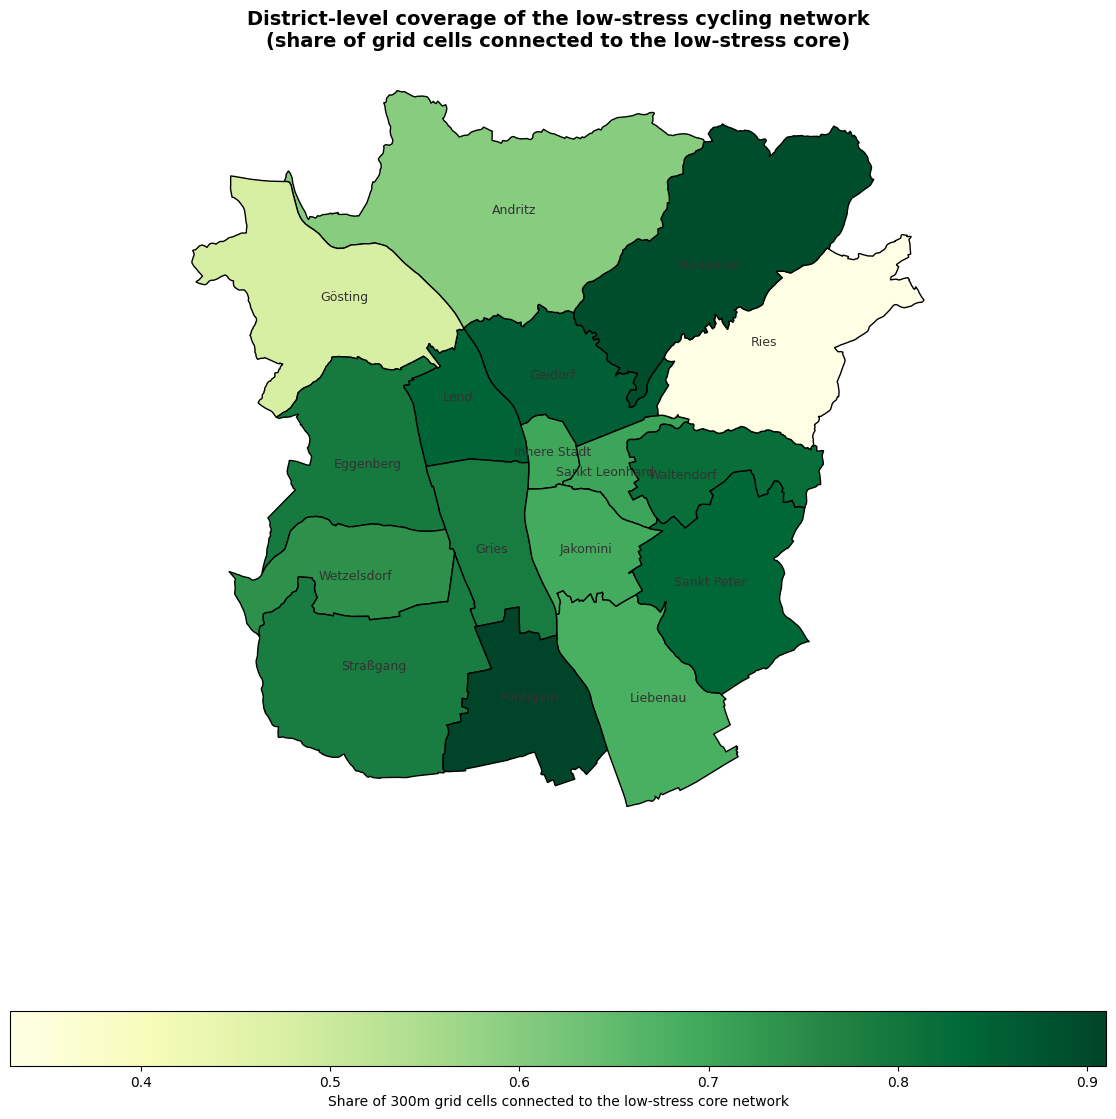

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 12))

districts_coverage.plot(
    ax=ax,
    column="share_reachable_lowstress",
    cmap="YlGn",            # high share = darker green
    edgecolor="black",
    linewidth=1,
    legend=True,
    legend_kwds={
        "label": "Share of 300m grid cells connected to the low-stress core network",
        "orientation": "horizontal",
        "shrink": 0.8,
    }
)

# District labels (no boxes)
for _, row in df_dist_labels.iterrows():
    x, y = row["label_pt"].x, row["label_pt"].y
    ax.text(x, y, row["name_norm"], ha="center", va="center", fontsize=9, color="#333333")

ax.set_title(
    "District-level coverage of the low-stress cycling network\n"
    "(share of grid cells connected to the low-stress core)",
    fontsize=14,
    fontweight="bold"
)

ax.set_axis_off()
plt.tight_layout()

# optional, wenn du die Funktionen schon hast:
# add_north_arrow(ax, size=0.07, loc=(0.95, 0.92))
# add_scale_bar(ax, length_m=2000, loc=(0.05, 0.06))

plt.show()


## Result 
This choropleth map visualizes low-stress network coverage by district. For each district, we computed the share of 300 m grid cells whose nearest routable node is part of the low-stress core cycling network (i.e., cells that are connected to the subset of links we consider suitable for “low-stress” cycling).
Result (key pattern / interpretation)
Coverage is strongest in most central districts, where a large fraction of grid cells remains connected after applying the low-stress filtering. In contrast, coverage drops markedly in Ries (lowest share) and is also comparatively lower in Gösting and Andritz, indicating that many locations in these districts rely on links that do not meet the low-stress criteria. Overall, the map suggests that low-stress connectivity is spatially uneven: while many areas remain connected, some peripheral districts show substantial gaps, implying limited low-stress access and a higher dependence on more stressful road segments.


In [ ]:
print(graz_unis_proj.columns)
print(gdf_grid_with_data.columns)


Index(['name', 'geometry', 'short_name', 'nearest_node', 'dist_to_node_m',
       'nearest_edge', 'dist_to_edge_m', 'core_node', 'snap_dist_m',
       'core_edge', 'snap_edge_dist_m'],
      dtype='object')
Index(['cell_id', 'geometry', 'avg_distance_m', 'avg_weighted_s',
       'avg_weighted_time_min', 'distance_km', 'min_per_km',
       'avg_unweighted_time_min', 'origin_node', 'snap_dist_m'],
      dtype='object')


In [ ]:
# --- FIX: ensure CRS metadata exists on low-stress graphs ---
for G_fix in [G_lowstress, G_lowstress_core]:
    if "crs" not in G_fix.graph:
        G_fix.graph["crs"] = G_core.graph.get("crs", None)

print("G_core CRS:", G_core.graph.get("crs"))
print("G_lowstress_core CRS:", G_lowstress_core.graph.get("crs"))


G_core CRS: EPSG:31256
G_lowstress_core CRS: EPSG:31256


In [ ]:
import numpy as np
import osmnx as ox

g = gdf_grid_with_data.copy()
g["origin_core"] = g["origin_node"].astype(int)

x_core = g["origin_core"].map(lambda n: G_core.nodes[n].get("x", np.nan))
y_core = g["origin_core"].map(lambda n: G_core.nodes[n].get("y", np.nan))

mask = np.isfinite(x_core) & np.isfinite(y_core)

g["origin_low"] = np.nan
g.loc[mask, "origin_low"] = ox.distance.nearest_nodes(
    G_lowstress_core,
    X=x_core[mask].to_numpy(),
    Y=y_core[mask].to_numpy()
)

g["origin_low"] = g["origin_low"].astype("Int64")  # nullable int
print("Snapped origins:", g["origin_low"].notna().mean())


Snapped origins: 1.0


In [ ]:
# --- snap universities from core graph to low-stress core graph ---
unis = graz_unis_proj.copy()

# coords of core_node on G_core
unis["x_core"] = unis["core_node"].map(lambda n: G_core.nodes[int(n)].get("x"))
unis["y_core"] = unis["core_node"].map(lambda n: G_core.nodes[int(n)].get("y"))

mask_u = unis["x_core"].notna() & unis["y_core"].notna()

unis["low_node"] = np.nan
unis.loc[mask_u, "low_node"] = ox.distance.nearest_nodes(
    G_lowstress_core,
    X=unis.loc[mask_u, "x_core"].to_numpy(),
    Y=unis.loc[mask_u, "y_core"].to_numpy()
)
unis["low_node"] = unis["low_node"].astype("Int64")

uni_nodes_low = unis["low_node"].dropna().astype(int).unique().tolist()
print("Low-stress university nodes:", len(uni_nodes_low))


Low-stress university nodes: 8


In [ ]:
dist_low_m = nx.multi_source_dijkstra_path_length(
    G_lowstress_core,
    sources=uni_nodes_low,
    weight="length"
)

g["low_len_m"] = g["origin_low"].map(dist_low_m)
print("Low-stress distances available:", g["low_len_m"].notna().mean())


Low-stress distances available: 0.9697624190064795


In [ ]:
# check if weighted_cost exists on low-stress edges
has_weighted = any("weighted_cost" in data for _, _, data in G_lowstress_core.edges(data=True))
print("Low-stress has weighted_cost:", has_weighted)

if has_weighted:
    dist_low_s = nx.multi_source_dijkstra_path_length(
        G_lowstress_core,
        sources=uni_nodes_low,
        weight="weighted_cost"
    )
    g["low_time_min"] = g["origin_low"].map(dist_low_s) / 60.0


Low-stress has weighted_cost: True


In [ ]:
# baseline already in the grid (gdf_grid_with_data)
# here: g is the working copy

g["detour_factor_dist"] = g["low_len_m"] / g["avg_distance_m"]
g["extra_dist_m"] = g["low_len_m"] - g["avg_distance_m"]

if "low_time_min" in g.columns:
    g["detour_factor_time"] = g["low_time_min"] / g["avg_weighted_time_min"]
    g["extra_time_min"] = g["low_time_min"] - g["avg_weighted_time_min"]

g[["avg_distance_m","low_len_m","detour_factor_dist","extra_dist_m"]].describe()


avg_distance_m     low_len_m  detour_factor_dist  extra_dist_m
count     1389.000000   1347.000000         1347.000000   1347.000000
mean      3656.925422   5088.607646            1.461077   1397.608957
std       1798.870690   2402.869506            0.677114   1171.051390
min        128.621049     34.349819            0.069962  -2450.680662
25%       2146.731349   3017.758233            1.155527    426.439420
50%       3631.823425   5200.993827            1.327173   1214.710968
75%       5050.557789   6992.492865            1.570174   2144.692679
max       8094.398111  10261.517851           12.284015   6631.256940

In [ ]:
g = g.merge(
    gdf_grid_district[["cell_id", "district_name"]],
    on="cell_id",
    how="left"
)

district_low = g.groupby("district_name").agg(
    n_cells=("cell_id","count"),
    share_reachable_low=("low_len_m", lambda s: s.notna().mean()),
    median_detour=("detour_factor_dist","median"),
    median_extra_m=("extra_dist_m","median"),
).reset_index().sort_values("share_reachable_low")

district_low.head(10)


district_name  n_cells  share_reachable_low  median_detour  \
15  Sankt Leonhard       37             0.891892       1.083123   
6         Jakomini       65             0.907692       1.339193   
7             Lend       64             0.937500       2.293222   
2          Geidorf       89             0.943820       1.366326   
5     Innere Stadt       20             0.950000       1.329508   
8         Liebenau       98             0.959184       1.449792   
19      Waltendorf       77             0.961039       1.107359   
3            Gries       80             0.962500       1.568788   
20     Wetzelsdorf       85             0.964706       1.433709   
0          Andritz      232             0.974138       1.316501   

    median_extra_m  
15       94.317229  
6       600.035500  
7      1966.208270  
2       536.029455  
5       330.604798  
8      1875.682828  
19      260.174965  
3      1065.873722  
20     1237.783641  
0      1740.161834

Restricting routing to the low-stress bicycle network (cycleways plus low-speed streets) increases the distance to the nearest university for most origins. Across grid cells with valid paths in both networks, the average shortest-path distance rises from 3.66 km (baseline) to 5.09 km (low-stress). This corresponds to a median detour factor of 1.33 (mean 1.46) and a median additional distance of ~1.21 km (mean ~1.40 km). In other words, prioritizing low-stress links typically requires about one-third longer trips to reach the nearest university.


In [ ]:
import numpy as np
import osmnx as ox

# 0) arbeite auf DEM Grid-DF, das du wirklich weiterverwenden willst:
g = gdf_grid_with_data.copy()   # oder gdf_grid_district.copy()

# 1) safety: Graph braucht crs, sonst knallt ox.nearest_nodes manchmal
if "crs" not in G_core.graph:
    G_core.graph["crs"] = main_crs  # z.B. "EPSG:31256" oder dein main_crs-Objekt

# 2) origin_node aus Zell-Zentroid (oder repr. Punkt) bestimmen
if "origin_node" not in g.columns:
    pts = g.geometry.representative_point()  # stabiler als centroid bei schrägen Polygonen
    g["origin_node"] = ox.distance.nearest_nodes(
        G_core,
        X=pts.x.to_numpy(),
        Y=pts.y.to_numpy()
    )

g["origin_node"] = g["origin_node"].astype("Int64")
print("origin_node available:", g["origin_node"].notna().mean())


origin_node available: 1.0


In [ ]:
print(g.columns)
print("origin_node null share:", g["origin_node"].isna().mean())


Index(['cell_id', 'geometry', 'avg_distance_m', 'avg_weighted_s',
       'avg_weighted_time_min', 'distance_km', 'min_per_km',
       'avg_unweighted_time_min', 'origin_node', 'snap_dist_m'],
      dtype='object')
origin_node null share: 0.0


In [ ]:
o_test = int(g["origin_node"].iloc[0])
res = find_nearest_uni_fast(
    o_test,
    uni_nodes_core,
    uni_distance_maps,
    weight_type="length"
)
print(res)
print("keys:", list(res.keys()) if isinstance(res, dict) else type(res))


{'uni_node': 13384518939, 'cost': 5213.380856938742, 'path': [13384518939, 1763734785, 1763734780, 10138090512, 21643201, 25703850, 365550464, 9168473803, 13384518926, 10005039442, 11716582051, 11716582053, 11716582055, 11716582056, 11716582057, 11716582059, 377660818, 1420810635, 271782274, 265182273, 255880385, 13431500981, 44907090, 2104367133, 269034564, 27414329, 44907096, 44907102, 1026593517, 27414325, 1244386453, 4327958503, 271783850, 271783851, 26790245, 27775607, 3431756377, 264110617, 11057598776, 5952462523, 249325037, 2299926321, 26790238, 1459226750, 327716073, 26790234, 2062421803, 26790232, 26790229, 5122478770, 13458805548, 275572724, 275572568, 5924705998, 1773391224, 2459805759, 270194741, 1757126151, 2476705162, 2476705321, 2415660004, 7998909241, 327715752, 2459805727, 327715736, 7989461281, 26790186, 2459805708, 2459805701, 2459805700, 274812713, 2459805705, 2459805699, 2459805691, 3732178789, 301201349]}
keys: ['uni_node', 'cost', 'path']


In [ ]:
import numpy as np

def nearest_core_for_origin(o):
    res = find_nearest_uni_fast(
        int(o),
        uni_nodes_core,
        uni_distance_maps,
        weight_type="length"
    )
    if res is None:
        return (np.nan, np.nan)
    return (int(res["uni_node"]), float(res["cost"]))

tmp = g["origin_node"].apply(nearest_core_for_origin)

g["uni_core"] = tmp.apply(lambda t: t[0]).astype("Int64")
g["core_len_m_fixed"] = tmp.apply(lambda t: t[1])

print("Core distances available:", g["core_len_m_fixed"].notna().mean())


Core distances available: 0.9964002879769619


# Kepler Maps - David

The Kepler map visualizes grid-level additional travel time (Δ time), defined as the difference between weighted cycling travel time and an idealized flat-distance travel time. It highlights local spatial variability and potential infrastructure-related hotspots at a fine spatial scale. Due to the absence of spatial aggregation and the use of quantile-based color scaling, the Kepler map is used exclusively for exploratory visualization. All quantitative results and interpretations are derived from aggregated district-level metrics.

In [ ]:
import os
import numpy as np
from keplergl import KeplerGl

# --------------------------------------------------
# Helper: percentile clip (as in Wordfile)
# --------------------------------------------------
def add_percentile_clip(gdf, col, q_low=2, q_high=98, new_col=None):
    vals = gdf[col].to_numpy()
    vals = vals[np.isfinite(vals)]
    if len(vals) == 0:
        raise ValueError(f"No finite values in column '{col}'")

    vmin, vmax = np.percentile(vals, [q_low, q_high])
    if new_col is None:
        new_col = f"{col}_clip_{q_low}_{q_high}"

    gdf[new_col] = np.clip(gdf[col].astype(float), vmin, vmax)
    return new_col, float(vmin), float(vmax)

# --------------------------------------------------
# 1) Metric
# --------------------------------------------------
metric = "min_per_km"

gdf_grid_k = gdf_grid_with_data.copy()
metric_clip, vmin, vmax = add_percentile_clip(gdf_grid_k, metric, 2, 98)

print(f"Using metric '{metric}' with clipped column '{metric_clip}'")

# --------------------------------------------------
# 2) Universities + short names
# --------------------------------------------------
gdf_unis_k = graz_unis_proj.copy()

if "short_name" not in gdf_unis_k.columns:
    if "name" in gdf_unis_k.columns:
        gdf_unis_k["short_name"] = gdf_unis_k["name"].astype(str).str.slice(0, 18)
    else:
        gdf_unis_k["short_name"] = [f"UNI_{i+1}" for i in range(len(gdf_unis_k))]

# --------------------------------------------------
# 3) WGS84 for Kepler
# --------------------------------------------------
gdf_grid_k = gdf_grid_k.to_crs(epsg=4326)
gdf_unis_k = gdf_unis_k.to_crs(epsg=4326)

# IMPORTANT: Kepler point layer is most stable with a plain DataFrame (no geometry)
gdf_unis_k["longitude"] = gdf_unis_k.geometry.x
gdf_unis_k["latitude"]  = gdf_unis_k.geometry.y

df_unis_k = gdf_unis_k[["short_name", "name", "latitude", "longitude"]].copy()
df_unis_k = df_unis_k.dropna(subset=["latitude", "longitude"])

# --------------------------------------------------
# 4) Kepler config (WITH mapState = Graz)
# --------------------------------------------------
config_grid = {
  "version": "v1",
  "config": {
    "mapState": {
        "latitude": 47.0707,
        "longitude": 15.4395,
        "zoom": 11.5,
        "pitch": 0,
        "bearing": 0
    },
    "visState": {
      "layers": [
        {
          "id": "grid",
          "type": "geojson",
          "config": {
            "dataId": "grid",
            "label": "Grid accessibility (min_per_km)",
            "isVisible": True,
            "columns": {"geojson": "geometry"},
            "visConfig": {
              "opacity": 0.8,
              "strokeOpacity": 0.2,
              "thickness": 0.2
            }
          },
          "visualChannels": {
            "colorField": {"name": metric_clip, "type": "real"},
            "colorScale": "quantile"
          }
        },
        {
          "id": "unis",
          "type": "point",
          "config": {
            "dataId": "unis",
            "label": "Universities",
            "isVisible": True,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "visConfig": {
              "radius": 16,      # bigger so you definitely see them
              "opacity": 0.95
            }
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "enabled": True,
          "fieldsToShow": {
            "grid": [metric, metric_clip],
            "unis": ["short_name", "name"]
          }
        }
      }
    }
  }
}

# --------------------------------------------------
# 5) Save to maps/
# --------------------------------------------------
out_dir = "maps"
os.makedirs(out_dir, exist_ok=True)

m = KeplerGl(height=700, config=config_grid)
m.add_data(data=gdf_grid_k, name="grid")
m.add_data(data=df_unis_k, name="unis")  # <- IMPORTANT (df, not GeoDF)

out_file = os.path.join(out_dir, "kepler_graz_grid_min_per_km.html")
m.save_to_html(file_name=out_file, read_only=False)

print("Saved:", out_file)


Using metric 'min_per_km' with clipped column 'min_per_km_clip_2_98'
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/kepler_graz_grid_min_per_km.html!
Saved: maps/kepler_graz_grid_min_per_km.html


In [ ]:
import os
from keplergl import KeplerGl

# --------------------------------------------------
# 1) Prepare district + uni data
# --------------------------------------------------
gdf_dist_k = district_map_gdf.copy().to_crs(epsg=4326)

gdf_unis_k = graz_unis_proj.copy()
if "short_name" not in gdf_unis_k.columns:
    if "name" in gdf_unis_k.columns:
        gdf_unis_k["short_name"] = gdf_unis_k["name"].astype(str).str.slice(0, 18)
    else:
        gdf_unis_k["short_name"] = [f"UNI_{i+1}" for i in range(len(gdf_unis_k))]

gdf_unis_k = gdf_unis_k.to_crs(epsg=4326)
gdf_unis_k["longitude"] = gdf_unis_k.geometry.x
gdf_unis_k["latitude"]  = gdf_unis_k.geometry.y

df_unis_k = gdf_unis_k[["short_name", "name", "latitude", "longitude"]].copy()
df_unis_k = df_unis_k.dropna(subset=["latitude", "longitude"])

# --------------------------------------------------
# 2) District metric
# --------------------------------------------------
district_metric = "Avg Cost"   # change only if your column name differs

# --------------------------------------------------
# 3) Kepler config (WITH mapState = Graz)
# --------------------------------------------------
config_dist = {
  "version": "v1",
  "config": {
    "mapState": {
        "latitude": 47.0707,
        "longitude": 15.4395,
        "zoom": 11.5,
        "pitch": 0,
        "bearing": 0
    },
    "visState": {
      "layers": [
        {
          "id": "districts",
          "type": "geojson",
          "config": {
            "dataId": "districts",
            "label": "District accessibility (Avg Cost)",
            "isVisible": True,
            "columns": {"geojson": "geometry"},
            "visConfig": {
              "opacity": 0.8,
              "strokeOpacity": 0.3,
              "thickness": 0.3
            }
          },
          "visualChannels": {
            "colorField": {"name": district_metric, "type": "real"},
            "colorScale": "quantile"
          }
        },
        {
          "id": "unis",
          "type": "point",
          "config": {
            "dataId": "unis",
            "label": "Universities",
            "isVisible": True,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "visConfig": {
              "radius": 16,
              "opacity": 0.95
            }
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "enabled": True,
          "fieldsToShow": {
            "districts": ["District", district_metric, "uni_label", "share_pct"],
            "unis": ["short_name", "name"]
          }
        }
      }
    }
  }
}

# --------------------------------------------------
# 4) Save to maps/
# --------------------------------------------------
out_dir = "maps"
os.makedirs(out_dir, exist_ok=True)

m2 = KeplerGl(height=700, config=config_dist)
m2.add_data(data=gdf_dist_k, name="districts")
m2.add_data(data=df_unis_k, name="unis")  # <- IMPORTANT (df, not GeoDF)

out_file2 = os.path.join(out_dir, "kepler_graz_districts_weighted.html")
m2.save_to_html(file_name=out_file2, read_only=False)

print("Saved:", out_file2)


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/kepler_graz_districts_weighted.html!
Saved: maps/kepler_graz_districts_weighted.html


In [ ]:
import os
from keplergl import KeplerGl
import numpy as np

# --------------------------------------------------
# Comparative Delta Map: Weighted vs Distance-Optimal + Universities
# --------------------------------------------------

# Helper function for percentile clipping
def add_percentile_clip(gdf, col, q_low=2, q_high=98, new_col=None):
    vals = gdf[col].to_numpy()
    vals = vals[np.isfinite(vals)]
    if len(vals) == 0:
        raise ValueError(f"No finite values in column '{col}'")
    vmin, vmax = np.percentile(vals, [q_low, q_high])
    if new_col is None:
        new_col = f"{col}_clip_{q_low}_{q_high}"
    gdf[new_col] = np.clip(gdf[col].astype(float), vmin, vmax)
    return new_col, float(vmin), float(vmax)

# Prepare grid data
gdf_grid_k = gdf_grid_with_data.copy().to_crs(epsg=4326)

# Prepare universities data
gdf_unis_k = graz_unis_proj.copy()
if "short_name" not in gdf_unis_k.columns:
    if "name" in gdf_unis_k.columns:
        gdf_unis_k["short_name"] = gdf_unis_k["name"].astype(str).str.slice(0, 18)
    else:
        gdf_unis_k["short_name"] = [f"UNI_{i+1}" for i in range(len(gdf_unis_k))]

gdf_unis_k = gdf_unis_k.to_crs(epsg=4326)
gdf_unis_k["longitude"] = gdf_unis_k.geometry.x
gdf_unis_k["latitude"]  = gdf_unis_k.geometry.y

df_unis_k = gdf_unis_k[["short_name", "name", "latitude", "longitude"]].copy()
df_unis_k = df_unis_k.dropna(subset=["latitude", "longitude"])

# Calculate delta
if "avg_weighted_time_min" not in gdf_grid_k.columns:
    gdf_grid_k["avg_weighted_time_min"] = gdf_grid_k["avg_weighted_s"] / 60.0

if "distance_km" not in gdf_grid_k.columns:
    gdf_grid_k["distance_km"] = gdf_grid_k["avg_distance_m"] / 1000.0

FLAT_CYCLING_SPEED_KMH = 15.0
gdf_grid_k["theoretical_time_min"] = (gdf_grid_k["distance_km"] / FLAT_CYCLING_SPEED_KMH) * 60.0
gdf_grid_k["delta_time_min"] = gdf_grid_k["avg_weighted_time_min"] - gdf_grid_k["theoretical_time_min"]

print(f"Delta range: {gdf_grid_k['delta_time_min'].min():.2f} to {gdf_grid_k['delta_time_min'].max():.2f} minutes")

# Create clipped column
delta_clip, vmin, vmax = add_percentile_clip(gdf_grid_k, "delta_time_min", 2, 98)

print(f"Clipped delta range: {vmin:.2f} - {vmax:.2f} minutes")

# Kepler config WITH universities layer
config_delta = {
  "version": "v1",
  "config": {
    "mapState": {
        "latitude": 47.0707,
        "longitude": 15.4395,
        "zoom": 11.5,
        "pitch": 0,
        "bearing": 0
    },
    "visState": {
      "layers": [
        {
          "id": "delta_grid",
          "type": "geojson",
          "config": {
            "dataId": "grid",
            "label": "Time Penalty: Infrastructure vs Flat Distance",
            "isVisible": True,
            "columns": {"geojson": "geometry"},
            "visConfig": {
              "opacity": 0.85,
              "strokeOpacity": 0.15,
              "thickness": 0.2
            }
          },
          "visualChannels": {
            "colorField": {"name": delta_clip, "type": "real"},
            "colorScale": "quantile"
          }
        },
        {
          "id": "unis",
          "type": "point",
          "config": {
            "dataId": "unis",
            "label": "Universities",
            "isVisible": True,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "visConfig": {
              "radius": 18,
              "opacity": 0.95,
              "color": [255, 0, 0]
            }
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "enabled": True,
          "fieldsToShow": {
            "grid": [
              "avg_distance_m", 
              "avg_weighted_time_min", 
              "theoretical_time_min",
              "delta_time_min",
              "min_per_km"
            ],
            "unis": ["short_name", "name"]
          }
        }
      }
    }
  }
}

# Save map
out_dir = "maps"
os.makedirs(out_dir, exist_ok=True)

m_delta = KeplerGl(height=700, config=config_delta)
m_delta.add_data(data=gdf_grid_k, name="grid")
m_delta.add_data(data=df_unis_k, name="unis")

out_file = os.path.join(out_dir, "kepler_graz_grid_delta_time_penalty.html")
m_delta.save_to_html(file_name=out_file, read_only=False)

print(f"Saved: {out_file}")

Delta range: 0.00 to 8.20 minutes
Clipped delta range: 0.04 - 2.87 minutes
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/kepler_graz_grid_delta_time_penalty.html!
Saved: maps/kepler_graz_grid_delta_time_penalty.html
